In [1]:
'''bug, this version cariried out clippling with improper update method'''
'''fixed factor is normalizing the spectral density'''
'''the spectral density is computed separately along each axis'''
'''in this version we always use the same image (times batch size), 
substract batch average at each step to obtain batch-wise advantages
use reward with axes of fft being separated'''

'in this version we always use the same image (times batch size), \nsubstract batch average at each step to obtain batch-wise advantages\nuse reward with axes of fft being separated'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


config:  namespace(action_upper_bound=array([2., 2.]), batch_size=32, distance_penalty_coefficient=0.1, distance_penalty_enabled=False, distance_penalty_exponent=2, distance_penalty_r0=15.0, do_grayscale=True, filter=array([[[[ 0.        ],
         [ 1.        ],
         [ 0.93406058],
         [ 0.16910922],
         [-0.25916066],
         [-0.38278056],
         [-0.36833901],
         [-0.306479  ],
         [-0.23612829],
         [-0.17285442],
         [-0.12178184],
         [-0.08322866],
         [-0.05547789],
         [-0.03621425],
         [-0.02322227],
         [-0.01466442]]]]), fixed_image_num=1, fixed_spectral_density_normalization=1000000.0, foveate=None, gym_mode=False, history_length=16, image_h=224, image_hm=264, image_w=224, image_wm=264, loud=True, margin=20, max_freq=13, min_freq=1, motion_mode='velocity', normalize_spectral_density_per_step=False, sum_axes=False, t_ignore=16, t_max=50, use_dones=False)


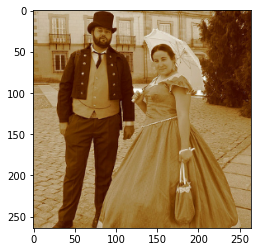

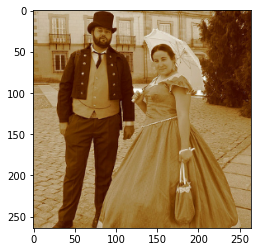

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.sum_axes = False
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.normalize_spectral_density_per_step = False
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model,do_clip=True)

In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -19.353762922529754
action means and variances at step -10: [ 0.16287579 -0.24281961] [0.94940126 0.91658679]
action means and variances at step -5: [0.17820421 0.3615748 ] [0.68476638 1.15372208]
action statmeans and variances at step -10: [-0.00958435 -0.01583768] [1. 1.]
action statmeans and variances at step -5: [-0.00520716 -0.01622627] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -18.91822561297041
action means and variances at step -10: [-0.14841624 -0.01293096] [0.8198512 0.9007342]
action means and variances at step -5: [0.1901054  0.00833142] [0.79947648 0.61114994]
action statmeans and variances at step -10: [-0.0260381  -0.05222497] [1. 1.]
action statmeans and variances at step -5: [-0.02975174 -0.03211748] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -19.65927567855852
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 12 * Episodic Reward is ==> -15.589334689480443
action means and variances at step -10: [-0.31559438 -0.04479521] [0.82157682 1.19841586]
action means and variances at step -5: [-0.83255574  0.3019258 ] [1.02425928 1.12499446]
action statmeans and variances at step -10: [-0.71951026  0.05944026] [1. 1.]
action statmeans and variances at step -5: [-0.72003746  0.05585744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 13 * Episodic Reward is ==> -15.064834697949454
action means and variances at step -10: [-0.42743034  0.26894628] [0.86237476 0.94996289]
action means and variances at step -5: [-0.6952787  -0.03999553] [1.18493132 1.19937038]
action statmeans and variances at step -10: [-0.81182224 -0.02795708] [1. 1.]
action statmeans and variances at step -5: [-0.82108945 -0.02368168] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 14 * Episodic Reward is ==> -14.881228828685945
action means and varian

Training for 17 iterations with batchsize 64
Episode * 24 * Episodic Reward is ==> -15.294132444119604
action means and variances at step -10: [-0.77157528  0.19452384] [1.13615772 0.79663645]
action means and variances at step -5: [-0.69501679 -0.09590909] [1.42785834 0.88459314]
action statmeans and variances at step -10: [-0.6263036  -0.00354098] [1. 1.]
action statmeans and variances at step -5: [-0.63482964  0.00525666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 25 * Episodic Reward is ==> -16.074665982893062
action means and variances at step -10: [-0.49423161 -0.01169677] [0.80287335 0.9864596 ]
action means and variances at step -5: [-0.58758156 -0.31953786] [0.67183475 1.1976124 ]
action statmeans and variances at step -10: [-0.5973106  -0.11592041] [1. 1.]
action statmeans and variances at step -5: [-0.6021987  -0.10365922] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 26 * Episodic Reward is ==> -15.691941553685501
action means and varian

Training for 17 iterations with batchsize 64
Episode * 36 * Episodic Reward is ==> -15.045407340047188
action means and variances at step -10: [-1.18265198 -0.11965527] [0.82399601 0.56766406]
action means and variances at step -5: [-0.75037198  0.0662868 ] [0.96153506 0.57382435]
action statmeans and variances at step -10: [-1.0017798   0.10941298] [1. 1.]
action statmeans and variances at step -5: [-1.003907    0.11701298] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 37 * Episodic Reward is ==> -14.229736226534715
action means and variances at step -10: [-1.21162463  0.06649162] [0.93424891 1.01463118]
action means and variances at step -5: [-1.14807052 -0.07625638] [1.22954199 0.89262732]
action statmeans and variances at step -10: [-1.0414555  -0.00547037] [1. 1.]
action statmeans and variances at step -5: [-1.0470673   0.00539527] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 38 * Episodic Reward is ==> -15.122026861139698
action means and varian

Training for 17 iterations with batchsize 64
Episode * 48 * Episodic Reward is ==> -15.459525702179942
action means and variances at step -10: [-1.4852224   0.23999297] [1.50984053 0.76614655]
action means and variances at step -5: [-1.53873153 -0.11126593] [0.60135952 0.89831132]
action statmeans and variances at step -10: [-1.5439808   0.03075742] [1. 1.]
action statmeans and variances at step -5: [-1.541699    0.02336099] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 49 * Episodic Reward is ==> -15.654579067554055
action means and variances at step -10: [-1.74335908 -0.18052622] [0.9165307  0.76596191]
action means and variances at step -5: [-1.4447435  -0.13719721] [1.26259125 1.68300788]
action statmeans and variances at step -10: [-1.570074   -0.05569135] [1. 1.]
action statmeans and variances at step -5: [-1.5697169  -0.04864702] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 50 * Episodic Reward is ==> -14.797813856409848
action means and varian

Training for 17 iterations with batchsize 64
Episode * 60 * Episodic Reward is ==> -15.161597112462571
action means and variances at step -10: [-0.87980253 -0.13701917] [0.85920284 0.55455298]
action means and variances at step -5: [-0.72420573 -0.18269283] [0.77363165 1.00470974]
action statmeans and variances at step -10: [-0.84705216 -0.04184082] [1. 1.]
action statmeans and variances at step -5: [-0.85747325 -0.0083621 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 61 * Episodic Reward is ==> -14.771940877545001
action means and variances at step -10: [-0.91807199 -0.11265862] [0.61121647 0.86709735]
action means and variances at step -5: [-0.93485888  0.01352735] [0.91619176 1.00039702]
action statmeans and variances at step -10: [-0.9392762 -0.0642295] [1. 1.]
action statmeans and variances at step -5: [-0.9446249  -0.05274648] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 62 * Episodic Reward is ==> -14.411764985727842
action means and variance

Training for 17 iterations with batchsize 64
Episode * 72 * Episodic Reward is ==> -14.608422607369281
action means and variances at step -10: [-1.34258788  0.09123628] [1.2772647  1.15553892]
action means and variances at step -5: [-0.94172745  0.11951649] [1.25612564 0.81093478]
action statmeans and variances at step -10: [-1.0824126  -0.02756653] [1. 1.]
action statmeans and variances at step -5: [-1.0739305  -0.03548605] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 73 * Episodic Reward is ==> -14.870120524043982
action means and variances at step -10: [-1.26857342 -0.17806271] [0.96122037 0.99985108]
action means and variances at step -5: [-1.38745066 -0.03177069] [1.09279769 0.82067495]
action statmeans and variances at step -10: [-1.0918648  -0.06345846] [1. 1.]
action statmeans and variances at step -5: [-1.0923798 -0.0600185] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 74 * Episodic Reward is ==> -15.112304949648376
action means and variance

Training for 17 iterations with batchsize 64
Episode * 84 * Episodic Reward is ==> -16.186883263351188
action means and variances at step -10: [-1.90629445  0.03293257] [1.12390117 1.02854818]
action means and variances at step -5: [-2.0124073   0.00737546] [1.27827783 0.82708684]
action statmeans and variances at step -10: [-1.8911881   0.11684643] [1. 1.]
action statmeans and variances at step -5: [-1.8902831   0.11843972] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 85 * Episodic Reward is ==> -17.988588394530762
action means and variances at step -10: [-2.16112024  0.14522852] [1.03504929 0.89346299]
action means and variances at step -5: [-1.80583748  0.2121106 ] [1.33346019 0.6524622 ]
action statmeans and variances at step -10: [-2.0059645   0.17067932] [1. 1.]
action statmeans and variances at step -5: [-2.0102816   0.19390231] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 86 * Episodic Reward is ==> -16.799681790958054
action means and varian

Training for 17 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> -16.31883676430317
action means and variances at step -10: [-1.72382538 -0.02942065] [1.25349678 0.62737183]
action means and variances at step -5: [-1.77420304 -0.18501507] [0.88480746 0.82998359]
action statmeans and variances at step -10: [-1.7320547   0.04682539] [1. 1.]
action statmeans and variances at step -5: [-1.7315593   0.06049101] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> -15.986162822646344
action means and variances at step -10: [-1.64865728  0.09671963] [1.11801121 0.73230428]
action means and variances at step -5: [-1.71844766  0.20421009] [0.84104893 0.84667996]
action statmeans and variances at step -10: [-1.7152424   0.06124485] [1. 1.]
action statmeans and variances at step -5: [-1.7150899   0.07749303] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> -16.074296020997156
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 108 * Episodic Reward is ==> -17.241856730727946
action means and variances at step -10: [-2.32525152  0.43347257] [1.05626954 0.91855621]
action means and variances at step -5: [-2.1127469  -0.05883307] [0.96296261 1.03390621]
action statmeans and variances at step -10: [-2.0728488   0.13425563] [1. 1.]
action statmeans and variances at step -5: [-2.0678642   0.12225777] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 109 * Episodic Reward is ==> -17.768175383764923
action means and variances at step -10: [-1.96438698  0.20718098] [0.55665609 0.80204189]
action means and variances at step -5: [-1.76651929  0.02483482] [1.02795223 0.79584228]
action statmeans and variances at step -10: [-2.01993    0.2189875] [1. 1.]
action statmeans and variances at step -5: [-2.0158541   0.21525666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 110 * Episodic Reward is ==> -17.555497319454027
action means and varia

Training for 17 iterations with batchsize 64
Episode * 120 * Episodic Reward is ==> -16.277302618578894
action means and variances at step -10: [-1.89993655  0.08173501] [1.15457394 0.79508312]
action means and variances at step -5: [-1.87319971 -0.0187974 ] [0.85958371 0.96211567]
action statmeans and variances at step -10: [-1.9162784   0.08977574] [1. 1.]
action statmeans and variances at step -5: [-1.9156294   0.11949755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 121 * Episodic Reward is ==> -16.630881561128675
action means and variances at step -10: [-1.8561377  -0.09121185] [0.96812528 0.77149598]
action means and variances at step -5: [-2.25063814  0.21075965] [0.92096092 0.98681208]
action statmeans and variances at step -10: [-1.9889238  0.1647611] [1. 1.]
action statmeans and variances at step -5: [-1.9881846  0.1584284] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 122 * Episodic Reward is ==> -15.974771020755686
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 132 * Episodic Reward is ==> -17.044995771640174
action means and variances at step -10: [-2.50147598  0.72146245] [0.91275873 0.76781385]
action means and variances at step -5: [-2.28630575  0.30619265] [0.98880295 0.7829005 ]
action statmeans and variances at step -10: [-2.2875261  0.3175144] [1. 1.]
action statmeans and variances at step -5: [-2.286705    0.29558864] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 133 * Episodic Reward is ==> -16.70806111456179
action means and variances at step -10: [-2.43952663  0.06080143] [0.98046525 0.82804135]
action means and variances at step -5: [-2.01976478  0.12325745] [1.00133903 1.04389644]
action statmeans and variances at step -10: [-2.3373504   0.15952188] [1. 1.]
action statmeans and variances at step -5: [-2.3329444   0.14338496] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 134 * Episodic Reward is ==> -17.25063631635614
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 144 * Episodic Reward is ==> -18.754517237297453
action means and variances at step -10: [-2.73435022  0.75910765] [0.79026806 1.06051871]
action means and variances at step -5: [-2.47703735  0.39646238] [0.6196845 1.0525022]
action statmeans and variances at step -10: [-2.6450567   0.34482378] [1. 1.]
action statmeans and variances at step -5: [-2.6409721   0.33331275] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 145 * Episodic Reward is ==> -19.15989408294929
action means and variances at step -10: [-2.60983001  0.59726332] [0.95378688 1.44641705]
action means and variances at step -5: [-2.28594666  0.3607953 ] [0.9425876  0.95192494]
action statmeans and variances at step -10: [-2.5611625   0.45100504] [1. 1.]
action statmeans and variances at step -5: [-2.5597224  0.4628857] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 146 * Episodic Reward is ==> -18.491059928333588
action means and variance

Training for 17 iterations with batchsize 64
Episode * 156 * Episodic Reward is ==> -16.479254232620413
action means and variances at step -10: [-2.33057715  0.10842663] [0.93506454 1.20769724]
action means and variances at step -5: [-1.77702407  0.17117377] [1.17449988 0.85769671]
action statmeans and variances at step -10: [-2.2835653   0.14390305] [1. 1.]
action statmeans and variances at step -5: [-2.2828267  0.1596216] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 157 * Episodic Reward is ==> -16.846165489339246
action means and variances at step -10: [-2.4351894   0.17669079] [0.86816021 1.21595803]
action means and variances at step -5: [-2.36173875  0.12397036] [1.35047773 1.51400176]
action statmeans and variances at step -10: [-2.192811   0.3497975] [1. 1.]
action statmeans and variances at step -5: [-2.1836553   0.29411584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 158 * Episodic Reward is ==> -16.34249799098144
action means and variance

Training for 17 iterations with batchsize 64
Episode * 168 * Episodic Reward is ==> -14.929201119983034
action means and variances at step -10: [-1.39777833 -0.09294783] [0.89912591 0.93996218]
action means and variances at step -5: [-1.31850329  0.33207262] [0.86534047 1.14110924]
action statmeans and variances at step -10: [-1.6828887   0.01413861] [1. 1.]
action statmeans and variances at step -5: [-1.6852945   0.09910366] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 169 * Episodic Reward is ==> -15.368760147918925
action means and variances at step -10: [-1.40650966  0.15118578] [0.67670492 0.85155319]
action means and variances at step -5: [-1.25354454  0.19016253] [0.56641144 1.04251359]
action statmeans and variances at step -10: [-1.5763845  -0.05156653] [1. 1.]
action statmeans and variances at step -5: [-1.5738597 -0.0473784] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 170 * Episodic Reward is ==> -15.288355460912307
action means and varia

Training for 17 iterations with batchsize 64
Episode * 180 * Episodic Reward is ==> -15.483778756419282
action means and variances at step -10: [-1.80058198 -0.24968948] [1.40192517 0.90382067]
action means and variances at step -5: [-1.58073383  0.13347477] [0.80233333 0.62145908]
action statmeans and variances at step -10: [-1.5965366   0.01372534] [1. 1.]
action statmeans and variances at step -5: [-1.5932453  -0.01119896] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> -15.40326070858335
action means and variances at step -10: [-1.91827987 -0.20530414] [1.16373303 1.22361839]
action means and variances at step -5: [-1.74123038  0.02647073] [1.06543854 0.9604015 ]
action statmeans and variances at step -10: [-1.7323117  0.0178238] [1. 1.]
action statmeans and variances at step -5: [-1.7330837  -0.08758273] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> -15.137468843511776
action means and varian

Training for 17 iterations with batchsize 64
Episode * 192 * Episodic Reward is ==> -16.158145271887673
action means and variances at step -10: [-2.30143412 -0.14547503] [0.95233791 1.03594867]
action means and variances at step -5: [-2.51416313  0.16666814] [0.7344912  0.72938752]
action statmeans and variances at step -10: [-2.2348554   0.04746044] [1. 1.]
action statmeans and variances at step -5: [-2.2359262   0.07171144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 193 * Episodic Reward is ==> -15.465539377008632
action means and variances at step -10: [-2.45670594  0.28790789] [1.12285343 1.04231961]
action means and variances at step -5: [-2.66390752  0.08622234] [0.92587663 0.65112325]
action statmeans and variances at step -10: [-2.41279     0.10827616] [1. 1.]
action statmeans and variances at step -5: [-2.4101658   0.03971009] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 194 * Episodic Reward is ==> -17.688613738776027
action means and var

Training for 17 iterations with batchsize 64
Episode * 204 * Episodic Reward is ==> -14.93631460646553
action means and variances at step -10: [-1.88356086  0.02300505] [0.84538405 0.49284317]
action means and variances at step -5: [-1.9267192  -0.05466481] [0.8310775  0.99490355]
action statmeans and variances at step -10: [-1.926589   -0.05787419] [1. 1.]
action statmeans and variances at step -5: [-1.9286895  -0.03969775] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 205 * Episodic Reward is ==> -16.24337941144146
action means and variances at step -10: [-1.70781462  0.29338739] [0.86090967 0.8063546 ]
action means and variances at step -5: [-2.00375217  0.08013719] [0.88712748 0.96001996]
action statmeans and variances at step -10: [-1.8097447   0.02517453] [1. 1.]
action statmeans and variances at step -5: [-1.8101845  0.0599498] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 206 * Episodic Reward is ==> -15.81530531241032
action means and variance

Training for 17 iterations with batchsize 64
Episode * 216 * Episodic Reward is ==> -14.737727261235635
action means and variances at step -10: [-1.89353686 -0.2270393 ] [1.10214983 1.09388672]
action means and variances at step -5: [-1.95010969  0.12517702] [1.33914899 0.81362545]
action statmeans and variances at step -10: [-1.9637951   0.22779486] [1. 1.]
action statmeans and variances at step -5: [-1.963664    0.20646879] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 217 * Episodic Reward is ==> -15.203403548522587
action means and variances at step -10: [-1.84626699  0.1155444 ] [0.96947211 1.24500209]
action means and variances at step -5: [-1.92602372  0.36473465] [0.85196237 1.24425171]
action statmeans and variances at step -10: [-2.0410128   0.24559385] [1. 1.]
action statmeans and variances at step -5: [-2.0451396  0.3158345] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 218 * Episodic Reward is ==> -14.347014602521533
action means and varia

Training for 17 iterations with batchsize 64
Episode * 228 * Episodic Reward is ==> -15.214647804798215
action means and variances at step -10: [-2.0879462  -0.20976659] [0.73463231 1.09869446]
action means and variances at step -5: [-1.9550286 -0.1154024] [1.04279089 1.03485807]
action statmeans and variances at step -10: [-2.0337057  -0.04696735] [1. 1.]
action statmeans and variances at step -5: [-2.0375600e+00 -1.7289033e-03] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 229 * Episodic Reward is ==> -14.365499016161944
action means and variances at step -10: [-2.06612978  0.13853439] [0.9102814 1.1753651]
action means and variances at step -5: [-1.91325267 -0.05666518] [0.81598731 0.67606318]
action statmeans and variances at step -10: [-1.8907244   0.00845373] [1. 1.]
action statmeans and variances at step -5: [-1.8919351  -0.01884369] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 230 * Episodic Reward is ==> -14.818452448680318
action means and v

Training for 17 iterations with batchsize 64
Episode * 240 * Episodic Reward is ==> -14.480654308424818
action means and variances at step -10: [-1.54980641  0.43650032] [1.0135604  1.02300495]
action means and variances at step -5: [-1.76211514  0.14636074] [0.815192   0.63043043]
action statmeans and variances at step -10: [-1.7481167   0.11221019] [1. 1.]
action statmeans and variances at step -5: [-1.7581277   0.27529442] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 241 * Episodic Reward is ==> -14.455275866567925
action means and variances at step -10: [-1.52856273  0.22186051] [1.01873196 0.49380307]
action means and variances at step -5: [-1.62036016  0.12644321] [1.20283745 1.32244529]
action statmeans and variances at step -10: [-1.587594    0.23811245] [1. 1.]
action statmeans and variances at step -5: [-1.5864086  0.1492032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 242 * Episodic Reward is ==> -14.105120620978429
action means and varia

Training for 17 iterations with batchsize 64
Episode * 252 * Episodic Reward is ==> -14.815978638344987
action means and variances at step -10: [-1.73174204  0.21757002] [0.90187813 1.07022522]
action means and variances at step -5: [-1.8228067  0.2726315] [0.87818566 0.86656062]
action statmeans and variances at step -10: [-1.998893    0.19201317] [1. 1.]
action statmeans and variances at step -5: [-1.9930723   0.08723701] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 253 * Episodic Reward is ==> -14.907630836131291
action means and variances at step -10: [-1.89664504 -0.25080707] [0.90074996 0.77697774]
action means and variances at step -5: [-2.35636183 -0.11788684] [0.8657701  1.06106078]
action statmeans and variances at step -10: [-2.1703537   0.23200567] [1. 1.]
action statmeans and variances at step -5: [-2.1646323   0.03772211] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 254 * Episodic Reward is ==> -14.961055742719422
action means and varia

Training for 17 iterations with batchsize 64
Episode * 264 * Episodic Reward is ==> -17.52086089310515
action means and variances at step -10: [-2.71069016  0.00596465] [0.94729135 1.04494927]
action means and variances at step -5: [-2.45505883  0.05636614] [0.95846768 0.84424811]
action statmeans and variances at step -10: [-2.5533805  -0.14060965] [1. 1.]
action statmeans and variances at step -5: [-2.555795   -0.10092965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 265 * Episodic Reward is ==> -17.946455531915078
action means and variances at step -10: [-2.83557018 -0.43397174] [0.8687365  0.68120556]
action means and variances at step -5: [-2.70286963 -0.34268153] [0.73070346 1.18534527]
action statmeans and variances at step -10: [-2.6088398 -0.3236738] [1. 1.]
action statmeans and variances at step -5: [-2.6132004  -0.18172246] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 266 * Episodic Reward is ==> -17.974538432700857
action means and varian

Training for 17 iterations with batchsize 64
Episode * 276 * Episodic Reward is ==> -16.312724055246473
action means and variances at step -10: [-2.39550261 -0.02255054] [0.6134929  0.86959418]
action means and variances at step -5: [-2.68965795  0.29267401] [1.22697657 0.68589787]
action statmeans and variances at step -10: [-2.3470826  -0.23513359] [1. 1.]
action statmeans and variances at step -5: [-2.364484   -0.06361835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 277 * Episodic Reward is ==> -17.07914175802877
action means and variances at step -10: [-2.31727241 -0.38408126] [0.99529269 0.90357585]
action means and variances at step -5: [-2.45915268  0.7479412 ] [0.91536868 1.00848248]
action statmeans and variances at step -10: [-2.4630904   0.38412425] [1. 1.]
action statmeans and variances at step -5: [-2.4669526  0.3624733] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 278 * Episodic Reward is ==> -16.89279259851481
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 288 * Episodic Reward is ==> -16.621295866196835
action means and variances at step -10: [-3.04719695 -0.22240452] [0.96461324 1.04791385]
action means and variances at step -5: [-2.63895764  0.01891488] [0.73149245 0.79560695]
action statmeans and variances at step -10: [-2.7137756  -0.18500638] [1. 1.]
action statmeans and variances at step -5: [-2.713085   -0.29737473] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 289 * Episodic Reward is ==> -16.36718123670436
action means and variances at step -10: [-2.89849103  0.42811907] [1.0161137 0.9057631]
action means and variances at step -5: [-2.79471486  0.11706412] [0.78255576 0.74134191]
action statmeans and variances at step -10: [-2.705453    0.01152712] [1. 1.]
action statmeans and variances at step -5: [-2.7015228 -0.2841633] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 290 * Episodic Reward is ==> -16.279631847934247
action means and variance

Training for 17 iterations with batchsize 64
Episode * 300 * Episodic Reward is ==> -17.91277956547958
action means and variances at step -10: [-2.58192081 -0.19466651] [1.01009241 1.0782593 ]
action means and variances at step -5: [-2.94605581 -0.31771919] [0.79519194 0.98977669]
action statmeans and variances at step -10: [-2.7342093  -0.34587294] [1. 1.]
action statmeans and variances at step -5: [-2.7329571 -0.457659 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 301 * Episodic Reward is ==> -18.178225513038733
action means and variances at step -10: [-2.61747839 -0.42059086] [1.1447772  0.93926082]
action means and variances at step -5: [-2.66826465 -0.65799613] [1.13593741 1.29474919]
action statmeans and variances at step -10: [-2.726469  -0.4263782] [1. 1.]
action statmeans and variances at step -5: [-2.7236865  -0.68361825] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 302 * Episodic Reward is ==> -16.511464663763963
action means and variance

Training for 17 iterations with batchsize 64
Episode * 312 * Episodic Reward is ==> -16.115733706648697
action means and variances at step -10: [-2.85055761  0.00744448] [0.78512435 1.17205009]
action means and variances at step -5: [-2.87061334e+00 -1.18056472e-03] [1.07276633 0.90673844]
action statmeans and variances at step -10: [-2.6531217 -0.192864 ] [1. 1.]
action statmeans and variances at step -5: [-2.656467    0.33162838] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 313 * Episodic Reward is ==> -16.081144767697175
action means and variances at step -10: [-2.72479695  0.06733285] [0.95079908 0.78382582]
action means and variances at step -5: [-2.69306734  0.20266647] [0.58538241 0.94896813]
action statmeans and variances at step -10: [-2.6722107  0.4825021] [1. 1.]
action statmeans and variances at step -5: [-2.6738036   0.40411812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 314 * Episodic Reward is ==> -16.836996307736886
action means and

Training for 17 iterations with batchsize 64
Episode * 324 * Episodic Reward is ==> -16.04751223470592
action means and variances at step -10: [-2.98026386  0.0769266 ] [0.49091932 1.41528058]
action means and variances at step -5: [-2.7362188   0.21972338] [1.19471372 1.05576528]
action statmeans and variances at step -10: [-2.729764    0.28634176] [1. 1.]
action statmeans and variances at step -5: [-2.7317343   0.02573139] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 325 * Episodic Reward is ==> -16.3241349786681
action means and variances at step -10: [-2.69019561  0.28818879] [0.87426383 1.21380646]
action means and variances at step -5: [-2.62612392  0.21792695] [0.87249753 0.87039652]
action statmeans and variances at step -10: [-2.7469602  -0.05183066] [1. 1.]
action statmeans and variances at step -5: [-2.748607    0.01367106] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 326 * Episodic Reward is ==> -17.546243819282303
action means and varian

Training for 17 iterations with batchsize 64
Episode * 336 * Episodic Reward is ==> -16.693854585768307
action means and variances at step -10: [-2.57989186  0.01221512] [0.78444251 0.59074014]
action means and variances at step -5: [-2.69736386 -0.01675826] [1.00090352 0.9441008 ]
action statmeans and variances at step -10: [-2.7986524  -0.00721236] [1. 1.]
action statmeans and variances at step -5: [-2.7975175   0.06958143] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 337 * Episodic Reward is ==> -16.68379062059494
action means and variances at step -10: [-2.82116796 -0.16423315] [0.57405979 0.96114649]
action means and variances at step -5: [-2.71257194 -0.12855087] [0.95051507 1.21204609]
action statmeans and variances at step -10: [-2.8206549   0.48702094] [1. 1.]
action statmeans and variances at step -5: [-2.8255093   0.04275639] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 338 * Episodic Reward is ==> -17.014018104692692
action means and vari

Training for 17 iterations with batchsize 64
Episode * 348 * Episodic Reward is ==> -20.449048704596144
action means and variances at step -10: [-2.80407236  0.27669516] [0.80726791 1.35591567]
action means and variances at step -5: [-2.66504808  0.6491991 ] [1.30695037 0.6557203 ]
action statmeans and variances at step -10: [-2.8293283   0.66299826] [1. 1.]
action statmeans and variances at step -5: [-2.8301158   0.59825575] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 349 * Episodic Reward is ==> -19.354795833769053
action means and variances at step -10: [-2.57211529  0.4229082 ] [1.26623252 0.6308906 ]
action means and variances at step -5: [-2.80221193 -0.02942762] [1.65225344 1.10187459]
action statmeans and variances at step -10: [-2.8358274  0.6809169] [1. 1.]
action statmeans and variances at step -5: [-2.8366482  0.5219581] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 350 * Episodic Reward is ==> -19.90795726812297
action means and variance

Training for 17 iterations with batchsize 64
Episode * 360 * Episodic Reward is ==> -16.80368500249001
action means and variances at step -10: [-2.51691875  0.03794143] [1.51457363 1.04710786]
action means and variances at step -5: [-2.97840404  0.28128712] [1.07570263 0.97750199]
action statmeans and variances at step -10: [-2.8160806   0.19635724] [1. 1.]
action statmeans and variances at step -5: [-2.818895  -0.0057197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 361 * Episodic Reward is ==> -16.414799520810533
action means and variances at step -10: [-3.02137804 -0.14852401] [1.1257433  1.25548912]
action means and variances at step -5: [-2.90438253 -0.00512952] [0.70813328 1.47720799]
action statmeans and variances at step -10: [-2.8095698  -0.03066308] [1. 1.]
action statmeans and variances at step -5: [-2.8074594   0.34748518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 362 * Episodic Reward is ==> -16.417428793914546
action means and varian

Training for 17 iterations with batchsize 64
Episode * 372 * Episodic Reward is ==> -16.712901447584464
action means and variances at step -10: [-3.05212047  0.28418967] [1.56038714 0.66247443]
action means and variances at step -5: [-2.92612653  0.22434603] [1.16793444 0.68314189]
action statmeans and variances at step -10: [-2.8290753   0.09701091] [1. 1.]
action statmeans and variances at step -5: [-2.8336399 -0.7114164] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 373 * Episodic Reward is ==> -18.377302271371946
action means and variances at step -10: [-2.88211374  0.24479926] [0.97178728 0.74441996]
action means and variances at step -5: [-2.72553057  0.48095503] [0.72666142 1.05537709]
action statmeans and variances at step -10: [-2.836336   0.3818136] [1. 1.]
action statmeans and variances at step -5: [-2.8370166   0.38564909] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 374 * Episodic Reward is ==> -18.433612784143687
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 384 * Episodic Reward is ==> -18.833113179867972
action means and variances at step -10: [-2.81299037  0.03127025] [0.75527382 1.41847879]
action means and variances at step -5: [-3.04792578  0.03763348] [0.70279413 0.63569429]
action statmeans and variances at step -10: [-2.8415759   0.26530427] [1. 1.]
action statmeans and variances at step -5: [-2.8420115  -0.14020105] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 385 * Episodic Reward is ==> -16.885058955983403
action means and variances at step -10: [-2.74541733  0.28522552] [0.97704939 1.47292555]
action means and variances at step -5: [-2.71593693  0.23168252] [1.17350969 1.0705167 ]
action statmeans and variances at step -10: [-2.8536575  0.502891 ] [1. 1.]
action statmeans and variances at step -5: [-2.8566804  -0.13414994] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 386 * Episodic Reward is ==> -17.077477071241475
action means and varia

Training for 17 iterations with batchsize 64
Episode * 396 * Episodic Reward is ==> -16.515834692667813
action means and variances at step -10: [-2.61386283 -0.07416532] [1.22111329 0.79708162]
action means and variances at step -5: [-3.08670904  0.19509937] [0.88506585 1.14945753]
action statmeans and variances at step -10: [-2.8460388  0.6145096] [1. 1.]
action statmeans and variances at step -5: [-2.851946    0.20857416] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 397 * Episodic Reward is ==> -16.324581003153284
action means and variances at step -10: [-3.34418832 -0.14820402] [0.9839359  1.18268545]
action means and variances at step -5: [-2.86185369 -0.01400474] [0.99613161 0.79937853]
action statmeans and variances at step -10: [-2.853287  -0.6417306] [1. 1.]
action statmeans and variances at step -5: [-2.851336    0.22815064] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 398 * Episodic Reward is ==> -16.369660850205562
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 408 * Episodic Reward is ==> -18.206126693780117
action means and variances at step -10: [-2.82848356 -0.05622941] [0.8735075  0.89064114]
action means and variances at step -5: [-2.87279161 -0.02768526] [0.72238778 1.15002228]
action statmeans and variances at step -10: [-2.8576589  0.1898252] [1. 1.]
action statmeans and variances at step -5: [-2.8593514  -0.31907755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 409 * Episodic Reward is ==> -18.58684430781726
action means and variances at step -10: [-2.90697163  0.3374639 ] [0.85458189 1.10453378]
action means and variances at step -5: [-2.56863797  0.37171535] [1.51224257 1.20199765]
action statmeans and variances at step -10: [-2.8472078  -0.20101133] [1. 1.]
action statmeans and variances at step -5: [-2.851871    0.02491693] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 410 * Episodic Reward is ==> -18.432489415147437
action means and varian

Training for 17 iterations with batchsize 64
Episode * 420 * Episodic Reward is ==> -18.54909799233064
action means and variances at step -10: [-2.76822397 -0.17998622] [0.90247677 1.36226368]
action means and variances at step -5: [-2.86513214 -0.51112784] [0.62602142 1.03455381]
action statmeans and variances at step -10: [-2.8575435  -0.27014083] [1. 1.]
action statmeans and variances at step -5: [-2.8640883 -0.8435892] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 421 * Episodic Reward is ==> -16.780885971526324
action means and variances at step -10: [-2.84977064 -0.53886633] [1.10847635 1.58140218]
action means and variances at step -5: [-2.73167467  0.02147549] [0.76201831 0.89764297]
action statmeans and variances at step -10: [-2.8217359   0.14317673] [1. 1.]
action statmeans and variances at step -5: [-2.8214958   0.42151266] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 422 * Episodic Reward is ==> -16.58646000183356
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 432 * Episodic Reward is ==> -16.330143606798536
action means and variances at step -10: [-2.72146975 -0.03546541] [0.75321644 1.07513868]
action means and variances at step -5: [-2.63911504 -0.17435795] [1.08520856 0.98129048]
action statmeans and variances at step -10: [-2.7614553  -0.00931747] [1. 1.]
action statmeans and variances at step -5: [-2.7565331   0.37815952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 433 * Episodic Reward is ==> -16.314816092790153
action means and variances at step -10: [-2.82328961  0.20947782] [0.83881979 1.47979701]
action means and variances at step -5: [-2.77707471  0.14080161] [0.70429557 0.76370522]
action statmeans and variances at step -10: [-2.7703571 -0.7974488] [1. 1.]
action statmeans and variances at step -5: [-2.7611609  -0.04029809] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 434 * Episodic Reward is ==> -16.4782963229734
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 444 * Episodic Reward is ==> -16.357047736619293
action means and variances at step -10: [-3.0147842  -0.28457091] [0.78891491 1.06282228]
action means and variances at step -5: [-3.127377   -0.07555727] [0.6754008  1.27199881]
action statmeans and variances at step -10: [-2.801076    0.21901262] [1. 1.]
action statmeans and variances at step -5: [-2.802434    0.18783961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 445 * Episodic Reward is ==> -15.601822734950623
action means and variances at step -10: [-2.57341149  0.01633897] [0.65510858 1.43221018]
action means and variances at step -5: [-2.62261332 -0.12844358] [1.22158113 0.91094985]
action statmeans and variances at step -10: [-2.7574654  -0.48440808] [1. 1.]
action statmeans and variances at step -5: [-2.75451     0.52452296] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 446 * Episodic Reward is ==> -16.904329957086254
action means and var

Training for 17 iterations with batchsize 64
Episode * 456 * Episodic Reward is ==> -16.80372308020578
action means and variances at step -10: [-2.61233622  0.09202441] [0.89876753 0.81345059]
action means and variances at step -5: [-2.76850471  0.4044481 ] [1.12678177 1.3310403 ]
action statmeans and variances at step -10: [-2.6316967   0.78169835] [1. 1.]
action statmeans and variances at step -5: [-2.6437402  -0.22494197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 457 * Episodic Reward is ==> -17.727721901700903
action means and variances at step -10: [-2.51689707  0.11653359] [0.97533498 1.25778781]
action means and variances at step -5: [-2.60260416  0.09392347] [0.90567245 1.31768686]
action statmeans and variances at step -10: [-2.6452935  -0.10117212] [1. 1.]
action statmeans and variances at step -5: [-2.6533127  -0.44406134] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 458 * Episodic Reward is ==> -16.767801515032946
action means and vari

Training for 17 iterations with batchsize 64
Episode * 468 * Episodic Reward is ==> -15.70032296830145
action means and variances at step -10: [-2.44021774 -0.32400225] [0.79857335 0.66843559]
action means and variances at step -5: [-2.65448418 -0.19845724] [1.02666099 0.89829636]
action statmeans and variances at step -10: [-2.7463427  -0.50627863] [1. 1.]
action statmeans and variances at step -5: [-2.7417102 -0.4953903] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 469 * Episodic Reward is ==> -16.070130182096143
action means and variances at step -10: [-2.51648571 -0.08265571] [0.7692486 1.097398 ]
action means and variances at step -5: [-2.67832732  0.02527497] [1.22442065 1.79043257]
action statmeans and variances at step -10: [-2.7378736   0.46590817] [1. 1.]
action statmeans and variances at step -5: [-2.7475972  -0.29008982] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 470 * Episodic Reward is ==> -15.782933452353646
action means and variance

Training for 17 iterations with batchsize 64
Episode * 480 * Episodic Reward is ==> -17.030981268135275
action means and variances at step -10: [-2.87155058 -0.059334  ] [1.40597175 0.93206221]
action means and variances at step -5: [-2.81808203  0.32011337] [1.37964896 1.04164589]
action statmeans and variances at step -10: [-2.7384856  0.6859668] [1. 1.]
action statmeans and variances at step -5: [-2.746262   0.2793027] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 481 * Episodic Reward is ==> -16.820462998969155
action means and variances at step -10: [-2.7632169  -0.05863122] [1.12462232 1.40628927]
action means and variances at step -5: [-3.19003628  0.09981223] [0.57781179 0.6546627 ]
action statmeans and variances at step -10: [-2.780267  -1.1240385] [1. 1.]
action statmeans and variances at step -5: [-2.753165    0.29358006] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 482 * Episodic Reward is ==> -17.52499680224421
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 492 * Episodic Reward is ==> -16.864908781359873
action means and variances at step -10: [-2.70909718  0.37323793] [0.57144921 1.22479214]
action means and variances at step -5: [-2.70281079  0.21986431] [1.00856449 1.57070989]
action statmeans and variances at step -10: [-2.7693367  0.4801395] [1. 1.]
action statmeans and variances at step -5: [-2.7703786   0.45454568] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 493 * Episodic Reward is ==> -16.479176169765243
action means and variances at step -10: [-2.52036955 -0.00526584] [1.08064269 1.13075845]
action means and variances at step -5: [-2.95227971  0.30208859] [0.87875074 1.38274142]
action statmeans and variances at step -10: [-2.7314768  -0.29716295] [1. 1.]
action statmeans and variances at step -5: [-2.719261   0.5366268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 494 * Episodic Reward is ==> -15.356762017304202
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 504 * Episodic Reward is ==> -15.926606960510892
action means and variances at step -10: [-2.77162517 -0.26800363] [1.23878954 2.03945164]
action means and variances at step -5: [-2.77423659  0.04337367] [0.87614853 1.18796745]
action statmeans and variances at step -10: [-2.755515   -0.42537868] [1. 1.]
action statmeans and variances at step -5: [-2.7703466 -1.2551688] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 505 * Episodic Reward is ==> -17.42654329210906
action means and variances at step -10: [-3.10793186 -0.38315275] [0.87128708 1.33783039]
action means and variances at step -5: [-2.84882088 -0.14076556] [0.94212235 1.20864569]
action statmeans and variances at step -10: [-2.7706423 -1.0395244] [1. 1.]
action statmeans and variances at step -5: [-2.7463417  -0.08618058] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 506 * Episodic Reward is ==> -17.01639240469317
action means and variances

Training for 17 iterations with batchsize 64
Episode * 516 * Episodic Reward is ==> -15.573733869810603
action means and variances at step -10: [-2.54387946 -0.06501806] [1.84104747 2.24669203]
action means and variances at step -5: [-2.62037794 -0.28522257] [0.79743625 1.40942144]
action statmeans and variances at step -10: [-2.666934  -1.2797225] [1. 1.]
action statmeans and variances at step -5: [-2.6554697  -0.59384644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 517 * Episodic Reward is ==> -14.761988344854343
action means and variances at step -10: [-3.16000937 -0.24706262] [0.62078162 1.87338198]
action means and variances at step -5: [-2.61877876 -0.05970582] [1.23497327 1.10463426]
action statmeans and variances at step -10: [-2.6908522 -1.0792439] [1. 1.]
action statmeans and variances at step -5: [-2.686203   -0.82988477] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 518 * Episodic Reward is ==> -15.842348259700973
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 528 * Episodic Reward is ==> -16.438770170352754
action means and variances at step -10: [-2.31950766  0.0386394 ] [1.00548351 1.58065163]
action means and variances at step -5: [-2.75078045  0.21956813] [0.79782502 1.31061246]
action statmeans and variances at step -10: [-2.641219  -1.4745672] [1. 1.]
action statmeans and variances at step -5: [-2.6038256   0.65144885] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 529 * Episodic Reward is ==> -17.177527824712172
action means and variances at step -10: [-2.41370722  0.4819154 ] [0.83377688 1.29307265]
action means and variances at step -5: [-2.27739014 -0.02872414] [1.39035974 1.3325715 ]
action statmeans and variances at step -10: [-2.5523348  1.1149766] [1. 1.]
action statmeans and variances at step -5: [-2.6023555  -0.80600184] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 530 * Episodic Reward is ==> -16.570040587569046
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 540 * Episodic Reward is ==> -16.083195319675003
action means and variances at step -10: [-2.50515322  0.14383106] [0.83600883 1.98288704]
action means and variances at step -5: [-2.87913702 -0.57697184] [1.10608383 1.83631253]
action statmeans and variances at step -10: [-2.7202358   0.52507484] [1. 1.]
action statmeans and variances at step -5: [-2.6770954  2.0116415] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 541 * Episodic Reward is ==> -16.80193227849677
action means and variances at step -10: [-2.80761264  0.23716715] [1.04895635 1.35612895]
action means and variances at step -5: [-2.78876131  0.0608297 ] [0.8583738  2.01450422]
action statmeans and variances at step -10: [-2.7836776 -1.3529614] [1. 1.]
action statmeans and variances at step -5: [-2.800539  -2.1578283] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 542 * Episodic Reward is ==> -16.77681165345266
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 552 * Episodic Reward is ==> -15.210559792555713
action means and variances at step -10: [-2.52918468  0.35110294] [1.39728609 2.32689156]
action means and variances at step -5: [-2.26313062  0.0745126 ] [1.4718445  1.22825083]
action statmeans and variances at step -10: [-2.456079    0.55760705] [1. 1.]
action statmeans and variances at step -5: [-2.4617305  0.5566552] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 553 * Episodic Reward is ==> -15.230851871424889
action means and variances at step -10: [-2.75248642 -0.30575172] [0.69300633 2.53559846]
action means and variances at step -5: [-2.47322829 -0.32761928] [0.97239337 2.12020384]
action statmeans and variances at step -10: [-2.5093827  0.4837131] [1. 1.]
action statmeans and variances at step -5: [-2.596797  -1.6676986] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 554 * Episodic Reward is ==> -14.896728748313123
action means and variances

Training for 17 iterations with batchsize 64
Episode * 564 * Episodic Reward is ==> -15.225264427272684
action means and variances at step -10: [-2.85307841 -0.22189453] [1.24078594 2.31275915]
action means and variances at step -5: [-2.41141366 -0.29061963] [0.9532546  1.44961675]
action statmeans and variances at step -10: [-2.603872  -0.7567345] [1. 1.]
action statmeans and variances at step -5: [-2.625324 -1.281524] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 565 * Episodic Reward is ==> -14.606156813384578
action means and variances at step -10: [-2.14948832  0.32184982] [0.83865208 2.31481603]
action means and variances at step -5: [-2.69824446  0.05522152] [0.60436666 2.19560378]
action statmeans and variances at step -10: [-2.5284796 -0.397668 ] [1. 1.]
action statmeans and variances at step -5: [-2.5575578 -0.7760201] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 566 * Episodic Reward is ==> -14.560661909233623
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 576 * Episodic Reward is ==> -15.042053270229928
action means and variances at step -10: [-2.55131159 -0.2709812 ] [0.82090626 2.6395998 ]
action means and variances at step -5: [-2.50894782 -0.25212585] [1.0271327  2.20120467]
action statmeans and variances at step -10: [-2.4309616  1.4985635] [1. 1.]
action statmeans and variances at step -5: [-2.513453   -0.56216645] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 577 * Episodic Reward is ==> -15.499951253007275
action means and variances at step -10: [-2.95676775 -0.43193559] [0.89386068 2.25285822]
action means and variances at step -5: [-2.58944802 -0.17433268] [0.94535386 1.89513465]
action statmeans and variances at step -10: [-2.5288055  -0.24225578] [1. 1.]
action statmeans and variances at step -5: [-2.5620253 -1.6504247] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 578 * Episodic Reward is ==> -14.759926226404986
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 588 * Episodic Reward is ==> -14.953744651348476
action means and variances at step -10: [-2.52481906 -0.24895225] [0.88646623 2.22121597]
action means and variances at step -5: [-2.55403693 -0.24885971] [1.25837917 1.8038463 ]
action statmeans and variances at step -10: [-2.411252 -1.350555] [1. 1.]
action statmeans and variances at step -5: [-2.3787022   0.16586268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 589 * Episodic Reward is ==> -14.78005588274873
action means and variances at step -10: [-2.23956287 -0.00645241] [0.86756474 3.31900397]
action means and variances at step -5: [-2.48006621 -0.32207004] [0.60163467 4.13827534]
action statmeans and variances at step -10: [-2.3071542  1.3190708] [1. 1.]
action statmeans and variances at step -5: [-2.339701   0.8074026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 590 * Episodic Reward is ==> -15.17220501910639
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 600 * Episodic Reward is ==> -13.787107956489319
action means and variances at step -10: [-2.29460171 -0.24759034] [1.04531912 3.09562544]
action means and variances at step -5: [-2.26927698 -0.45520093] [1.1217224  2.78943449]
action statmeans and variances at step -10: [-2.3651602 -2.0683126] [1. 1.]
action statmeans and variances at step -5: [-2.3380644 -1.9960947] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 601 * Episodic Reward is ==> -14.345377174484794
action means and variances at step -10: [-2.41687519 -0.2613054 ] [0.60246697 2.92916221]
action means and variances at step -5: [-2.26370757 -0.33711451] [1.39898954 1.65661184]
action statmeans and variances at step -10: [-2.1971061  1.1645446] [1. 1.]
action statmeans and variances at step -5: [-2.3890176 -2.04734  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 602 * Episodic Reward is ==> -14.470234223077682
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 612 * Episodic Reward is ==> -13.290143529586484
action means and variances at step -10: [-1.94795321 -0.25745705] [0.46071222 1.98871793]
action means and variances at step -5: [-2.49467327 -0.49441361] [0.89575859 1.98248575]
action statmeans and variances at step -10: [-1.9856699  1.4433298] [1. 1.]
action statmeans and variances at step -5: [-2.1639988 -1.40224  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 613 * Episodic Reward is ==> -14.271520655001678
action means and variances at step -10: [-2.2177487   0.05276427] [0.89734133 2.75903987]
action means and variances at step -5: [-2.30623481 -0.17717915] [0.81668854 2.40037725]
action statmeans and variances at step -10: [-2.1186924   0.00825844] [1. 1.]
action statmeans and variances at step -5: [-2.107615    0.55158585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 614 * Episodic Reward is ==> -13.076559283347148
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 624 * Episodic Reward is ==> -13.86666335620261
action means and variances at step -10: [-2.10290909  0.31175913] [0.60431145 1.78428768]
action means and variances at step -5: [-1.63132184  0.25910107] [0.87402194 2.53530264]
action statmeans and variances at step -10: [-2.0798101  1.2508175] [1. 1.]
action statmeans and variances at step -5: [-2.056405   1.4496937] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 625 * Episodic Reward is ==> -13.721691843776805
action means and variances at step -10: [-1.82230677  0.49768423] [0.90098319 2.78998736]
action means and variances at step -5: [-2.26651905 -0.03026546] [0.67459448 2.38422921]
action statmeans and variances at step -10: [-2.0574064  1.5543487] [1. 1.]
action statmeans and variances at step -5: [-2.070064  1.040621] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 626 * Episodic Reward is ==> -13.444437986547914
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 636 * Episodic Reward is ==> -15.779631831245705
action means and variances at step -10: [-2.08609772 -0.33812575] [0.92526993 1.120753  ]
action means and variances at step -5: [-2.22734742 -0.43111109] [1.05378111 0.77655961]
action statmeans and variances at step -10: [-1.9979098   0.12590833] [1. 1.]
action statmeans and variances at step -5: [-2.093521   -0.61643624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 637 * Episodic Reward is ==> -15.052701379434463
action means and variances at step -10: [-1.97949593 -0.26468178] [1.04908715 1.59558201]
action means and variances at step -5: [-1.66306196 -0.48942411] [1.25800946 1.20399719]
action statmeans and variances at step -10: [-2.0049558 -1.6250486] [1. 1.]
action statmeans and variances at step -5: [-1.890682    0.13795868] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 638 * Episodic Reward is ==> -13.168869056635366
action means and varia

Training for 17 iterations with batchsize 64
Episode * 648 * Episodic Reward is ==> -13.072795526095192
action means and variances at step -10: [-1.91365115 -0.16717803] [0.78771468 1.7455133 ]
action means and variances at step -5: [-1.62997404 -0.18370981] [0.5345062  1.53287558]
action statmeans and variances at step -10: [-1.7255445 -1.5920575] [1. 1.]
action statmeans and variances at step -5: [-1.5400982  1.5166233] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 649 * Episodic Reward is ==> -13.112755568322497
action means and variances at step -10: [-1.24817498 -0.68195983] [0.90947554 1.93514544]
action means and variances at step -5: [-1.57547351 -0.5294328 ] [0.75441795 1.20911476]
action statmeans and variances at step -10: [-1.5414838  0.0142551] [1. 1.]
action statmeans and variances at step -5: [-1.6525179 -1.7121637] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 650 * Episodic Reward is ==> -13.555602759521337
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 660 * Episodic Reward is ==> -13.08992874442273
action means and variances at step -10: [-1.45718031  0.03060948] [0.94263233 3.51751114]
action means and variances at step -5: [-1.40547232  0.41661802] [0.70410509 2.26157542]
action statmeans and variances at step -10: [-1.3843726   0.40147883] [1. 1.]
action statmeans and variances at step -5: [-1.2345272  1.8551116] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 661 * Episodic Reward is ==> -12.54652999618971
action means and variances at step -10: [-1.46525397 -0.03201435] [1.05442664 2.89711188]
action means and variances at step -5: [-1.5158669  -0.25333684] [1.40967283 2.74510688]
action statmeans and variances at step -10: [-1.4174997  2.3212097] [1. 1.]
action statmeans and variances at step -5: [-1.1681536  1.9279895] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 662 * Episodic Reward is ==> -12.53131622130677
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 672 * Episodic Reward is ==> -13.047880457050347
action means and variances at step -10: [-1.68970692  0.00808839] [1.29183699 3.18199016]
action means and variances at step -5: [-1.59730828  0.05310684] [0.70304321 2.78075361]
action statmeans and variances at step -10: [-1.5136225 -1.5129046] [1. 1.]
action statmeans and variances at step -5: [-1.5215678 -0.7689112] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 673 * Episodic Reward is ==> -13.302728400845556
action means and variances at step -10: [-1.54046093  0.46204906] [1.00769049 3.49776923]
action means and variances at step -5: [-1.33925699 -0.18335932] [1.1175185  2.54536975]
action statmeans and variances at step -10: [-1.3406585  -0.10841981] [1. 1.]
action statmeans and variances at step -5: [-1.2640777 -0.6760402] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 674 * Episodic Reward is ==> -12.660587194954102
action means and variances

Training for 17 iterations with batchsize 64
Episode * 684 * Episodic Reward is ==> -11.857919181621185
action means and variances at step -10: [-0.83402289 -0.12441026] [1.7209662  4.26406329]
action means and variances at step -5: [-0.50090341 -0.75264968] [0.64056659 2.84584233]
action statmeans and variances at step -10: [-0.6107442  0.910652 ] [1. 1.]
action statmeans and variances at step -5: [-0.7922299  1.8193619] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 685 * Episodic Reward is ==> -12.408734786938673
action means and variances at step -10: [-0.83298812  0.2162759 ] [1.19608617 2.86331729]
action means and variances at step -5: [-0.65374598 -0.21129717] [0.88829593 3.58655564]
action statmeans and variances at step -10: [-1.007556  -1.8914297] [1. 1.]
action statmeans and variances at step -5: [-1.2592813  2.3437922] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 686 * Episodic Reward is ==> -13.070476546092138
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 696 * Episodic Reward is ==> -13.002531259317214
action means and variances at step -10: [-0.80907585  0.18015782] [0.7095729  2.02393177]
action means and variances at step -5: [-1.19586296  0.2950104 ] [0.75281626 1.47954282]
action statmeans and variances at step -10: [-1.1168393 -0.7343198] [1. 1.]
action statmeans and variances at step -5: [-1.1430819  -0.46369126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 697 * Episodic Reward is ==> -12.289973970414017
action means and variances at step -10: [-1.01577188  0.02726171] [1.21454211 2.11246089]
action means and variances at step -5: [-1.07803476  0.27351799] [0.98268761 2.36844237]
action statmeans and variances at step -10: [-0.9931755  -0.61834687] [1. 1.]
action statmeans and variances at step -5: [-1.1390318  1.4787276] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 698 * Episodic Reward is ==> -12.48087949889805
action means and variance

Training for 17 iterations with batchsize 64
Episode * 708 * Episodic Reward is ==> -13.369510650501645
action means and variances at step -10: [-1.01882793  0.13288259] [0.9506976  2.07456341]
action means and variances at step -5: [-1.27919306  0.35123136] [0.9227338 1.3813761]
action statmeans and variances at step -10: [-1.1564897  0.656471 ] [1. 1.]
action statmeans and variances at step -5: [-1.207171   0.6612981] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 709 * Episodic Reward is ==> -12.75146335505189
action means and variances at step -10: [-1.04768064  0.04222295] [2.18469831 0.68476421]
action means and variances at step -5: [-0.7803622   0.03505101] [1.11417311 1.54036827]
action statmeans and variances at step -10: [-1.014379    0.01680241] [1. 1.]
action statmeans and variances at step -5: [-1.0284972 -0.7206878] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 710 * Episodic Reward is ==> -12.792697476468415
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 720 * Episodic Reward is ==> -12.883040585688175
action means and variances at step -10: [-0.95344584  0.63210123] [1.20637443 1.70225003]
action means and variances at step -5: [-1.07195121 -0.08167034] [1.46187594 1.91936128]
action statmeans and variances at step -10: [-0.6977299  -0.42541748] [1. 1.]
action statmeans and variances at step -5: [-1.0235863 -0.9438985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 721 * Episodic Reward is ==> -12.432298262863316
action means and variances at step -10: [-1.23423379  0.11665712] [0.75163371 2.0176757 ]
action means and variances at step -5: [-1.10742476  0.12910953] [1.08029072 1.58226647]
action statmeans and variances at step -10: [-0.9388491   0.26368487] [1. 1.]
action statmeans and variances at step -5: [-0.90098894  0.48971853] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 722 * Episodic Reward is ==> -13.169789244285594
action means and varia

Training for 17 iterations with batchsize 64
Episode * 732 * Episodic Reward is ==> -11.883122736547982
action means and variances at step -10: [-1.0717424  0.1593255] [0.99259921 2.32455591]
action means and variances at step -5: [-1.27577005 -0.22238794] [0.56730607 3.78581434]
action statmeans and variances at step -10: [-1.1632123 -1.5982242] [1. 1.]
action statmeans and variances at step -5: [-1.1428205  -0.36158633] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 733 * Episodic Reward is ==> -11.852396913232536
action means and variances at step -10: [-0.82789033  0.02445648] [1.03321713 2.68057406]
action means and variances at step -5: [-1.10592204 -0.41829825] [0.84225605 3.2699242 ]
action statmeans and variances at step -10: [-1.0952122  2.13063  ] [1. 1.]
action statmeans and variances at step -5: [-1.3093317 -2.133707 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 734 * Episodic Reward is ==> -11.828981854624033
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 744 * Episodic Reward is ==> -12.111876269525325
action means and variances at step -10: [-1.01411945 -0.18747088] [1.07475125 3.3009427 ]
action means and variances at step -5: [-1.09326911 -0.06464753] [0.62555014 3.49489744]
action statmeans and variances at step -10: [-1.0561818 -2.0496082] [1. 1.]
action statmeans and variances at step -5: [-0.9385055  -0.09521659] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 745 * Episodic Reward is ==> -12.18185020384097
action means and variances at step -10: [-1.0567523   0.23697397] [1.10975417 3.65773858]
action means and variances at step -5: [-1.12541687  0.22542342] [0.87440065 2.44180924]
action statmeans and variances at step -10: [-1.0552928   0.38205323] [1. 1.]
action statmeans and variances at step -5: [-1.0941279  0.8675611] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 746 * Episodic Reward is ==> -12.094246064701863
action means and variance

Training for 17 iterations with batchsize 64
Episode * 756 * Episodic Reward is ==> -11.60564944689764
action means and variances at step -10: [-0.65998341  0.27023863] [0.79201453 2.38348428]
action means and variances at step -5: [-0.7049595  -0.12866386] [0.83358613 2.89093826]
action statmeans and variances at step -10: [-0.5001628 -1.448758 ] [1. 1.]
action statmeans and variances at step -5: [-1.0722586  1.9246628] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 757 * Episodic Reward is ==> -11.721797433620317
action means and variances at step -10: [-0.56080859  0.11783002] [0.92293693 2.79156778]
action means and variances at step -5: [-0.76342941 -0.73928968] [1.01574062 2.43509152]
action statmeans and variances at step -10: [-0.587575  -1.3828897] [1. 1.]
action statmeans and variances at step -5: [-0.6489438 -0.9227543] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 758 * Episodic Reward is ==> -12.07092030980549
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 768 * Episodic Reward is ==> -12.90157098088837
action means and variances at step -10: [-0.69131254  0.15623367] [1.09471821 2.76585695]
action means and variances at step -5: [-0.70166899 -0.15443682] [0.97031493 3.03066723]
action statmeans and variances at step -10: [-0.47140628 -0.07802949] [1. 1.]
action statmeans and variances at step -5: [-0.51783985  0.2934296 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 769 * Episodic Reward is ==> -12.374549087827365
action means and variances at step -10: [-0.6237509  -0.35164957] [1.23069949 2.63449537]
action means and variances at step -5: [-0.61146596 -0.74301234] [0.93593197 1.723996  ]
action statmeans and variances at step -10: [-0.6898829 -0.7194482] [1. 1.]
action statmeans and variances at step -5: [-0.74031216 -0.36494857] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 770 * Episodic Reward is ==> -12.08278876793072
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 780 * Episodic Reward is ==> -11.725191781014441
action means and variances at step -10: [-0.82978412 -0.21289957] [1.46297088 3.9407404 ]
action means and variances at step -5: [-0.79733297  0.16647311] [0.85537954 2.32256928]
action statmeans and variances at step -10: [-0.58444923  0.08781087] [1. 1.]
action statmeans and variances at step -5: [-0.6049726   0.57765436] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 781 * Episodic Reward is ==> -12.234829977299125
action means and variances at step -10: [-1.16423721 -0.20097782] [1.52169854 3.58666883]
action means and variances at step -5: [-0.88225225 -0.29798566] [1.23638928 2.49504023]
action statmeans and variances at step -10: [-0.9288287 -1.958304 ] [1. 1.]
action statmeans and variances at step -5: [-0.5582969   0.26753727] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 782 * Episodic Reward is ==> -12.210031231689698
action means and varia

Training for 17 iterations with batchsize 64
Episode * 792 * Episodic Reward is ==> -14.73136682996826
action means and variances at step -10: [-1.58272432  0.51902572] [0.8852329  1.52714532]
action means and variances at step -5: [-1.8143316   0.43858574] [1.57581593 1.54503952]
action statmeans and variances at step -10: [-1.8442247  1.2278686] [1. 1.]
action statmeans and variances at step -5: [-1.6704476   0.30092037] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 793 * Episodic Reward is ==> -18.124811071856232
action means and variances at step -10: [-2.16048234  1.55737652] [0.91220042 1.09888983]
action means and variances at step -5: [-1.70920139  1.2397588 ] [0.97084719 1.01334706]
action statmeans and variances at step -10: [-1.9751039  1.340097 ] [1. 1.]
action statmeans and variances at step -5: [-2.024235   1.4206536] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 794 * Episodic Reward is ==> -18.70643638013142
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 804 * Episodic Reward is ==> -11.777439518789661
action means and variances at step -10: [-0.29679251 -0.35544768] [0.59064606 3.53451078]
action means and variances at step -5: [-0.63138001  0.42840843] [1.21753827 3.56159923]
action statmeans and variances at step -10: [-0.64866024  1.4214708 ] [1. 1.]
action statmeans and variances at step -5: [-0.38976252  0.4304788 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 805 * Episodic Reward is ==> -12.599649708716608
action means and variances at step -10: [-0.85400803 -0.0937638 ] [1.39822056 4.48546299]
action means and variances at step -5: [-0.351653   -0.00129235] [1.07370871 3.95428535]
action statmeans and variances at step -10: [-0.6989628 -1.795135 ] [1. 1.]
action statmeans and variances at step -5: [-0.5789099 -1.709713 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 806 * Episodic Reward is ==> -11.94035151015703
action means and variance

Training for 17 iterations with batchsize 64
Episode * 816 * Episodic Reward is ==> -11.922753624212355
action means and variances at step -10: [-0.66651466  0.29818354] [1.13302688 2.26177182]
action means and variances at step -5: [-1.13804437 -0.32977142] [1.64870573 3.2050947 ]
action statmeans and variances at step -10: [-0.7425721  -0.39372867] [1. 1.]
action statmeans and variances at step -5: [-0.8204418 -0.7083   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 817 * Episodic Reward is ==> -12.011414353430656
action means and variances at step -10: [-0.60488194  0.34829542] [0.93993553 1.07612778]
action means and variances at step -5: [-0.71074317  0.36857451] [0.79349066 1.69119626]
action statmeans and variances at step -10: [-0.8476846  1.0185174] [1. 1.]
action statmeans and variances at step -5: [-0.46654135  0.50511485] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 818 * Episodic Reward is ==> -11.944974387184155
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 828 * Episodic Reward is ==> -11.712761316535156
action means and variances at step -10: [-1.0250957  -0.27898253] [0.83031321 2.47236741]
action means and variances at step -5: [-0.9154809  -0.49887464] [1.55284934 2.49392835]
action statmeans and variances at step -10: [-1.162714   1.8184823] [1. 1.]
action statmeans and variances at step -5: [-0.90994227  1.0654691 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 829 * Episodic Reward is ==> -11.387391603086765
action means and variances at step -10: [-0.87014179  0.1959107 ] [0.83912237 2.55752244]
action means and variances at step -5: [-0.53487841  0.01615339] [0.81221397 2.15292913]
action statmeans and variances at step -10: [-1.1192272  2.1767344] [1. 1.]
action statmeans and variances at step -5: [-0.7030878   0.80240947] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 830 * Episodic Reward is ==> -12.018071187029456
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 840 * Episodic Reward is ==> -11.547419129288144
action means and variances at step -10: [-0.61963506  0.17752379] [1.16100786 2.68566909]
action means and variances at step -5: [-0.70046218 -0.64380961] [0.99625341 1.8439197 ]
action statmeans and variances at step -10: [-0.6979245  1.8240563] [1. 1.]
action statmeans and variances at step -5: [-0.19241294 -1.220299  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 841 * Episodic Reward is ==> -12.145647918789606
action means and variances at step -10: [-0.43618839 -0.66524561] [1.03231596 1.90756783]
action means and variances at step -5: [-0.82678284  0.08990346] [1.21686618 3.99338104]
action statmeans and variances at step -10: [-0.49564326 -1.4016806 ] [1. 1.]
action statmeans and variances at step -5: [-0.525399  -1.0369567] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 842 * Episodic Reward is ==> -11.730194639971462
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 852 * Episodic Reward is ==> -11.436513534928679
action means and variances at step -10: [-0.65144901 -0.22338111] [0.99397824 3.05188223]
action means and variances at step -5: [-1.01234816  0.09278107] [1.06980631 2.43213608]
action statmeans and variances at step -10: [-1.0315285  0.9510653] [1. 1.]
action statmeans and variances at step -5: [-0.92486966 -1.5174489 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 853 * Episodic Reward is ==> -11.803099912825108
action means and variances at step -10: [-0.74501381 -0.0768676 ] [0.60991841 2.5516195 ]
action means and variances at step -5: [-0.73393931 -0.08751404] [0.69210435 2.78100779]
action statmeans and variances at step -10: [-1.078201   1.4848526] [1. 1.]
action statmeans and variances at step -5: [-0.79969114 -1.6696565 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 854 * Episodic Reward is ==> -12.02801760760802
action means and variance

Training for 17 iterations with batchsize 64
Episode * 864 * Episodic Reward is ==> -12.067877495874718
action means and variances at step -10: [-0.37254519 -0.35919852] [1.04979149 3.03252823]
action means and variances at step -5: [-0.49811982  0.06826127] [0.80782078 2.47921684]
action statmeans and variances at step -10: [-0.4527135   0.10061728] [1. 1.]
action statmeans and variances at step -5: [-0.5348775 -0.8566319] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 865 * Episodic Reward is ==> -11.739935877930126
action means and variances at step -10: [-0.53414739  0.24153356] [0.89810442 1.42372085]
action means and variances at step -5: [-0.29739972  0.38450837] [0.759029  1.9454907]
action statmeans and variances at step -10: [-0.66521287  0.88510215] [1. 1.]
action statmeans and variances at step -5: [-0.4510334   0.75164986] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 866 * Episodic Reward is ==> -11.903034534810017
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 876 * Episodic Reward is ==> -11.757898557637319
action means and variances at step -10: [-0.39400537 -0.15188799] [1.89880495 2.97962304]
action means and variances at step -5: [-0.66676495 -0.01300525] [1.07147101 1.58267497]
action statmeans and variances at step -10: [-1.1230439  1.4446003] [1. 1.]
action statmeans and variances at step -5: [-0.22550958  0.01811755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 877 * Episodic Reward is ==> -11.28381686951804
action means and variances at step -10: [-0.96895632  0.25385704] [1.75849245 3.84768797]
action means and variances at step -5: [-1.03929774 -0.10025763] [0.58055531 2.95091423]
action statmeans and variances at step -10: [-1.1184481  1.5707749] [1. 1.]
action statmeans and variances at step -5: [-0.65662766 -0.19543523] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 878 * Episodic Reward is ==> -11.647856667961996
action means and variance

Training for 17 iterations with batchsize 64
Episode * 888 * Episodic Reward is ==> -11.573421424510421
action means and variances at step -10: [-1.08917904  0.45909835] [1.29815352 2.03855039]
action means and variances at step -5: [-0.49933541 -0.42873819] [1.1264832  2.54604973]
action statmeans and variances at step -10: [-1.4045368  1.946034 ] [1. 1.]
action statmeans and variances at step -5: [-0.7975776   0.88696027] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 889 * Episodic Reward is ==> -11.5692964498964
action means and variances at step -10: [-0.69248795 -0.37383079] [1.17955196 2.76528718]
action means and variances at step -5: [-0.95951652  0.15198838] [0.70828687 2.13707628]
action statmeans and variances at step -10: [-0.6444201 -0.3796616] [1. 1.]
action statmeans and variances at step -5: [-0.7469127   0.75446534] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 890 * Episodic Reward is ==> -11.376191350307426
action means and variances

Training for 17 iterations with batchsize 64
Episode * 900 * Episodic Reward is ==> -12.034195970590936
action means and variances at step -10: [-1.22259393 -0.07490843] [0.84617745 2.79150238]
action means and variances at step -5: [-1.13394344  0.18618593] [0.84691219 1.99724326]
action statmeans and variances at step -10: [-1.1585858  1.5552554] [1. 1.]
action statmeans and variances at step -5: [-1.5469007  2.0191388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 901 * Episodic Reward is ==> -11.947513885120502
action means and variances at step -10: [-1.35777441  0.05567579] [1.1054183  3.03971697]
action means and variances at step -5: [-0.55283607  0.08203414] [1.37387095 2.54028946]
action statmeans and variances at step -10: [-1.0921856 -1.1106392] [1. 1.]
action statmeans and variances at step -5: [-1.4931206  1.7142987] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 902 * Episodic Reward is ==> -11.370537268252669
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 912 * Episodic Reward is ==> -11.485885872614903
action means and variances at step -10: [-0.79956228 -0.45974038] [0.85277281 1.56214722]
action means and variances at step -5: [-0.74695167  0.41644316] [1.01385188 1.64959828]
action statmeans and variances at step -10: [-0.71113425  0.30564392] [1. 1.]
action statmeans and variances at step -5: [-0.77962875  0.79745924] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 913 * Episodic Reward is ==> -11.502150317231205
action means and variances at step -10: [-0.64300226  0.36156181] [1.74564684 2.10444591]
action means and variances at step -5: [-0.54350718 -0.12582863] [0.83585351 1.90919012]
action statmeans and variances at step -10: [-0.33643222  0.8365511 ] [1. 1.]
action statmeans and variances at step -5: [-1.192869   1.8287234] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 914 * Episodic Reward is ==> -11.518995828649683
action means and varia

Training for 17 iterations with batchsize 64
Episode * 924 * Episodic Reward is ==> -11.580672319268825
action means and variances at step -10: [-0.93164232 -0.30486957] [1.00787326 2.06570432]
action means and variances at step -5: [-0.75200708  0.02387757] [0.7487168  2.20133461]
action statmeans and variances at step -10: [-0.9753325   0.39520428] [1. 1.]
action statmeans and variances at step -5: [-0.6669573 -0.5982001] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 925 * Episodic Reward is ==> -11.761120150751346
action means and variances at step -10: [-0.87233025 -0.65220421] [0.97196899 1.88783897]
action means and variances at step -5: [-0.78580483 -0.11871271] [0.77969281 2.55182484]
action statmeans and variances at step -10: [-0.4544015 -1.4746618] [1. 1.]
action statmeans and variances at step -5: [-1.6460745  1.9474765] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 926 * Episodic Reward is ==> -11.611119697971613
action means and variances

Training for 17 iterations with batchsize 64
Episode * 936 * Episodic Reward is ==> -11.854530777335945
action means and variances at step -10: [-0.58178193 -0.10358244] [0.79331826 2.26885999]
action means and variances at step -5: [-0.62501106  0.0138409 ] [1.2871357  3.52277323]
action statmeans and variances at step -10: [-0.6296973  0.9431896] [1. 1.]
action statmeans and variances at step -5: [-1.4508696  2.0440443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 937 * Episodic Reward is ==> -11.626569879553582
action means and variances at step -10: [-0.93775224  0.28985369] [0.57054712 2.29037243]
action means and variances at step -5: [-0.56223758 -0.31491186] [0.80195274 2.025818  ]
action statmeans and variances at step -10: [-1.4618134  2.071858 ] [1. 1.]
action statmeans and variances at step -5: [-0.45360297  0.5210638 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 938 * Episodic Reward is ==> -11.657155563099508
action means and variances

Training for 17 iterations with batchsize 64
Episode * 948 * Episodic Reward is ==> -11.119274283894548
action means and variances at step -10: [-1.10134574  0.4004931 ] [1.14245022 2.67787094]
action means and variances at step -5: [-1.00290122  0.19909219] [1.61582519 1.4988446 ]
action statmeans and variances at step -10: [-0.3740461 -0.7753296] [1. 1.]
action statmeans and variances at step -5: [-0.8854605  1.0078505] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 949 * Episodic Reward is ==> -11.310380941196417
action means and variances at step -10: [-0.90007665  0.28491253] [0.94850552 2.59814971]
action means and variances at step -5: [-1.05850773 -0.43542874] [1.06008763 2.67779233]
action statmeans and variances at step -10: [-0.8783829  0.129264 ] [1. 1.]
action statmeans and variances at step -5: [-1.1700011  0.5684456] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 950 * Episodic Reward is ==> -11.076922089964988
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 960 * Episodic Reward is ==> -11.34963218689522
action means and variances at step -10: [-1.1092476  -0.30991592] [1.24590777 2.45256816]
action means and variances at step -5: [-1.35257593 -0.37297683] [1.06494553 2.55104596]
action statmeans and variances at step -10: [-1.2364175  1.0759916] [1. 1.]
action statmeans and variances at step -5: [-1.1337785   0.11569282] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 961 * Episodic Reward is ==> -11.454402859366152
action means and variances at step -10: [-0.96281912 -0.11569097] [0.943711   2.32075291]
action means and variances at step -5: [-1.44260427  0.21056457] [1.59559687 3.62954889]
action statmeans and variances at step -10: [-1.5310789  1.211829 ] [1. 1.]
action statmeans and variances at step -5: [-0.9536077 -0.6312537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 962 * Episodic Reward is ==> -11.605953285459682
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 972 * Episodic Reward is ==> -11.423364621565954
action means and variances at step -10: [-0.88678414  0.14848413] [1.13112023 2.79191617]
action means and variances at step -5: [-0.72396664  0.51719157] [1.38217571 1.96159966]
action statmeans and variances at step -10: [-0.7659899 -2.2606175] [1. 1.]
action statmeans and variances at step -5: [-1.8758175  2.3297458] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 973 * Episodic Reward is ==> -11.356459607218927
action means and variances at step -10: [-0.80364232  0.28087705] [1.22042121 2.51903455]
action means and variances at step -5: [-0.44526382 -0.39270199] [1.06177169 2.79743589]
action statmeans and variances at step -10: [-2.109741  2.385224] [1. 1.]
action statmeans and variances at step -5: [-0.5784439 -1.4307477] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 974 * Episodic Reward is ==> -11.806450398037882
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 984 * Episodic Reward is ==> -11.817741095984166
action means and variances at step -10: [-0.52605401 -0.04296272] [1.4755393  2.55562031]
action means and variances at step -5: [-0.54629472 -0.24392272] [0.94741156 3.89131955]
action statmeans and variances at step -10: [-0.17792591 -0.02498796] [1. 1.]
action statmeans and variances at step -5: [ 0.16751017 -1.1355003 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 985 * Episodic Reward is ==> -11.628395188780544
action means and variances at step -10: [-0.1508641 -0.4711558] [0.96451043 2.89403789]
action means and variances at step -5: [-0.31507422 -0.37730611] [1.63348063 3.33973047]
action statmeans and variances at step -10: [-1.846633   2.5112941] [1. 1.]
action statmeans and variances at step -5: [ 0.46823585 -0.37718529] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 986 * Episodic Reward is ==> -11.70391477674547
action means and variance

Training for 17 iterations with batchsize 64
Episode * 996 * Episodic Reward is ==> -11.260067389570086
action means and variances at step -10: [-0.51725443  0.28637582] [1.46020797 4.02691565]
action means and variances at step -5: [-1.10687826  0.20243278] [1.24217001 3.09796834]
action statmeans and variances at step -10: [ 0.51818734 -0.28468516] [1. 1.]
action statmeans and variances at step -5: [-1.7747338  2.3534946] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 997 * Episodic Reward is ==> -11.539711113273004
action means and variances at step -10: [-0.8083272  -0.13209031] [1.01264815 3.41919673]
action means and variances at step -5: [-0.90638729 -0.30879996] [1.17258633 3.43277965]
action statmeans and variances at step -10: [-0.82953644 -2.2024825 ] [1. 1.]
action statmeans and variances at step -5: [-0.3783534 -1.7544669] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 998 * Episodic Reward is ==> -11.398157976936469
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1008 * Episodic Reward is ==> -12.098713672684152
action means and variances at step -10: [-0.7418833  -0.29518827] [0.7456198  2.88293402]
action means and variances at step -5: [-0.68306207 -0.22168816] [1.20930239 2.76938203]
action statmeans and variances at step -10: [-1.1611707   0.94356024] [1. 1.]
action statmeans and variances at step -5: [-1.7170082  1.9830811] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1009 * Episodic Reward is ==> -11.576615774479755
action means and variances at step -10: [-0.62984852 -0.06818339] [1.00929317 1.1479582 ]
action means and variances at step -5: [-0.81736101 -0.07317634] [1.14013671 3.17047741]
action statmeans and variances at step -10: [-0.9499778  1.0301324] [1. 1.]
action statmeans and variances at step -5: [-0.4408809 -1.8918016] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1010 * Episodic Reward is ==> -12.148518418883295
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1020 * Episodic Reward is ==> -11.452946078768665
action means and variances at step -10: [-0.17450185 -0.19609415] [1.13376093 3.37260084]
action means and variances at step -5: [-0.07684932  0.0253202 ] [1.1492869  3.65499608]
action statmeans and variances at step -10: [ 0.02510549 -0.79174984] [1. 1.]
action statmeans and variances at step -5: [-0.03210527  0.49700537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1021 * Episodic Reward is ==> -11.538147782709183
action means and variances at step -10: [-0.15178585 -0.2674473 ] [1.55635272 4.23845975]
action means and variances at step -5: [-0.33872739  0.25644555] [1.38038553 2.76567338]
action statmeans and variances at step -10: [ 0.5574965  -0.11230014] [1. 1.]
action statmeans and variances at step -5: [ 0.05587889 -1.0980837 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1022 * Episodic Reward is ==> -11.441572680223466
action means and 

Training for 17 iterations with batchsize 64
Episode * 1032 * Episodic Reward is ==> -11.942002042539098
action means and variances at step -10: [-0.48914831 -0.15692263] [1.21238842 2.5060774 ]
action means and variances at step -5: [-0.33318732 -0.75162277] [1.14253139 2.02975065]
action statmeans and variances at step -10: [-1.2775422  1.4839661] [1. 1.]
action statmeans and variances at step -5: [-0.49797705  0.26487482] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1033 * Episodic Reward is ==> -11.831266652708628
action means and variances at step -10: [-0.94580389 -0.09735043] [1.00595255 1.30689188]
action means and variances at step -5: [-0.82437186  0.28158609] [1.27718828 3.38427733]
action statmeans and variances at step -10: [-1.1531152   0.90008676] [1. 1.]
action statmeans and variances at step -5: [-1.6877171  1.8293285] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1034 * Episodic Reward is ==> -11.921324037896625
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1044 * Episodic Reward is ==> -11.607723550004584
action means and variances at step -10: [-0.79305676 -0.05529679] [1.29660383 3.20408391]
action means and variances at step -5: [-1.23148727 -0.28019751] [1.18934995 3.57235861]
action statmeans and variances at step -10: [-1.821949   2.2727933] [1. 1.]
action statmeans and variances at step -5: [-0.9422835 -0.4671656] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1045 * Episodic Reward is ==> -11.516695903908332
action means and variances at step -10: [-1.01650516 -0.18842407] [1.80982899 3.43600355]
action means and variances at step -5: [-1.08431904  0.11962748] [1.62433488 3.72623393]
action statmeans and variances at step -10: [-0.68432254 -1.9639263 ] [1. 1.]
action statmeans and variances at step -5: [-1.5691087  1.9807831] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1046 * Episodic Reward is ==> -11.32854496204455
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1056 * Episodic Reward is ==> -22.369268691884706
action means and variances at step -10: [-2.60003858  2.62661491] [0.73766699 1.20633113]
action means and variances at step -5: [-2.55790703  2.58168268] [0.86093317 0.75898098]
action statmeans and variances at step -10: [-2.655039   2.8919246] [1. 1.]
action statmeans and variances at step -5: [-2.6754904  2.9000463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1057 * Episodic Reward is ==> -22.84864953158155
action means and variances at step -10: [-2.77443936  2.91930282] [0.94575528 0.95552931]
action means and variances at step -5: [-2.48735789  2.8550725 ] [0.92431706 0.96980634]
action statmeans and variances at step -10: [-2.4441152  2.7967577] [1. 1.]
action statmeans and variances at step -5: [-2.530418   2.8429108] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1058 * Episodic Reward is ==> -22.226459704184634
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1068 * Episodic Reward is ==> -11.455232224867354
action means and variances at step -10: [-0.72845122 -0.08925083] [1.00331304 1.65669195]
action means and variances at step -5: [-0.5693775   0.13823304] [1.19020693 1.31392508]
action statmeans and variances at step -10: [-0.42371398 -1.5292029 ] [1. 1.]
action statmeans and variances at step -5: [-1.4283853  1.8325084] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1069 * Episodic Reward is ==> -11.539072828549653
action means and variances at step -10: [-0.5018593  -0.17630192] [1.1440247  1.98567801]
action means and variances at step -5: [-0.44771628 -0.01081723] [0.70245201 1.25391088]
action statmeans and variances at step -10: [-1.1613133  1.217517 ] [1. 1.]
action statmeans and variances at step -5: [-0.32285976 -1.3573855 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1070 * Episodic Reward is ==> -11.398962481115069
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1080 * Episodic Reward is ==> -11.375375553343599
action means and variances at step -10: [-0.40479319  0.02103865] [1.39013268 2.83974411]
action means and variances at step -5: [-0.55227142  0.28538611] [1.28059949 2.90853768]
action statmeans and variances at step -10: [-0.978117   1.3487382] [1. 1.]
action statmeans and variances at step -5: [-1.3465581  1.9525192] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1081 * Episodic Reward is ==> -11.334082627664126
action means and variances at step -10: [-0.45082092  0.29162914] [0.81926704 2.14918001]
action means and variances at step -5: [-0.23167591 -0.21840069] [0.84162003 2.4207221 ]
action statmeans and variances at step -10: [-1.208255   1.7072687] [1. 1.]
action statmeans and variances at step -5: [ 0.43190998 -0.73981225] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1082 * Episodic Reward is ==> -11.533365584163402
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1092 * Episodic Reward is ==> -11.25122927152086
action means and variances at step -10: [-0.66022993 -0.11523213] [1.22888712 1.26884918]
action means and variances at step -5: [-0.68638115 -0.30015296] [1.20395924 2.77550207]
action statmeans and variances at step -10: [-0.3934207  0.2965622] [1. 1.]
action statmeans and variances at step -5: [-0.6745975 -2.0756063] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1093 * Episodic Reward is ==> -11.355434954331589
action means and variances at step -10: [-0.36144081 -0.32340732] [1.25665009 2.1072202 ]
action means and variances at step -5: [-0.47271056 -0.1159142 ] [0.67108334 1.59208893]
action statmeans and variances at step -10: [-0.29928124  0.06126099] [1. 1.]
action statmeans and variances at step -5: [-0.14344831  0.03829024] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1094 * Episodic Reward is ==> -11.891488715082517
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1104 * Episodic Reward is ==> -11.451251302625211
action means and variances at step -10: [-0.47355216 -0.31169724] [0.96367149 1.54660533]
action means and variances at step -5: [-0.45276507 -0.3989854 ] [0.94198861 1.82381291]
action statmeans and variances at step -10: [-0.30348516  0.7202802 ] [1. 1.]
action statmeans and variances at step -5: [-0.04115428 -0.33716685] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1105 * Episodic Reward is ==> -11.279746754544222
action means and variances at step -10: [-0.76183672  0.06234727] [1.26991623 2.69105595]
action means and variances at step -5: [-0.21458828 -0.42718885] [1.12358203 2.42582674]
action statmeans and variances at step -10: [-1.1033318  1.3655739] [1. 1.]
action statmeans and variances at step -5: [-0.8035946   0.99161464] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1106 * Episodic Reward is ==> -11.55619887434909
action means and var

Training for 17 iterations with batchsize 64
Episode * 1116 * Episodic Reward is ==> -11.200329247615041
action means and variances at step -10: [-0.46118639 -0.38015291] [0.89140352 2.55800101]
action means and variances at step -5: [-0.59256244 -0.05249996] [0.90176485 1.42483362]
action statmeans and variances at step -10: [ 0.13390262 -1.1919643 ] [1. 1.]
action statmeans and variances at step -5: [-1.3605189  1.7859781] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1117 * Episodic Reward is ==> -11.270603047228905
action means and variances at step -10: [-0.40026891 -0.35861803] [1.39736656 1.76165195]
action means and variances at step -5: [-0.56149911  0.24169445] [1.97940879 3.34596691]
action statmeans and variances at step -10: [-0.03079511 -0.46904278] [1. 1.]
action statmeans and variances at step -5: [-0.08202016 -1.0776632 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1118 * Episodic Reward is ==> -11.318551283650311
action means and va

Training for 17 iterations with batchsize 64
Episode * 1128 * Episodic Reward is ==> -10.962525658923088
action means and variances at step -10: [-0.69708058 -0.15526143] [1.11533771 2.71083616]
action means and variances at step -5: [-0.49616518 -0.08802596] [1.01018229 2.24431027]
action statmeans and variances at step -10: [-0.9960932   0.47247452] [1. 1.]
action statmeans and variances at step -5: [ 0.01266628 -0.988647  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1129 * Episodic Reward is ==> -11.969917016441087
action means and variances at step -10: [-0.9599859   0.12759152] [0.97751955 2.51801301]
action means and variances at step -5: [-0.23592828 -0.14649252] [1.10415675 2.73403743]
action statmeans and variances at step -10: [-0.42996645 -0.3224724 ] [1. 1.]
action statmeans and variances at step -5: [-0.3400633 -1.9329897] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1130 * Episodic Reward is ==> -10.874934135282992
action means and va

Training for 17 iterations with batchsize 64
Episode * 1140 * Episodic Reward is ==> -11.663318568166433
action means and variances at step -10: [-0.59015277 -0.23515345] [0.94546688 3.99934901]
action means and variances at step -5: [-0.71586889 -0.15613269] [1.13837397 2.33284423]
action statmeans and variances at step -10: [ 0.22641881 -0.8287892 ] [1. 1.]
action statmeans and variances at step -5: [-1.0789795  0.9485047] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1141 * Episodic Reward is ==> -11.271673373565106
action means and variances at step -10: [-0.2642938  -0.11124282] [1.22741979 2.00934014]
action means and variances at step -5: [-0.48418435  0.15777073] [1.27795393 1.73415912]
action statmeans and variances at step -10: [-1.2986947  1.6497642] [1. 1.]
action statmeans and variances at step -5: [ 0.05396266 -1.1918464 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1142 * Episodic Reward is ==> -11.43257424316964
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1152 * Episodic Reward is ==> -11.60007195474138
action means and variances at step -10: [-0.65277985 -0.05923614] [1.57112868 1.97250352]
action means and variances at step -5: [-0.81811075  0.22516209] [1.59973547 2.0803044 ]
action statmeans and variances at step -10: [-0.6128924  0.3130015] [1. 1.]
action statmeans and variances at step -5: [-0.07656874 -0.22170493] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1153 * Episodic Reward is ==> -11.148986714104389
action means and variances at step -10: [-0.78481957  0.09943673] [1.25905056 2.99878626]
action means and variances at step -5: [-0.45212822  0.19228831] [1.1071548  2.63454188]
action statmeans and variances at step -10: [-0.43431818 -1.4298137 ] [1. 1.]
action statmeans and variances at step -5: [-0.34433326  0.7475375 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1154 * Episodic Reward is ==> -11.184525402457306
action means and var

Training for 17 iterations with batchsize 64
Episode * 1164 * Episodic Reward is ==> -11.182250815215818
action means and variances at step -10: [-0.56320524  0.26192921] [1.53693709 2.26073556]
action means and variances at step -5: [-0.86886117  0.07823952] [0.78067469 2.4429227 ]
action statmeans and variances at step -10: [-0.6811062  0.6923201] [1. 1.]
action statmeans and variances at step -5: [-1.4785253  1.6264007] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1165 * Episodic Reward is ==> -11.146853339085535
action means and variances at step -10: [-0.73907384  0.28814309] [1.02957387 2.62551646]
action means and variances at step -5: [-0.34867303 -0.14414903] [1.48846043 2.27500054]
action statmeans and variances at step -10: [-0.38733482  0.30939323] [1. 1.]
action statmeans and variances at step -5: [-0.89040947  1.5261867 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1166 * Episodic Reward is ==> -11.371824970672964
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1176 * Episodic Reward is ==> -11.009783526892264
action means and variances at step -10: [-0.51484459 -0.4438641 ] [1.41419098 1.75281066]
action means and variances at step -5: [-0.7146446  -0.36610216] [1.06629776 2.18039384]
action statmeans and variances at step -10: [ 0.06044294 -0.6906294 ] [1. 1.]
action statmeans and variances at step -5: [-0.51256776 -1.8933281 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1177 * Episodic Reward is ==> -11.479358254850442
action means and variances at step -10: [-0.62318285 -0.10593581] [1.06307076 4.12441715]
action means and variances at step -5: [-0.9106438   0.19975963] [1.02612617 1.40013477]
action statmeans and variances at step -10: [-0.7076729   0.81545746] [1. 1.]
action statmeans and variances at step -5: [-1.5033327  1.9635355] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1178 * Episodic Reward is ==> -11.149789420513383
action means and va

Training for 17 iterations with batchsize 64
Episode * 1188 * Episodic Reward is ==> -11.305965365224889
action means and variances at step -10: [-0.83099936 -0.16165934] [1.21020498 2.42326204]
action means and variances at step -5: [-0.60530005 -0.1282695 ] [1.3148251  3.22978675]
action statmeans and variances at step -10: [-0.16372833 -0.6837157 ] [1. 1.]
action statmeans and variances at step -5: [-0.6961083  -0.45405233] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1189 * Episodic Reward is ==> -10.851204752047217
action means and variances at step -10: [-1.08980506  0.12062468] [1.34619136 2.70117921]
action means and variances at step -5: [-0.91053489  0.31306241] [0.87354863 1.72894211]
action statmeans and variances at step -10: [-0.45924523 -1.7362831 ] [1. 1.]
action statmeans and variances at step -5: [-0.6744302  -0.17118171] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1190 * Episodic Reward is ==> -11.267653101674906
action means and 

Training for 17 iterations with batchsize 64
Episode * 1200 * Episodic Reward is ==> -11.17431861291842
action means and variances at step -10: [-0.62804024  0.22732169] [1.69175517 2.8002254 ]
action means and variances at step -5: [-0.80819745  0.34650499] [1.58637433 2.536736  ]
action statmeans and variances at step -10: [ 0.15526001 -0.9285863 ] [1. 1.]
action statmeans and variances at step -5: [-0.44817808 -1.5477691 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1201 * Episodic Reward is ==> -11.26546252739525
action means and variances at step -10: [-0.14672891 -0.04091359] [0.95415291 3.29373895]
action means and variances at step -5: [-0.37205827  0.28509377] [1.33160996 2.57609983]
action statmeans and variances at step -10: [-2.1504562  2.3255126] [1. 1.]
action statmeans and variances at step -5: [-0.2753378 -0.8975611] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1202 * Episodic Reward is ==> -11.016562928034945
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1212 * Episodic Reward is ==> -12.214893018300895
action means and variances at step -10: [-0.93579735 -0.24641864] [1.29266509 2.20494372]
action means and variances at step -5: [-1.0345396   0.10401121] [1.55601023 1.85028551]
action statmeans and variances at step -10: [-0.37344933 -1.5293679 ] [1. 1.]
action statmeans and variances at step -5: [-0.8834032 -2.1648324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1213 * Episodic Reward is ==> -11.434905663087047
action means and variances at step -10: [-0.97569304 -0.38307391] [1.02399157 2.35314945]
action means and variances at step -5: [-0.85124591 -0.48113191] [0.98002776 3.15496467]
action statmeans and variances at step -10: [-1.7531962  1.4050288] [1. 1.]
action statmeans and variances at step -5: [-1.2091444  1.0588967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1214 * Episodic Reward is ==> -11.422935027835925
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1224 * Episodic Reward is ==> -11.449625235054668
action means and variances at step -10: [-0.6446084  -0.28908031] [1.03118337 3.04430387]
action means and variances at step -5: [-1.2245227   0.32423039] [0.99441021 2.2955071 ]
action statmeans and variances at step -10: [-1.3127205  1.3007473] [1. 1.]
action statmeans and variances at step -5: [-0.93908334  0.67893916] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1225 * Episodic Reward is ==> -11.519040605701761
action means and variances at step -10: [-0.66776994 -0.0651749 ] [1.33240266 2.0176802 ]
action means and variances at step -5: [-1.09189441  0.07215441] [1.25180858 2.41978096]
action statmeans and variances at step -10: [-0.83024704 -2.1278355 ] [1. 1.]
action statmeans and variances at step -5: [-0.43202493 -1.4878381 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1226 * Episodic Reward is ==> -11.422178805588995
action means and va

Training for 17 iterations with batchsize 64
Episode * 1236 * Episodic Reward is ==> -10.818739151304571
action means and variances at step -10: [-0.43734916  0.0789539 ] [1.55100323 2.76455199]
action means and variances at step -5: [-0.00293723 -0.04700649] [1.79822333 2.20008229]
action statmeans and variances at step -10: [ 0.3014768  -0.16197497] [1. 1.]
action statmeans and variances at step -5: [-0.00818509 -1.3859023 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1237 * Episodic Reward is ==> -11.167962285767947
action means and variances at step -10: [-0.32826036  0.20743054] [0.93816102 2.08044496]
action means and variances at step -5: [-0.65808335  0.0422638 ] [0.88094591 2.32324873]
action statmeans and variances at step -10: [-0.07835633 -1.7868879 ] [1. 1.]
action statmeans and variances at step -5: [-0.77385825 -1.9628408 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1238 * Episodic Reward is ==> -11.087971098445218
action means and 

Training for 17 iterations with batchsize 64
Episode * 1248 * Episodic Reward is ==> -11.045307966328714
action means and variances at step -10: [-0.67379231  0.20438922] [1.10900419 2.09375717]
action means and variances at step -5: [-0.66013447  0.21738582] [1.23377017 2.9338357 ]
action statmeans and variances at step -10: [-1.6875253  2.1514795] [1. 1.]
action statmeans and variances at step -5: [-0.03047807  0.0721991 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1249 * Episodic Reward is ==> -11.099227132339546
action means and variances at step -10: [-0.45839008 -0.15294733] [1.54460706 2.35029444]
action means and variances at step -5: [-0.93597857  0.35278039] [1.56691333 3.56660301]
action statmeans and variances at step -10: [-0.45140082 -0.5877043 ] [1. 1.]
action statmeans and variances at step -5: [-0.83262026  0.8013645 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1250 * Episodic Reward is ==> -11.190560472984252
action means and va

Training for 17 iterations with batchsize 64
Episode * 1260 * Episodic Reward is ==> -11.123048199641026
action means and variances at step -10: [-0.10882073 -0.44469758] [1.47785845 2.18086775]
action means and variances at step -5: [-0.64788872 -0.10423735] [1.35263747 2.88977436]
action statmeans and variances at step -10: [-0.07598385 -0.2267555 ] [1. 1.]
action statmeans and variances at step -5: [-0.00124609 -0.47190705] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1261 * Episodic Reward is ==> -10.82992437357121
action means and variances at step -10: [-0.48513538  0.03324849] [1.82977236 1.8734483 ]
action means and variances at step -5: [-0.59928682 -0.17308731] [1.45809171 1.70026248]
action statmeans and variances at step -10: [-0.11050846 -0.19272792] [1. 1.]
action statmeans and variances at step -5: [-0.20890452 -1.996665  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1262 * Episodic Reward is ==> -11.021670605358104
action means and v

Training for 17 iterations with batchsize 64
Episode * 1272 * Episodic Reward is ==> -11.397799910495696
action means and variances at step -10: [-0.60261973 -0.31867115] [0.83008821 1.50767473]
action means and variances at step -5: [-0.49482059 -0.41150568] [1.24455333 1.16707748]
action statmeans and variances at step -10: [-1.3601352  0.8770261] [1. 1.]
action statmeans and variances at step -5: [-0.25720432 -0.37176132] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1273 * Episodic Reward is ==> -11.4902319252493
action means and variances at step -10: [-0.80383204 -0.80417183] [1.5133357  2.48764802]
action means and variances at step -5: [-1.02169485 -0.38389426] [0.75256452 1.60982325]
action statmeans and variances at step -10: [-0.7042353 -0.4963023] [1. 1.]
action statmeans and variances at step -5: [-0.92853904 -0.2493821 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1274 * Episodic Reward is ==> -11.172282213515857
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1284 * Episodic Reward is ==> -10.920052220318645
action means and variances at step -10: [-0.11920602 -0.11894118] [1.18571326 2.78257701]
action means and variances at step -5: [-0.74809058  0.273369  ] [1.23076623 1.66664111]
action statmeans and variances at step -10: [0.07177366 0.53359956] [1. 1.]
action statmeans and variances at step -5: [-0.9091389  0.9376235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1285 * Episodic Reward is ==> -11.254191560130167
action means and variances at step -10: [-0.98363729 -0.11564269] [1.68575666 2.89253875]
action means and variances at step -5: [-1.06962194  0.68064899] [1.27956837 2.69309612]
action statmeans and variances at step -10: [-0.6846039   0.74654627] [1. 1.]
action statmeans and variances at step -5: [-1.6638647  1.6637704] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1286 * Episodic Reward is ==> -10.9764859706581
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1296 * Episodic Reward is ==> -18.541159481061808
action means and variances at step -10: [-2.41095352  1.62202344] [2.03432754 2.72148939]
action means and variances at step -5: [-2.74786678  1.775073  ] [0.92349132 2.47520344]
action statmeans and variances at step -10: [-1.8378918  0.7868267] [1. 1.]
action statmeans and variances at step -5: [-2.30306   1.731884] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1297 * Episodic Reward is ==> -11.725280858597674
action means and variances at step -10: [-0.00394611 -0.17997096] [0.93425827 2.17778976]
action means and variances at step -5: [-0.3726701  -0.39835213] [1.51510511 3.3441859 ]
action statmeans and variances at step -10: [-0.18023518 -1.6240565 ] [1. 1.]
action statmeans and variances at step -5: [ 0.3121741 -0.7431772] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1298 * Episodic Reward is ==> -12.811089228604978
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1308 * Episodic Reward is ==> -11.669150570611816
action means and variances at step -10: [-0.24883598 -0.04998402] [1.08679083 1.75326887]
action means and variances at step -5: [-0.65110733  0.53525069] [0.92436799 1.76301961]
action statmeans and variances at step -10: [-0.10081335 -1.6920016 ] [1. 1.]
action statmeans and variances at step -5: [-0.27988985  0.32973033] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1309 * Episodic Reward is ==> -11.604867608652484
action means and variances at step -10: [-0.14037281  0.28293266] [1.12818229 2.36549025]
action means and variances at step -5: [-0.4606469  -0.43213952] [0.674801   1.92920143]
action statmeans and variances at step -10: [-0.38364667 -1.1349972 ] [1. 1.]
action statmeans and variances at step -5: [ 0.16484718 -0.3227233 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1310 * Episodic Reward is ==> -11.35864243392945
action means and v

Training for 17 iterations with batchsize 64
Episode * 1320 * Episodic Reward is ==> -11.332833638917027
action means and variances at step -10: [-0.31064468 -0.18703284] [1.46262028 1.53502502]
action means and variances at step -5: [-0.7843695   0.26917422] [1.25872492 2.70690522]
action statmeans and variances at step -10: [-0.5823736 -0.6573945] [1. 1.]
action statmeans and variances at step -5: [-0.6838869 -0.2603844] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1321 * Episodic Reward is ==> -11.410692647648581
action means and variances at step -10: [-0.77352723  0.28949527] [1.75135747 1.81319147]
action means and variances at step -5: [-0.30844774  0.22585699] [0.72546629 2.0471756 ]
action statmeans and variances at step -10: [ 0.11404668 -0.21651646] [1. 1.]
action statmeans and variances at step -5: [-0.6300125   0.74509275] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1322 * Episodic Reward is ==> -11.829022900121895
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1332 * Episodic Reward is ==> -11.706182308152835
action means and variances at step -10: [-0.40019503 -0.1978004 ] [1.29861776 1.69792584]
action means and variances at step -5: [-0.70112245 -0.07412372] [0.85548212 1.97579611]
action statmeans and variances at step -10: [ 0.27786377 -0.8179159 ] [1. 1.]
action statmeans and variances at step -5: [-0.06235281 -0.6782397 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1333 * Episodic Reward is ==> -11.110540641794909
action means and variances at step -10: [-0.90440514  0.3279197 ] [1.59297773 2.000797  ]
action means and variances at step -5: [-0.94841975 -0.17558298] [1.58556733 1.70102943]
action statmeans and variances at step -10: [ 0.32504326 -0.56369257] [1. 1.]
action statmeans and variances at step -5: [ 0.21817061 -0.8244828 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1334 * Episodic Reward is ==> -11.167059319558685
action means and 

Training for 17 iterations with batchsize 64
Episode * 1344 * Episodic Reward is ==> -11.238014346136971
action means and variances at step -10: [-0.36175776  0.05249387] [1.2144276  2.16715534]
action means and variances at step -5: [-0.73752643 -0.01936051] [1.10148707 2.4756428 ]
action statmeans and variances at step -10: [-0.26267004 -0.15891933] [1. 1.]
action statmeans and variances at step -5: [-0.08858939 -0.9368224 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1345 * Episodic Reward is ==> -11.048089154992283
action means and variances at step -10: [-0.5064985  -0.09895754] [1.04676626 1.81223758]
action means and variances at step -5: [-0.49867665  0.01990945] [1.57023664 1.97397561]
action statmeans and variances at step -10: [-0.27258766 -0.22231512] [1. 1.]
action statmeans and variances at step -5: [-1.0510558   0.54136616] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1346 * Episodic Reward is ==> -11.28505067014596
action means and v

Training for 17 iterations with batchsize 64
Episode * 1356 * Episodic Reward is ==> -11.116908240002648
action means and variances at step -10: [-0.35948529 -0.30094023] [1.2490013  1.63355544]
action means and variances at step -5: [-0.41252593 -0.10474253] [1.30734411 2.02824675]
action statmeans and variances at step -10: [ 0.19975317 -0.7423242 ] [1. 1.]
action statmeans and variances at step -5: [-1.232979   0.5673344] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1357 * Episodic Reward is ==> -11.417210925727304
action means and variances at step -10: [-0.61065605  0.24231072] [1.545294   3.13143147]
action means and variances at step -5: [-0.47729998 -0.19282354] [0.71932218 1.28349794]
action statmeans and variances at step -10: [-1.7769387  1.760309 ] [1. 1.]
action statmeans and variances at step -5: [-0.36168948 -0.02390955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1358 * Episodic Reward is ==> -10.772677637104008
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1368 * Episodic Reward is ==> -10.768954567264274
action means and variances at step -10: [-0.73549061  0.0055974 ] [1.04719194 0.80136086]
action means and variances at step -5: [-0.73455434  0.17318172] [1.32657786 2.05481608]
action statmeans and variances at step -10: [-0.17438683 -0.10905962] [1. 1.]
action statmeans and variances at step -5: [-1.7385666  1.5271378] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1369 * Episodic Reward is ==> -11.300282560654402
action means and variances at step -10: [-0.2227999   0.13064534] [1.48127616 1.96855173]
action means and variances at step -5: [-0.18198866 -0.17175488] [1.21416153 1.69726401]
action statmeans and variances at step -10: [-1.024276    0.45252848] [1. 1.]
action statmeans and variances at step -5: [-0.51710457 -0.29312265] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1370 * Episodic Reward is ==> -11.172357848595041
action means and va

Training for 17 iterations with batchsize 64
Episode * 1380 * Episodic Reward is ==> -10.97151244382874
action means and variances at step -10: [-0.66653263  0.54214149] [1.47286059 1.57461116]
action means and variances at step -5: [-0.56782513 -0.30880304] [0.9378027  1.95878151]
action statmeans and variances at step -10: [-0.39722237 -1.5896311 ] [1. 1.]
action statmeans and variances at step -5: [-0.87596744 -1.1109099 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1381 * Episodic Reward is ==> -11.005817614362613
action means and variances at step -10: [-0.79044799 -0.45889314] [1.21725267 3.10409722]
action means and variances at step -5: [-0.71780961 -0.32045977] [1.52333872 2.75636379]
action statmeans and variances at step -10: [-0.65145123 -0.7904075 ] [1. 1.]
action statmeans and variances at step -5: [-0.44257963 -0.7931923 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1382 * Episodic Reward is ==> -10.848026018535638
action means and v

Training for 17 iterations with batchsize 64
Episode * 1392 * Episodic Reward is ==> -11.010093525879018
action means and variances at step -10: [-0.38636611 -0.13931482] [1.68364404 1.93093469]
action means and variances at step -5: [-0.65604148 -0.02992228] [1.13581536 2.43059736]
action statmeans and variances at step -10: [-0.01908829 -1.8027124 ] [1. 1.]
action statmeans and variances at step -5: [-1.5395339  1.6695789] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1393 * Episodic Reward is ==> -10.778342672015645
action means and variances at step -10: [-0.65217871  0.48231752] [1.79751066 2.39978695]
action means and variances at step -5: [-0.3567044   0.14460445] [1.47743156 1.04956804]
action statmeans and variances at step -10: [-0.16203861 -1.8632222 ] [1. 1.]
action statmeans and variances at step -5: [-0.27138963  0.71168303] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1394 * Episodic Reward is ==> -11.016228709864073
action means and va

Training for 17 iterations with batchsize 64
Episode * 1404 * Episodic Reward is ==> -11.135853407590746
action means and variances at step -10: [-0.56254536  0.18093821] [1.41226626 1.66948196]
action means and variances at step -5: [-0.53136822  0.28067245] [1.13215165 2.59914304]
action statmeans and variances at step -10: [-1.0748421  1.2094495] [1. 1.]
action statmeans and variances at step -5: [-0.14284772 -1.9997454 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1405 * Episodic Reward is ==> -11.057098914053846
action means and variances at step -10: [-0.37826041 -0.28865633] [1.51765262 2.45525605]
action means and variances at step -5: [-0.38486164 -0.15107278] [0.96087955 3.2891686 ]
action statmeans and variances at step -10: [ 0.36293072 -0.17947312] [1. 1.]
action statmeans and variances at step -5: [-0.90992284  1.2628267 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1406 * Episodic Reward is ==> -10.96621498432599
action means and var

Training for 17 iterations with batchsize 64
Episode * 1416 * Episodic Reward is ==> -11.38539133696183
action means and variances at step -10: [-0.30531245  0.47206576] [1.55359859 2.63870094]
action means and variances at step -5: [-0.29180828 -0.09314075] [1.36403926 1.98426606]
action statmeans and variances at step -10: [-0.19631037 -1.9183513 ] [1. 1.]
action statmeans and variances at step -5: [-0.09703086 -1.117059  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1417 * Episodic Reward is ==> -11.26095207912588
action means and variances at step -10: [ 0.04647027 -0.62122916] [1.22780389 3.28044331]
action means and variances at step -5: [-0.4089615   0.35250328] [2.09715412 2.92157325]
action statmeans and variances at step -10: [-0.05420326  0.2395455 ] [1. 1.]
action statmeans and variances at step -5: [ 0.0802551  -0.04222378] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1418 * Episodic Reward is ==> -11.268843505983076
action means and va

Training for 17 iterations with batchsize 64
Episode * 1428 * Episodic Reward is ==> -10.503361357588512
action means and variances at step -10: [-0.54655035  0.50936628] [1.40971089 2.20665165]
action means and variances at step -5: [-0.45087926 -0.14229526] [1.2635569  3.21591932]
action statmeans and variances at step -10: [-1.2142557  1.6018746] [1. 1.]
action statmeans and variances at step -5: [-0.68343925  1.2737294 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1429 * Episodic Reward is ==> -11.3837105370412
action means and variances at step -10: [-0.50769208 -0.07011569] [1.28238327 2.38661135]
action means and variances at step -5: [-0.79416595  0.18115798] [1.54539077 2.54071373]
action statmeans and variances at step -10: [ 0.04857318 -0.22633731] [1. 1.]
action statmeans and variances at step -5: [ 0.04458425 -1.6812434 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1430 * Episodic Reward is ==> -11.064492130783204
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1440 * Episodic Reward is ==> -10.744995297017512
action means and variances at step -10: [-0.26356359  0.25983614] [1.02287476 2.30571017]
action means and variances at step -5: [-0.75442908 -0.15946349] [1.77845155 3.09521141]
action statmeans and variances at step -10: [-1.1155096  1.1474223] [1. 1.]
action statmeans and variances at step -5: [-0.06761962 -1.8023827 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1441 * Episodic Reward is ==> -11.133223981518885
action means and variances at step -10: [-0.63695416  0.1372    ] [1.35347495 3.12919835]
action means and variances at step -5: [-0.63019852  0.1685335 ] [1.03378421 2.21878734]
action statmeans and variances at step -10: [-1.5816947  2.1921902] [1. 1.]
action statmeans and variances at step -5: [ 0.31085405 -0.04912513] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1442 * Episodic Reward is ==> -11.33493903738437
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1452 * Episodic Reward is ==> -11.301247502151874
action means and variances at step -10: [-0.25280122  0.18992119] [1.27622875 2.06623101]
action means and variances at step -5: [-0.05947296 -0.01658952] [1.2549658  2.50886437]
action statmeans and variances at step -10: [-0.04119465 -0.12547922] [1. 1.]
action statmeans and variances at step -5: [-1.4775645  1.9360805] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1453 * Episodic Reward is ==> -10.801627512834173
action means and variances at step -10: [-0.38253659 -0.34406569] [1.3176114 2.5305167]
action means and variances at step -5: [-0.90949243  0.28513593] [0.96226458 2.96647408]
action statmeans and variances at step -10: [-0.35387567 -2.0985484 ] [1. 1.]
action statmeans and variances at step -5: [-0.29434437 -0.39195752] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1454 * Episodic Reward is ==> -11.088035155665935
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1464 * Episodic Reward is ==> -11.171107368139928
action means and variances at step -10: [-0.32467941  0.11439381] [1.27619481 2.99157118]
action means and variances at step -5: [-0.34842349 -0.03604236] [1.42783327 1.18224739]
action statmeans and variances at step -10: [-0.4140223 -2.250853 ] [1. 1.]
action statmeans and variances at step -5: [-0.1634236 -0.6323337] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1465 * Episodic Reward is ==> -10.873604105992639
action means and variances at step -10: [-0.51858307  0.1233724 ] [1.05872654 1.71403422]
action means and variances at step -5: [-0.61030676  0.19151495] [1.32814551 1.81904811]
action statmeans and variances at step -10: [-0.31811085 -2.167917  ] [1. 1.]
action statmeans and variances at step -5: [-0.22873355 -1.1533146 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1466 * Episodic Reward is ==> -11.228633375600136
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1476 * Episodic Reward is ==> -11.12834960637121
action means and variances at step -10: [-0.22307219 -0.86901173] [1.43641115 3.36043482]
action means and variances at step -5: [-0.18273016 -0.08065067] [1.59664315 2.52987866]
action statmeans and variances at step -10: [-0.03099699 -1.4596711 ] [1. 1.]
action statmeans and variances at step -5: [ 0.43943387 -0.4684633 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1477 * Episodic Reward is ==> -10.960443401767302
action means and variances at step -10: [-0.50599536 -0.22532564] [1.52403448 3.64825062]
action means and variances at step -5: [-0.34778816 -0.8901895 ] [1.24438614 2.85350413]
action statmeans and variances at step -10: [-0.22871181 -0.05241784] [1. 1.]
action statmeans and variances at step -5: [-0.61111015  0.6041739 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1478 * Episodic Reward is ==> -11.174118526916692
action means and v

Training for 17 iterations with batchsize 64
Episode * 1488 * Episodic Reward is ==> -10.977662675802643
action means and variances at step -10: [-0.28873774 -0.70773335] [1.7065928  2.41096601]
action means and variances at step -5: [-0.36061095 -0.06785823] [1.56768692 1.87080423]
action statmeans and variances at step -10: [-0.87332636 -2.5905666 ] [1. 1.]
action statmeans and variances at step -5: [-0.0662374 -0.3739093] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1489 * Episodic Reward is ==> -11.17364608635842
action means and variances at step -10: [-0.22630856  0.11271651] [1.19328603 2.55353045]
action means and variances at step -5: [-0.23069332  0.2619991 ] [2.18197643 2.77520585]
action statmeans and variances at step -10: [ 0.20409214 -0.24213982] [1. 1.]
action statmeans and variances at step -5: [-0.5889357  1.2679034] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1490 * Episodic Reward is ==> -11.342502734287052
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1500 * Episodic Reward is ==> -10.916802759447663
action means and variances at step -10: [-0.17111629 -0.12049096] [1.20149272 2.29798931]
action means and variances at step -5: [-0.1634175   0.43939191] [1.18250069 1.65610194]
action statmeans and variances at step -10: [ 0.39538503 -0.02674392] [1. 1.]
action statmeans and variances at step -5: [ 0.2280221 -0.9080545] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1501 * Episodic Reward is ==> -11.556478706567338
action means and variances at step -10: [-0.19636375  0.42838255] [1.28753477 2.48537233]
action means and variances at step -5: [-0.11721043 -0.10040737] [1.76199108 2.77131359]
action statmeans and variances at step -10: [-1.0173224  1.505657 ] [1. 1.]
action statmeans and variances at step -5: [0.09138848 0.5314248 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1502 * Episodic Reward is ==> -11.64882871409613
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1512 * Episodic Reward is ==> -21.00170468021006
action means and variances at step -10: [-1.67766952 -2.29009641] [0.82386941 1.0615311 ]
action means and variances at step -5: [-1.49622236 -2.77394566] [0.68898217 0.97345134]
action statmeans and variances at step -10: [-1.4154558 -2.5530288] [1. 1.]
action statmeans and variances at step -5: [-1.5689785 -2.7125874] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1513 * Episodic Reward is ==> -18.81750502964092
action means and variances at step -10: [-1.64118784 -2.05695421] [0.6361507  1.07717209]
action means and variances at step -5: [-1.73843032 -2.04187822] [1.08869304 0.66945147]
action statmeans and variances at step -10: [-1.9266598 -2.3884842] [1. 1.]
action statmeans and variances at step -5: [-1.9372737 -2.423256 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1514 * Episodic Reward is ==> -12.105879252316736
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1524 * Episodic Reward is ==> -11.44575372597433
action means and variances at step -10: [-0.21415389 -0.00572218] [1.60921757 3.6050363 ]
action means and variances at step -5: [0.04228501 0.4013913 ] [0.94113366 4.75394815]
action statmeans and variances at step -10: [0.4520474  0.42861807] [1. 1.]
action statmeans and variances at step -5: [ 0.28209013 -1.6730216 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1525 * Episodic Reward is ==> -11.929659343952373
action means and variances at step -10: [-0.30483625 -0.36486027] [0.85861397 2.75551222]
action means and variances at step -5: [-0.06229554 -0.42449758] [1.35702652 3.00758683]
action statmeans and variances at step -10: [-0.2813149 -1.8658919] [1. 1.]
action statmeans and variances at step -5: [ 0.2653536  -0.13178843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1526 * Episodic Reward is ==> -10.85921819614727
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1536 * Episodic Reward is ==> -11.53244176698097
action means and variances at step -10: [-0.8327111  -0.14265178] [1.00780996 2.46021455]
action means and variances at step -5: [-0.55363439  0.15534228] [1.10168156 3.77651836]
action statmeans and variances at step -10: [ 0.35468405 -0.6475011 ] [1. 1.]
action statmeans and variances at step -5: [0.03659578 0.11180252] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1537 * Episodic Reward is ==> -11.556106972347312
action means and variances at step -10: [-0.77444937  0.27381462] [1.93050243 3.26492286]
action means and variances at step -5: [-0.73144842 -0.48004975] [1.38611402 2.34911619]
action statmeans and variances at step -10: [-0.8361677  1.242374 ] [1. 1.]
action statmeans and variances at step -5: [-0.5523191 -2.1882982] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1538 * Episodic Reward is ==> -18.20106744940491
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1548 * Episodic Reward is ==> -11.490491405050042
action means and variances at step -10: [-0.338506    0.45433779] [1.13637239 2.98244568]
action means and variances at step -5: [ 0.17437373 -0.00747768] [2.14893141 2.47740936]
action statmeans and variances at step -10: [ 0.3363455 -1.1985344] [1. 1.]
action statmeans and variances at step -5: [ 0.24962032 -1.0506177 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1549 * Episodic Reward is ==> -11.705960175386434
action means and variances at step -10: [-0.03780271 -0.21277488] [1.28865727 2.25194631]
action means and variances at step -5: [-0.4766587   0.06501916] [1.10139998 2.50761487]
action statmeans and variances at step -10: [ 0.04155632 -0.23833175] [1. 1.]
action statmeans and variances at step -5: [-0.22213677 -1.5708586 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1550 * Episodic Reward is ==> -11.617599390173025
action means and va

Training for 17 iterations with batchsize 64
Episode * 1560 * Episodic Reward is ==> -24.34249844070716
action means and variances at step -10: [-1.30683307 -2.95382679] [1.10695778 1.06552636]
action means and variances at step -5: [-1.4522865  -3.05853308] [1.02336323 1.20845541]
action statmeans and variances at step -10: [-1.3950398 -2.9627943] [1. 1.]
action statmeans and variances at step -5: [-1.3022037 -2.9499507] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1561 * Episodic Reward is ==> -24.338851377355645
action means and variances at step -10: [-1.70573873 -3.06210516] [1.02239815 0.50296354]
action means and variances at step -5: [-1.46885884 -2.9451276 ] [0.8909933  0.42307161]
action statmeans and variances at step -10: [-1.528475  -2.9643621] [1. 1.]
action statmeans and variances at step -5: [-1.5767766 -2.969336 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1562 * Episodic Reward is ==> -24.383362804858805
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1572 * Episodic Reward is ==> -24.391913316788404
action means and variances at step -10: [-1.85599812 -2.74367831] [1.4198173  0.71090209]
action means and variances at step -5: [-1.58588344 -2.95653167] [0.720671   1.04451363]
action statmeans and variances at step -10: [-1.728272 -2.961244] [1. 1.]
action statmeans and variances at step -5: [-1.5798352 -2.9404945] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1573 * Episodic Reward is ==> -24.291364145187828
action means and variances at step -10: [-1.45040859 -2.83633338] [0.79493808 1.41571184]
action means and variances at step -5: [-1.64187209 -2.95940978] [0.81337097 0.92231117]
action statmeans and variances at step -10: [-1.605511  -2.9422371] [1. 1.]
action statmeans and variances at step -5: [-1.6507018 -2.9503732] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1574 * Episodic Reward is ==> -24.832954813798786
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1584 * Episodic Reward is ==> -23.050094650531427
action means and variances at step -10: [-1.37760555 -2.99038653] [0.58926642 0.61251366]
action means and variances at step -5: [-1.4057832  -2.99056121] [0.58389218 0.8176272 ]
action statmeans and variances at step -10: [-1.5256007 -2.9162955] [1. 1.]
action statmeans and variances at step -5: [-1.3832169 -2.8796613] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1585 * Episodic Reward is ==> -24.013083672243965
action means and variances at step -10: [-1.53534498 -2.66862243] [1.07668164 1.11400966]
action means and variances at step -5: [-1.29033895 -2.69369404] [0.9103145  0.70564784]
action statmeans and variances at step -10: [-1.5755786 -2.9245846] [1. 1.]
action statmeans and variances at step -5: [-1.4417872 -2.8963845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1586 * Episodic Reward is ==> -23.19064096205485
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1596 * Episodic Reward is ==> -12.141942018273422
action means and variances at step -10: [-0.12173331  0.28376819] [0.75765516 2.64664106]
action means and variances at step -5: [0.07403908 0.06510025] [1.29944263 2.66695222]
action statmeans and variances at step -10: [ 0.30048347 -0.78500056] [1. 1.]
action statmeans and variances at step -5: [0.21004991 0.25335455] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1597 * Episodic Reward is ==> -12.494983797535102
action means and variances at step -10: [-0.08113673  0.34824105] [1.52709545 2.39057554]
action means and variances at step -5: [0.0907082  0.41527348] [2.04053571 1.83424389]
action statmeans and variances at step -10: [ 0.31623787 -1.5044158 ] [1. 1.]
action statmeans and variances at step -5: [-0.00218209  0.70454323] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1598 * Episodic Reward is ==> -12.605461508989965
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1608 * Episodic Reward is ==> -12.208666005891548
action means and variances at step -10: [-0.07924407  0.40423522] [1.05447228 2.56840551]
action means and variances at step -5: [-0.0671094  -0.44976623] [0.75658982 2.84623569]
action statmeans and variances at step -10: [ 0.39126518 -0.08995631] [1. 1.]
action statmeans and variances at step -5: [ 0.12434655 -1.3892227 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1609 * Episodic Reward is ==> -11.392045864396028
action means and variances at step -10: [-0.26211953  0.12515577] [1.19281743 2.79370955]
action means and variances at step -5: [ 0.07386339 -0.27714129] [1.09710543 2.69518023]
action statmeans and variances at step -10: [-0.08638458 -1.927769  ] [1. 1.]
action statmeans and variances at step -5: [-1.3091445  1.9923644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1610 * Episodic Reward is ==> -12.900658132452243
action means and va

Training for 17 iterations with batchsize 64
Episode * 1620 * Episodic Reward is ==> -12.553324019100344
action means and variances at step -10: [-0.50619246  0.19155784] [1.33179276 2.6059069 ]
action means and variances at step -5: [-0.1435308  -0.12132111] [1.90698629 2.68924798]
action statmeans and variances at step -10: [-0.1020945   0.34136784] [1. 1.]
action statmeans and variances at step -5: [-0.1945523 -1.874057 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1621 * Episodic Reward is ==> -16.003005188058484
action means and variances at step -10: [-1.13354497  0.55638375] [1.33527775 1.50548317]
action means and variances at step -5: [-1.36597229  0.1213153 ] [0.9668398  2.08288041]
action statmeans and variances at step -10: [-1.4994189  0.6940252] [1. 1.]
action statmeans and variances at step -5: [-1.8790416  1.3840848] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1622 * Episodic Reward is ==> -19.637591110049073
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1632 * Episodic Reward is ==> -11.363890613181761
action means and variances at step -10: [-0.50685951 -0.19449639] [2.22029321 2.33983695]
action means and variances at step -5: [ 0.05182717 -0.58449358] [1.36042975 2.25748232]
action statmeans and variances at step -10: [ 0.22880208 -1.7601776 ] [1. 1.]
action statmeans and variances at step -5: [ 0.07850766 -2.3294585 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1633 * Episodic Reward is ==> -11.707109166849365
action means and variances at step -10: [0.20062872 0.19008778] [1.34730166 2.41475918]
action means and variances at step -5: [-0.4053973   0.52587832] [2.18384835 3.88115487]
action statmeans and variances at step -10: [-0.8012379  1.3523775] [1. 1.]
action statmeans and variances at step -5: [ 0.7340405  -0.87084615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1634 * Episodic Reward is ==> -11.618666823114797
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1644 * Episodic Reward is ==> -11.390323876897837
action means and variances at step -10: [-0.05455217 -0.47247567] [1.25714357 2.57837486]
action means and variances at step -5: [ 0.23094202 -0.23418657] [0.80072559 2.62389411]
action statmeans and variances at step -10: [ 0.22138438 -1.4410487 ] [1. 1.]
action statmeans and variances at step -5: [ 0.24203642 -1.4813986 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1645 * Episodic Reward is ==> -11.392545507418454
action means and variances at step -10: [-0.19786887 -0.23433655] [1.06393325 3.37864412]
action means and variances at step -5: [-0.15419441 -0.65504463] [0.82915345 2.67152871]
action statmeans and variances at step -10: [ 0.48133677 -0.4959429 ] [1. 1.]
action statmeans and variances at step -5: [-0.02284809 -2.0846596 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1646 * Episodic Reward is ==> -11.286725299656688
action means and 

Training for 17 iterations with batchsize 64
Episode * 1656 * Episodic Reward is ==> -13.040213469469911
action means and variances at step -10: [-0.44318979 -0.16634852] [1.83989319 3.07968668]
action means and variances at step -5: [-0.29657844  0.2107757 ] [3.05950896 1.88112377]
action statmeans and variances at step -10: [ 0.37032932 -0.22263926] [1. 1.]
action statmeans and variances at step -5: [-0.0998179 -2.1174138] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1657 * Episodic Reward is ==> -15.831647866401468
action means and variances at step -10: [-0.64222067  0.24696079] [1.39164694 3.28507946]
action means and variances at step -5: [-0.74734843  0.24509699] [1.18945571 2.50475403]
action statmeans and variances at step -10: [-0.63494587  1.2432178 ] [1. 1.]
action statmeans and variances at step -5: [-1.0933337   0.42070282] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1658 * Episodic Reward is ==> -16.885106629529034
action means and va

Training for 17 iterations with batchsize 64
Episode * 1668 * Episodic Reward is ==> -12.939369076477988
action means and variances at step -10: [0.13827704 0.16071004] [1.55853648 2.01171041]
action means and variances at step -5: [-0.09372271  0.21115091] [1.97817551 2.46046524]
action statmeans and variances at step -10: [ 0.43878302 -0.21371073] [1. 1.]
action statmeans and variances at step -5: [ 0.7722561 -2.334119 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1669 * Episodic Reward is ==> -13.030537944291122
action means and variances at step -10: [ 0.40651021 -0.28093553] [1.53325348 3.22164723]
action means and variances at step -5: [0.20895463 0.17720043] [1.88867007 1.77845865]
action statmeans and variances at step -10: [ 0.37809572 -0.14055927] [1. 1.]
action statmeans and variances at step -5: [0.21702167 0.0441692 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1670 * Episodic Reward is ==> -12.814465703875566
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1680 * Episodic Reward is ==> -28.301007457345264
action means and variances at step -10: [ 2.21414608 -2.73674935] [1.44938199 1.53934605]
action means and variances at step -5: [ 2.16827674 -2.98485814] [2.00781457 2.04689734]
action statmeans and variances at step -10: [ 2.5779974 -2.99764  ] [1. 1.]
action statmeans and variances at step -5: [ 2.574446  -2.9976845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1681 * Episodic Reward is ==> -27.758133267878584
action means and variances at step -10: [ 2.08525315 -2.78579651] [0.99225813 1.42842102]
action means and variances at step -5: [ 2.47540937 -2.31260859] [1.30993768 1.18650316]
action statmeans and variances at step -10: [ 2.584943 -2.997659] [1. 1.]
action statmeans and variances at step -5: [ 2.5820866 -2.9978962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1682 * Episodic Reward is ==> -26.04219958054594
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1692 * Episodic Reward is ==> -26.364298088873078
action means and variances at step -10: [ 2.47155339 -2.21360715] [3.28136232 2.42231801]
action means and variances at step -5: [ 2.37100636 -2.67955834] [1.72441739 2.02720026]
action statmeans and variances at step -10: [ 2.4884574 -2.997259 ] [1. 1.]
action statmeans and variances at step -5: [ 2.4856136 -2.9975526] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1693 * Episodic Reward is ==> -24.425068458231774
action means and variances at step -10: [ 1.91553186 -2.72935615] [1.60475652 1.84686627]
action means and variances at step -5: [ 2.03358568 -2.49708701] [1.74479283 1.74295596]
action statmeans and variances at step -10: [ 2.1751463 -2.9076235] [1. 1.]
action statmeans and variances at step -5: [ 2.2838023 -2.9542644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1694 * Episodic Reward is ==> -24.203431612446884
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1704 * Episodic Reward is ==> -12.661629425705001
action means and variances at step -10: [-0.17622556  0.32778791] [3.6730661  3.51920372]
action means and variances at step -5: [ 0.12629199 -0.28975734] [1.46542999 2.68761063]
action statmeans and variances at step -10: [-1.6853689  2.028321 ] [1. 1.]
action statmeans and variances at step -5: [-0.8016161  1.0943398] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1705 * Episodic Reward is ==> -12.552496711364387
action means and variances at step -10: [-0.15463584  0.51145836] [2.16582487 3.03977422]
action means and variances at step -5: [-0.44048043  0.33338133] [1.76970711 3.77566156]
action statmeans and variances at step -10: [-1.371869   1.6721531] [1. 1.]
action statmeans and variances at step -5: [-1.326212   1.6523113] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1706 * Episodic Reward is ==> -12.687937742935244
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1716 * Episodic Reward is ==> -12.331880054962316
action means and variances at step -10: [0.1314996  0.20894935] [2.05352665 1.97672418]
action means and variances at step -5: [ 0.106405   -0.38573748] [1.16304251 2.64150379]
action statmeans and variances at step -10: [-0.17215957  0.32077533] [1. 1.]
action statmeans and variances at step -5: [ 0.37462872 -0.34130496] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1717 * Episodic Reward is ==> -12.06318823066794
action means and variances at step -10: [ 0.25689221 -0.36700015] [2.54811042 3.53887661]
action means and variances at step -5: [-0.10622794  0.07236353] [2.06342691 2.14394077]
action statmeans and variances at step -10: [ 0.43546098 -0.33980033] [1. 1.]
action statmeans and variances at step -5: [0.08957121 0.10149463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1718 * Episodic Reward is ==> -12.373131626229702
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1728 * Episodic Reward is ==> -12.724034226889158
action means and variances at step -10: [0.00544449 0.37336302] [3.07568105 3.3817126 ]
action means and variances at step -5: [ 0.39181113 -0.24626649] [0.73510285 2.32346027]
action statmeans and variances at step -10: [ 0.74272144 -0.8244447 ] [1. 1.]
action statmeans and variances at step -5: [ 0.87089586 -1.0715936 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1729 * Episodic Reward is ==> -12.277593761388028
action means and variances at step -10: [ 0.4656508  -0.52166941] [1.48543935 1.98508978]
action means and variances at step -5: [ 0.14436331 -0.06315086] [1.71603063 2.43807365]
action statmeans and variances at step -10: [-0.9576187  1.176512 ] [1. 1.]
action statmeans and variances at step -5: [ 0.8945998 -1.0745499] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1730 * Episodic Reward is ==> -12.256215632173422
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1740 * Episodic Reward is ==> -12.762251947505117
action means and variances at step -10: [ 0.11002518 -0.19924666] [3.25279563 3.25082298]
action means and variances at step -5: [-0.27575015  0.691372  ] [2.65701698 2.63371445]
action statmeans and variances at step -10: [ 0.78459245 -0.7268052 ] [1. 1.]
action statmeans and variances at step -5: [ 1.0949807 -1.5437362] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1741 * Episodic Reward is ==> -11.954564690058472
action means and variances at step -10: [-0.33228388  0.07861783] [1.82343841 2.69030148]
action means and variances at step -5: [-0.12189297  0.17797669] [2.31039395 3.38097094]
action statmeans and variances at step -10: [ 1.0424557 -1.6827083] [1. 1.]
action statmeans and variances at step -5: [ 0.69570214 -0.7435384 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1742 * Episodic Reward is ==> -12.25837103403111
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1752 * Episodic Reward is ==> -12.544246461421604
action means and variances at step -10: [-0.08492642 -0.05003387] [1.77109962 2.9309256 ]
action means and variances at step -5: [-0.17667635 -0.15549401] [3.40742471 1.68035801]
action statmeans and variances at step -10: [ 1.0114362 -1.7224922] [1. 1.]
action statmeans and variances at step -5: [ 0.08355089 -0.10048728] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1753 * Episodic Reward is ==> -12.614324316711475
action means and variances at step -10: [-0.01165305  0.4043361 ] [3.05171805 3.19323693]
action means and variances at step -5: [-0.06450793 -0.51984629] [1.91943539 3.28132461]
action statmeans and variances at step -10: [ 0.7313199 -0.7775415] [1. 1.]
action statmeans and variances at step -5: [ 0.6179997 -0.5396607] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1754 * Episodic Reward is ==> -12.182024986889576
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1764 * Episodic Reward is ==> -12.15629969847874
action means and variances at step -10: [ 0.32056485 -0.34715579] [1.98232692 2.79882361]
action means and variances at step -5: [-0.19811276  0.387267  ] [2.53446362 3.40003282]
action statmeans and variances at step -10: [ 1.1476957 -2.029336 ] [1. 1.]
action statmeans and variances at step -5: [ 0.4215752  -0.35507113] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1765 * Episodic Reward is ==> -12.168927922079497
action means and variances at step -10: [ 0.49177012 -0.89321355] [1.01026882 1.87718353]
action means and variances at step -5: [-0.37678734 -0.12855475] [2.39912559 2.2012091 ]
action statmeans and variances at step -10: [-0.41558415  0.8039533 ] [1. 1.]
action statmeans and variances at step -5: [ 0.50007796 -0.25639126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1766 * Episodic Reward is ==> -12.018819571470654
action means and var

Training for 17 iterations with batchsize 64
Episode * 1776 * Episodic Reward is ==> -11.948785759677929
action means and variances at step -10: [-0.65699926  0.73784751] [2.42558263 4.35153501]
action means and variances at step -5: [ 0.14444794 -0.35349333] [2.50132969 1.99737845]
action statmeans and variances at step -10: [ 1.0806402 -2.0583246] [1. 1.]
action statmeans and variances at step -5: [ 0.5881478 -0.4607631] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1777 * Episodic Reward is ==> -11.941306187328701
action means and variances at step -10: [ 0.76517116 -0.4725913 ] [1.33813804 2.20367533]
action means and variances at step -5: [ 0.16273694 -0.23923798] [2.47107886 3.00419675]
action statmeans and variances at step -10: [ 0.3714689  -0.19372234] [1. 1.]
action statmeans and variances at step -5: [ 0.55183136 -0.41653687] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1778 * Episodic Reward is ==> -11.843485424637183
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1788 * Episodic Reward is ==> -11.91398361433588
action means and variances at step -10: [ 0.19600875 -0.41003335] [2.95546607 3.11044411]
action means and variances at step -5: [ 0.44869088 -0.27686964] [2.02762242 3.07023136]
action statmeans and variances at step -10: [-0.6893211   0.81460655] [1. 1.]
action statmeans and variances at step -5: [ 1.1727614 -2.6468859] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1789 * Episodic Reward is ==> -11.949359426362768
action means and variances at step -10: [ 0.25126235 -0.25713219] [2.42671228 3.0337277 ]
action means and variances at step -5: [-0.01436459 -0.03497722] [1.39982534 1.66916428]
action statmeans and variances at step -10: [ 0.9151987 -1.3164334] [1. 1.]
action statmeans and variances at step -5: [ 0.61703265 -0.7167553 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1790 * Episodic Reward is ==> -12.505919121892635
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1800 * Episodic Reward is ==> -11.135815059841693
action means and variances at step -10: [-0.52321196 -0.28014725] [2.10941923 3.64789696]
action means and variances at step -5: [-0.4750894   0.01491197] [1.85315016 2.37840303]
action statmeans and variances at step -10: [-0.24964951  0.19848807] [1. 1.]
action statmeans and variances at step -5: [ 0.69496924 -0.96847844] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1801 * Episodic Reward is ==> -11.768582276954021
action means and variances at step -10: [-0.4242256  -0.31982298] [2.04352455 2.0648755 ]
action means and variances at step -5: [-0.19208979 -0.11487696] [1.64852555 2.19982936]
action statmeans and variances at step -10: [ 0.76569057 -1.2898631 ] [1. 1.]
action statmeans and variances at step -5: [-0.10044751  0.05343147] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1802 * Episodic Reward is ==> -11.893355394409134
action means and 

Training for 17 iterations with batchsize 64
Episode * 1812 * Episodic Reward is ==> -12.490198160965218
action means and variances at step -10: [ 0.07698957 -0.07585207] [1.56825713 2.4982032 ]
action means and variances at step -5: [-0.36896351  0.56138883] [3.23333122 2.78298237]
action statmeans and variances at step -10: [-0.1051615  -0.04053358] [1. 1.]
action statmeans and variances at step -5: [-0.8184886  0.7092368] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1813 * Episodic Reward is ==> -11.53525225533871
action means and variances at step -10: [-0.2379994   0.08110871] [1.74730843 2.47947133]
action means and variances at step -5: [-0.05143659 -0.22541732] [1.45146758 2.55383109]
action statmeans and variances at step -10: [ 0.17102183 -0.21293572] [1. 1.]
action statmeans and variances at step -5: [ 0.38518727 -0.46562958] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1814 * Episodic Reward is ==> -11.719205968365287
action means and var

Training for 17 iterations with batchsize 64
Episode * 1824 * Episodic Reward is ==> -11.368770536112011
action means and variances at step -10: [-0.06116298 -0.26703512] [1.21044849 1.42319747]
action means and variances at step -5: [ 0.01699971 -0.09971447] [1.65891092 2.13672347]
action statmeans and variances at step -10: [-0.04011636 -0.06588362] [1. 1.]
action statmeans and variances at step -5: [ 0.21280941 -0.31360614] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1825 * Episodic Reward is ==> -11.734984973155015
action means and variances at step -10: [-0.13764555 -0.53695806] [2.02782681 1.235783  ]
action means and variances at step -5: [-0.13695496 -0.16639386] [1.62851069 1.76445409]
action statmeans and variances at step -10: [ 0.2897749 -0.4108134] [1. 1.]
action statmeans and variances at step -5: [ 0.68413556 -1.2058553 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1826 * Episodic Reward is ==> -11.802445324805653
action means and va

Training for 17 iterations with batchsize 64
Episode * 1836 * Episodic Reward is ==> -11.5776386950073
action means and variances at step -10: [-0.6487413   0.05137032] [2.24596419 2.07020368]
action means and variances at step -5: [-0.54660163 -0.02016792] [2.29193019 1.32281749]
action statmeans and variances at step -10: [-1.8235078  1.7572263] [1. 1.]
action statmeans and variances at step -5: [-2.446363  2.447632] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1837 * Episodic Reward is ==> -11.545049299097782
action means and variances at step -10: [-0.52787375 -0.12368525] [1.59690487 2.42804669]
action means and variances at step -5: [-0.62837546 -0.01506622] [1.82202189 1.86668734]
action statmeans and variances at step -10: [-0.35121673  0.17833504] [1. 1.]
action statmeans and variances at step -5: [-0.32489082  0.13970989] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1838 * Episodic Reward is ==> -11.15549287819516
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1848 * Episodic Reward is ==> -11.37835641423083
action means and variances at step -10: [-0.20673514 -0.14630783] [1.14922588 1.79693056]
action means and variances at step -5: [-0.44564756  0.08524135] [1.53417082 1.98453619]
action statmeans and variances at step -10: [ 0.39376926 -0.6864704 ] [1. 1.]
action statmeans and variances at step -5: [-1.3951294  1.2740412] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1849 * Episodic Reward is ==> -11.104646221733546
action means and variances at step -10: [ 0.11637567 -0.36613056] [0.97351935 1.71890164]
action means and variances at step -5: [-0.16066304 -0.02333117] [1.33118789 1.76941452]
action statmeans and variances at step -10: [ 0.36157677 -0.62650645] [1. 1.]
action statmeans and variances at step -5: [-0.11837878 -0.11373341] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1850 * Episodic Reward is ==> -11.37050173358686
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1860 * Episodic Reward is ==> -11.495442550065551
action means and variances at step -10: [-0.27216349  0.04624112] [1.51523743 2.00904896]
action means and variances at step -5: [-0.66787257  0.13226112] [1.17175819 2.348997  ]
action statmeans and variances at step -10: [ 0.4428606 -1.3621713] [1. 1.]
action statmeans and variances at step -5: [-0.78507125  0.52784103] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1861 * Episodic Reward is ==> -11.437040492348807
action means and variances at step -10: [-0.70518487  0.05406406] [1.85624006 1.49607249]
action means and variances at step -5: [-0.73085885 -0.39259944] [1.33899275 1.70959048]
action statmeans and variances at step -10: [-0.6637753   0.33562598] [1. 1.]
action statmeans and variances at step -5: [-0.5358261   0.22504865] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1862 * Episodic Reward is ==> -12.317055738857691
action means and va

Training for 17 iterations with batchsize 64
Episode * 1872 * Episodic Reward is ==> -11.751225225704612
action means and variances at step -10: [-0.20381975  0.51416057] [2.61175764 4.71910479]
action means and variances at step -5: [-0.30077533 -0.0904687 ] [2.18396625 3.30531036]
action statmeans and variances at step -10: [ 0.45559353 -0.71295446] [1. 1.]
action statmeans and variances at step -5: [-1.885561  1.842022] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1873 * Episodic Reward is ==> -11.427229612583076
action means and variances at step -10: [-0.05785155 -0.13721299] [2.51008126 2.66767945]
action means and variances at step -5: [-0.12272345 -0.14953971] [1.89095656 2.52503454]
action statmeans and variances at step -10: [ 1.045743  -1.9029697] [1. 1.]
action statmeans and variances at step -5: [-1.341569   1.1921526] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1874 * Episodic Reward is ==> -12.299597880664798
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1884 * Episodic Reward is ==> -11.64365742557011
action means and variances at step -10: [-0.372131   -0.20807961] [2.95351109 2.01441538]
action means and variances at step -5: [-0.45333807 -0.21834279] [1.37777852 1.69288126]
action statmeans and variances at step -10: [-1.787009   1.6324401] [1. 1.]
action statmeans and variances at step -5: [-1.1552894   0.91588235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1885 * Episodic Reward is ==> -11.459771680830212
action means and variances at step -10: [-0.03539964 -0.44174147] [1.57282826 1.65842778]
action means and variances at step -5: [-0.16196654  0.02235674] [2.08941734 1.95203944]
action statmeans and variances at step -10: [ 0.10748167 -0.42735523] [1. 1.]
action statmeans and variances at step -5: [-1.0723591  0.7417391] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1886 * Episodic Reward is ==> -12.095633413885459
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1896 * Episodic Reward is ==> -11.178894124743294
action means and variances at step -10: [-0.24556857 -0.03317566] [1.50393009 2.09814226]
action means and variances at step -5: [ 0.4425841  -0.56962325] [0.98258113 1.06057002]
action statmeans and variances at step -10: [ 0.13663882 -0.31980234] [1. 1.]
action statmeans and variances at step -5: [ 0.50703  -1.077004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1897 * Episodic Reward is ==> -11.661410147083089
action means and variances at step -10: [-0.29353163 -0.47076875] [1.17247158 3.00963049]
action means and variances at step -5: [-0.2689811   0.05568833] [1.64964182 1.33005611]
action statmeans and variances at step -10: [ 1.049073  -2.8530378] [1. 1.]
action statmeans and variances at step -5: [ 0.525411  -1.1946236] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1898 * Episodic Reward is ==> -11.622941491875725
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1908 * Episodic Reward is ==> -11.586295649743949
action means and variances at step -10: [-0.54942066  0.30199869] [1.57404451 1.88157847]
action means and variances at step -5: [-0.44780466 -0.03728516] [1.15027885 3.030446  ]
action statmeans and variances at step -10: [ 0.26764402 -0.42265737] [1. 1.]
action statmeans and variances at step -5: [-0.78021824  0.5628063 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1909 * Episodic Reward is ==> -11.277388946627777
action means and variances at step -10: [-0.73202076  0.0628946 ] [1.45162183 1.66978049]
action means and variances at step -5: [-0.50180676 -0.35470179] [0.89002776 1.64214167]
action statmeans and variances at step -10: [-0.17533742 -0.01267486] [1. 1.]
action statmeans and variances at step -5: [-0.16083491 -0.0666687 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1910 * Episodic Reward is ==> -11.23369827499749
action means and v

Training for 17 iterations with batchsize 64
Episode * 1920 * Episodic Reward is ==> -11.107986330746016
action means and variances at step -10: [-0.37087612  0.03152245] [1.06036151 2.17180896]
action means and variances at step -5: [-0.28518611 -0.05257515] [1.22097017 1.59122281]
action statmeans and variances at step -10: [-0.07878009 -0.22659111] [1. 1.]
action statmeans and variances at step -5: [ 0.50208837 -1.550256  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1921 * Episodic Reward is ==> -11.226390313793868
action means and variances at step -10: [-0.29401674  0.04369062] [1.24646957 2.01520293]
action means and variances at step -5: [-0.32748952  0.08894588] [1.29749838 1.4347748 ]
action statmeans and variances at step -10: [-1.7842097  1.6005132] [1. 1.]
action statmeans and variances at step -5: [-1.3026054  1.0434579] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1922 * Episodic Reward is ==> -11.301580463783917
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1932 * Episodic Reward is ==> -11.040253701350096
action means and variances at step -10: [-0.10868655  0.10180345] [1.4345806  2.26870437]
action means and variances at step -5: [-0.43233928 -0.00855159] [1.85129466 2.24615229]
action statmeans and variances at step -10: [-0.44831917  0.40268356] [1. 1.]
action statmeans and variances at step -5: [-1.59747    1.4750743] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1933 * Episodic Reward is ==> -11.34750760834061
action means and variances at step -10: [-0.37274833 -0.08844041] [1.92422405 1.71258946]
action means and variances at step -5: [-0.23660933 -0.01495153] [1.81557134 2.96002791]
action statmeans and variances at step -10: [-2.7980635  2.7958584] [1. 1.]
action statmeans and variances at step -5: [ 0.69870996 -2.1623538 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1934 * Episodic Reward is ==> -11.183821627899611
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1944 * Episodic Reward is ==> -11.239230515008735
action means and variances at step -10: [-0.05810928  0.08945377] [1.51698659 2.40636593]
action means and variances at step -5: [-0.3582873   0.19042373] [2.2543344  3.08494657]
action statmeans and variances at step -10: [ 0.7042241 -2.455898 ] [1. 1.]
action statmeans and variances at step -5: [-0.41626912  0.42055988] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1945 * Episodic Reward is ==> -10.940956813528242
action means and variances at step -10: [-0.63219047  0.0359835 ] [1.69319452 1.72292913]
action means and variances at step -5: [-0.64702503 -0.20839745] [2.13525451 2.13236953]
action statmeans and variances at step -10: [-0.01799701  0.05294292] [1. 1.]
action statmeans and variances at step -5: [ 0.5229506 -2.2738357] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1946 * Episodic Reward is ==> -10.870655769396354
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1956 * Episodic Reward is ==> -11.280644972272967
action means and variances at step -10: [-0.56711423  0.42304227] [1.10497897 2.57897005]
action means and variances at step -5: [-0.52887695  0.03190905] [2.01463207 2.47230321]
action statmeans and variances at step -10: [-0.4218606   0.29086998] [1. 1.]
action statmeans and variances at step -5: [ 0.11289465 -0.8162298 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1957 * Episodic Reward is ==> -10.987975691522244
action means and variances at step -10: [-0.64363351  0.21923441] [1.59555529 2.52348114]
action means and variances at step -5: [-0.28067204  0.00225002] [1.5746468  2.73089757]
action statmeans and variances at step -10: [ 0.40168977 -1.2318194 ] [1. 1.]
action statmeans and variances at step -5: [-0.5690036   0.47716695] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1958 * Episodic Reward is ==> -11.399486530420841
action means and 

Training for 17 iterations with batchsize 64
Episode * 1968 * Episodic Reward is ==> -11.338397692727792
action means and variances at step -10: [-0.2151394   0.04638118] [1.87808922 1.72569869]
action means and variances at step -5: [-0.19602728  0.37120993] [2.26030018 2.95675194]
action statmeans and variances at step -10: [ 0.28641608 -0.05835968] [1. 1.]
action statmeans and variances at step -5: [-0.7147922  0.7711756] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1969 * Episodic Reward is ==> -11.572312732897544
action means and variances at step -10: [-0.19995104  0.07732616] [1.06287853 2.42581528]
action means and variances at step -5: [ 0.2037325  -0.47861046] [1.65297545 1.912061  ]
action statmeans and variances at step -10: [-1.9644517  2.0591383] [1. 1.]
action statmeans and variances at step -5: [-0.15831684  0.13075696] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1970 * Episodic Reward is ==> -11.640580100244456
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1980 * Episodic Reward is ==> -11.891156968678546
action means and variances at step -10: [-0.68139091  0.09627159] [2.06951823 3.40321848]
action means and variances at step -5: [-0.5834684   0.79027396] [1.20801336 2.18748418]
action statmeans and variances at step -10: [-1.7916902  1.7630723] [1. 1.]
action statmeans and variances at step -5: [-1.4296598  1.2676196] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1981 * Episodic Reward is ==> -13.203009942323945
action means and variances at step -10: [-0.83192687  0.92095842] [2.25512856 2.80075325]
action means and variances at step -5: [-0.02427257 -0.57026429] [1.4248003  2.80849912]
action statmeans and variances at step -10: [ 0.4688074 -1.2011681] [1. 1.]
action statmeans and variances at step -5: [ 0.16349855 -0.35616967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1982 * Episodic Reward is ==> -12.115083188247294
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1992 * Episodic Reward is ==> -25.930046527072562
action means and variances at step -10: [ 2.5713787  -2.54251882] [1.2162497  1.78837128]
action means and variances at step -5: [ 2.94756424 -3.03695988] [0.84152138 1.28483013]
action statmeans and variances at step -10: [ 2.845955  -2.9533517] [1. 1.]
action statmeans and variances at step -5: [ 2.8489733 -2.9594133] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1993 * Episodic Reward is ==> -23.950226122713204
action means and variances at step -10: [ 2.80807526 -2.78492361] [0.57465626 1.31849665]
action means and variances at step -5: [ 2.84879342 -2.92127232] [0.79924661 1.4564881 ]
action statmeans and variances at step -10: [ 2.8460631 -2.9602084] [1. 1.]
action statmeans and variances at step -5: [ 2.840932  -2.9564905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1994 * Episodic Reward is ==> -23.85721047483458
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2004 * Episodic Reward is ==> -23.781214401799478
action means and variances at step -10: [ 2.51408508 -2.15113215] [0.99861537 1.93909444]
action means and variances at step -5: [ 2.47545561 -2.44952295] [1.8691784  1.68297943]
action statmeans and variances at step -10: [ 2.7565293 -2.9354844] [1. 1.]
action statmeans and variances at step -5: [ 2.7719927 -2.9595811] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2005 * Episodic Reward is ==> -25.142269354408334
action means and variances at step -10: [ 2.24393013 -2.53123314] [1.67190559 2.15326336]
action means and variances at step -5: [ 2.33717729 -2.76682751] [1.54179139 1.63976451]
action statmeans and variances at step -10: [ 2.8062692 -2.9679997] [1. 1.]
action statmeans and variances at step -5: [ 2.8043628 -2.971122 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2006 * Episodic Reward is ==> -22.68287882165628
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2016 * Episodic Reward is ==> -13.050066181760364
action means and variances at step -10: [0.34075924 0.20347021] [1.42834938 1.71734301]
action means and variances at step -5: [0.06625084 0.01772089] [1.53994177 2.58880434]
action statmeans and variances at step -10: [0.05732845 0.19544971] [1. 1.]
action statmeans and variances at step -5: [0.09420952 0.16187835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2017 * Episodic Reward is ==> -12.917005784056077
action means and variances at step -10: [ 0.41616614 -0.09019763] [2.98963759 2.18846353]
action means and variances at step -5: [-0.23146173  0.56921329] [1.88249769 1.90629796]
action statmeans and variances at step -10: [-0.15582508  0.39816093] [1. 1.]
action statmeans and variances at step -5: [ 0.44054854 -0.09305815] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2018 * Episodic Reward is ==> -12.89762594516363
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2028 * Episodic Reward is ==> -11.929289050542872
action means and variances at step -10: [ 0.4245944  -0.18667224] [1.64868228 1.46447234]
action means and variances at step -5: [ 0.5175901  -0.10190439] [1.92081474 1.73719534]
action statmeans and variances at step -10: [ 1.6240838 -1.7981826] [1. 1.]
action statmeans and variances at step -5: [-0.26140368  0.57747096] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2029 * Episodic Reward is ==> -12.748959482518366
action means and variances at step -10: [0.38207877 0.12680344] [1.27862244 1.70861541]
action means and variances at step -5: [0.63912479 0.15863226] [2.58642616 1.62563783]
action statmeans and variances at step -10: [-0.70847124  0.99581754] [1. 1.]
action statmeans and variances at step -5: [ 0.65160173 -0.12995218] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2030 * Episodic Reward is ==> -12.720118913360741
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2040 * Episodic Reward is ==> -12.11763075632375
action means and variances at step -10: [0.19166057 0.29457587] [1.67492673 1.64411354]
action means and variances at step -5: [0.15452196 0.0122449 ] [1.18431988 1.48166597]
action statmeans and variances at step -10: [ 2.0405188 -2.5913434] [1. 1.]
action statmeans and variances at step -5: [0.5494898  0.06728758] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2041 * Episodic Reward is ==> -12.273245476487542
action means and variances at step -10: [ 0.49978286 -0.19858165] [1.14904115 2.22240333]
action means and variances at step -5: [0.06565239 0.10507353] [1.82803515 1.50211386]
action statmeans and variances at step -10: [0.42636466 0.13972619] [1. 1.]
action statmeans and variances at step -5: [0.14207827 0.38615862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2042 * Episodic Reward is ==> -11.785183851197036
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2052 * Episodic Reward is ==> -12.111708611354059
action means and variances at step -10: [0.64220894 0.12724765] [1.20689798 1.37188809]
action means and variances at step -5: [ 0.66235127 -0.11832727] [1.65259453 2.25237053]
action statmeans and variances at step -10: [0.35878074 0.24585293] [1. 1.]
action statmeans and variances at step -5: [ 1.4202313 -0.9622226] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2053 * Episodic Reward is ==> -11.985451007010287
action means and variances at step -10: [ 0.52960863 -0.00970483] [1.52379475 2.42507191]
action means and variances at step -5: [ 0.69809331 -0.12000985] [1.99635726 1.66259157]
action statmeans and variances at step -10: [0.58823955 0.03226609] [1. 1.]
action statmeans and variances at step -5: [0.5324553  0.10711017] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2054 * Episodic Reward is ==> -11.94985866417137
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2064 * Episodic Reward is ==> -12.328586240795978
action means and variances at step -10: [0.71430675 0.04519911] [1.50514627 1.68417229]
action means and variances at step -5: [ 0.702211   -0.41215071] [1.40512517 1.4070806 ]
action statmeans and variances at step -10: [-1.1447133  1.6958752] [1. 1.]
action statmeans and variances at step -5: [-1.7172022  2.174796 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2065 * Episodic Reward is ==> -11.917249644287363
action means and variances at step -10: [0.64841303 0.00458656] [1.22821976 1.40904792]
action means and variances at step -5: [0.65895782 0.2048858 ] [1.10175564 1.04109183]
action statmeans and variances at step -10: [0.7604631  0.03792804] [1. 1.]
action statmeans and variances at step -5: [0.4791537 0.3139878] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2066 * Episodic Reward is ==> -11.941203712297234
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2076 * Episodic Reward is ==> -11.880992552820393
action means and variances at step -10: [0.78517227 0.12411596] [1.26991991 1.12060254]
action means and variances at step -5: [0.95082154 0.01318431] [1.28874093 1.81658961]
action statmeans and variances at step -10: [ 1.2305174  -0.39481986] [1. 1.]
action statmeans and variances at step -5: [0.766276   0.10808775] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2077 * Episodic Reward is ==> -12.034585776944283
action means and variances at step -10: [ 0.66963318 -0.28229168] [0.89619442 0.90236813]
action means and variances at step -5: [ 0.6664407 -0.0848929] [1.45544736 1.32116868]
action statmeans and variances at step -10: [ 1.0016975  -0.18074366] [1. 1.]
action statmeans and variances at step -5: [0.370252   0.45088425] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2078 * Episodic Reward is ==> -11.972597348749353
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2088 * Episodic Reward is ==> -12.47050385935446
action means and variances at step -10: [0.44535199 0.25614331] [1.67621378 1.35030009]
action means and variances at step -5: [ 0.71573979 -0.19838103] [1.74992272 1.63609327]
action statmeans and variances at step -10: [ 1.7910254 -1.6764648] [1. 1.]
action statmeans and variances at step -5: [ 0.76377064 -0.05859166] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2089 * Episodic Reward is ==> -13.079751482985825
action means and variances at step -10: [ 0.62558781 -0.15402708] [1.62121373 1.13746662]
action means and variances at step -5: [0.12562286 0.68093423] [1.44602534 1.29474542]
action statmeans and variances at step -10: [ 1.1684633  -0.47475627] [1. 1.]
action statmeans and variances at step -5: [0.44190162 0.35510546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2090 * Episodic Reward is ==> -13.234937415344078
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2100 * Episodic Reward is ==> -13.58112691454598
action means and variances at step -10: [-0.05773798  0.32684898] [2.42048562 1.64764822]
action means and variances at step -5: [ 0.53916883 -0.25483141] [0.86227551 0.97184178]
action statmeans and variances at step -10: [ 1.0717373 -0.7167242] [1. 1.]
action statmeans and variances at step -5: [0.48256695 0.03058076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2101 * Episodic Reward is ==> -12.130415291786036
action means and variances at step -10: [ 0.14900321 -0.48266953] [2.33966952 1.9248069 ]
action means and variances at step -5: [0.15237116 0.0760767 ] [1.70582032 1.72190382]
action statmeans and variances at step -10: [ 1.116783  -0.5613977] [1. 1.]
action statmeans and variances at step -5: [ 0.7567935  -0.19418481] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2102 * Episodic Reward is ==> -12.784443946163545
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2112 * Episodic Reward is ==> -12.80135793374817
action means and variances at step -10: [ 0.98421716 -0.1554567 ] [2.08814906 2.69338927]
action means and variances at step -5: [0.20145737 0.41915851] [1.91752243 1.17433054]
action statmeans and variances at step -10: [ 2.803916  -2.9483738] [1. 1.]
action statmeans and variances at step -5: [ 2.33845  -2.504584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2113 * Episodic Reward is ==> -12.034124848582145
action means and variances at step -10: [ 0.50496982 -0.20622541] [1.48488282 1.91953964]
action means and variances at step -5: [0.93207582 0.04815889] [1.49572281 1.08015726]
action statmeans and variances at step -10: [ 1.1639032 -0.6742087] [1. 1.]
action statmeans and variances at step -5: [ 0.8804532 -0.337916 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2114 * Episodic Reward is ==> -12.134433215682712
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2124 * Episodic Reward is ==> -12.232027809955747
action means and variances at step -10: [ 0.49340103 -0.00176566] [1.68590818 1.97316731]
action means and variances at step -5: [ 0.85551243 -0.46951015] [1.02491964 1.7297171 ]
action statmeans and variances at step -10: [0.23081115 0.46771502] [1. 1.]
action statmeans and variances at step -5: [ 1.1346772  -0.62347716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2125 * Episodic Reward is ==> -12.249775099664333
action means and variances at step -10: [ 0.83621562 -0.5482418 ] [1.98494527 1.54171418]
action means and variances at step -5: [ 0.65307009 -0.00084919] [2.02148548 1.73226412]
action statmeans and variances at step -10: [ 1.1183091 -0.5155566] [1. 1.]
action statmeans and variances at step -5: [ 0.653532   -0.05124687] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2126 * Episodic Reward is ==> -12.22169015695446
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2136 * Episodic Reward is ==> -11.82105994538588
action means and variances at step -10: [0.21874656 0.10690158] [1.26176383 2.39472096]
action means and variances at step -5: [ 0.53765343 -0.12093998] [2.27753452 1.92663034]
action statmeans and variances at step -10: [0.4737542  0.09481497] [1. 1.]
action statmeans and variances at step -5: [ 0.7772482  -0.17139721] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2137 * Episodic Reward is ==> -12.730105923357318
action means and variances at step -10: [ 1.09188131 -0.46512583] [1.64060106 1.10859354]
action means and variances at step -5: [0.84161704 0.15803184] [3.4565338  2.56639609]
action statmeans and variances at step -10: [ 1.2724347 -0.7814449] [1. 1.]
action statmeans and variances at step -5: [-1.2428762  1.6717787] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2138 * Episodic Reward is ==> -12.417718973243153
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2148 * Episodic Reward is ==> -23.930143940595514
action means and variances at step -10: [ 2.56061355 -2.81918211] [1.02524471 0.74497011]
action means and variances at step -5: [ 2.67022083 -2.97773216] [1.39030477 0.79019665]
action statmeans and variances at step -10: [ 2.92632   -2.9462285] [1. 1.]
action statmeans and variances at step -5: [ 2.922832  -2.9422827] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2149 * Episodic Reward is ==> -23.821670769290513
action means and variances at step -10: [ 2.71033605 -2.58382466] [1.57738548 0.65370076]
action means and variances at step -5: [ 2.54896498 -2.65747289] [1.09430264 0.73763755]
action statmeans and variances at step -10: [ 2.9262996 -2.9431043] [1. 1.]
action statmeans and variances at step -5: [ 2.9380121 -2.9560099] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2150 * Episodic Reward is ==> -24.202562578392616
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2160 * Episodic Reward is ==> -12.226249713995323
action means and variances at step -10: [0.49120185 0.08796431] [2.37987212 2.04713308]
action means and variances at step -5: [ 0.51271237 -0.01131248] [2.49398743 2.573064  ]
action statmeans and variances at step -10: [ 2.47466   -2.4390318] [1. 1.]
action statmeans and variances at step -5: [-0.7265383  1.1325501] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2161 * Episodic Reward is ==> -12.743323337775765
action means and variances at step -10: [0.17756054 0.43165375] [3.35989171 4.2717492 ]
action means and variances at step -5: [-0.00774848  0.36631408] [2.61794725 2.82675359]
action statmeans and variances at step -10: [-2.774104   2.8243895] [1. 1.]
action statmeans and variances at step -5: [ 0.9018471 -0.7848444] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2162 * Episodic Reward is ==> -13.532516526999379
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2172 * Episodic Reward is ==> -17.20399870075888
action means and variances at step -10: [-0.28037584  0.33399108] [4.8505259  5.18846113]
action means and variances at step -5: [0.20185612 0.09294148] [4.49108686 4.65250703]
action statmeans and variances at step -10: [-2.8783188  2.8530958] [1. 1.]
action statmeans and variances at step -5: [ 1.948906  -1.7230148] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2173 * Episodic Reward is ==> -14.216921854437262
action means and variances at step -10: [0.25346965 0.22033751] [3.98931754 2.86398198]
action means and variances at step -5: [0.0787797  0.31275349] [3.69132851 3.99512938]
action statmeans and variances at step -10: [0.2539685  0.13531508] [1. 1.]
action statmeans and variances at step -5: [ 0.8289958  -0.31958103] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2174 * Episodic Reward is ==> -13.286312276444276
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2184 * Episodic Reward is ==> -25.16084428212744
action means and variances at step -10: [ 3.16444678 -3.0723804 ] [1.10941649 1.04081208]
action means and variances at step -5: [ 3.04501474 -2.93340369] [1.07946494 0.98074787]
action statmeans and variances at step -10: [ 2.7651174 -2.7468953] [1. 1.]
action statmeans and variances at step -5: [ 2.8468747 -2.844799 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2185 * Episodic Reward is ==> -24.62783002214021
action means and variances at step -10: [ 2.98290893 -2.43306425] [0.92703071 1.07179043]
action means and variances at step -5: [ 2.85573026 -2.8258197 ] [1.24932695 0.84555687]
action statmeans and variances at step -10: [ 2.961326  -2.9743412] [1. 1.]
action statmeans and variances at step -5: [ 2.9577155 -2.970704 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2186 * Episodic Reward is ==> -24.52644164938776
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2196 * Episodic Reward is ==> -16.14351775388757
action means and variances at step -10: [-0.52824383  0.43688832] [7.26276704 7.59155423]
action means and variances at step -5: [ 0.4076772  -0.47007353] [5.31604307 6.98738151]
action statmeans and variances at step -10: [ 2.249483  -2.0192885] [1. 1.]
action statmeans and variances at step -5: [-2.1261065  2.2319043] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2197 * Episodic Reward is ==> -18.783452399403
action means and variances at step -10: [-0.40728402  0.54559081] [7.66288372 7.76349678]
action means and variances at step -5: [0.0216671  0.05739232] [6.56361734 8.10554093]
action statmeans and variances at step -10: [ 2.7898912 -2.8745592] [1. 1.]
action statmeans and variances at step -5: [-2.8639975  2.8859901] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2198 * Episodic Reward is ==> -21.96941482052912
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2208 * Episodic Reward is ==> -13.28052821705715
action means and variances at step -10: [ 0.43690834 -0.41319762] [1.64943506 1.93309993]
action means and variances at step -5: [ 0.33172706 -0.11256175] [1.68632004 2.96179329]
action statmeans and variances at step -10: [-1.6864123  1.910914 ] [1. 1.]
action statmeans and variances at step -5: [ 0.9772614  -0.44444662] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2209 * Episodic Reward is ==> -13.571362041715599
action means and variances at step -10: [ 0.38507743 -0.0951699 ] [1.33947882 1.06389305]
action means and variances at step -5: [ 0.21664596 -0.06505956] [1.95281077 2.44816205]
action statmeans and variances at step -10: [-1.498395   1.7325213] [1. 1.]
action statmeans and variances at step -5: [-2.4742002  2.5864   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2210 * Episodic Reward is ==> -13.42136039248859
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2220 * Episodic Reward is ==> -27.23010310701589
action means and variances at step -10: [ 2.82392297 -2.77230808] [1.20214355 0.86308081]
action means and variances at step -5: [ 2.95677732 -2.90348662] [0.94556053 0.71969372]
action statmeans and variances at step -10: [ 2.922547  -2.9474282] [1. 1.]
action statmeans and variances at step -5: [ 2.9170535 -2.943091 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2221 * Episodic Reward is ==> -26.09451065857444
action means and variances at step -10: [ 3.00617838 -2.75260232] [1.42680851 0.90761706]
action means and variances at step -5: [ 2.69328679 -2.9682743 ] [1.02266492 1.03800326]
action statmeans and variances at step -10: [ 2.9242854 -2.9494588] [1. 1.]
action statmeans and variances at step -5: [ 2.9375186 -2.96176  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2222 * Episodic Reward is ==> -25.75770301218344
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2232 * Episodic Reward is ==> -24.75911554149186
action means and variances at step -10: [ 2.39136388 -2.23879596] [0.67090909 1.33209132]
action means and variances at step -5: [ 2.76965662 -2.21788701] [0.98158232 0.67488515]
action statmeans and variances at step -10: [ 2.7386909 -2.7255204] [1. 1.]
action statmeans and variances at step -5: [ 2.7600865 -2.7565904] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2233 * Episodic Reward is ==> -19.480087310727416
action means and variances at step -10: [ 1.49820786 -1.20281712] [1.69179893 1.59730716]
action means and variances at step -5: [ 1.44346649 -1.36249414] [2.0772745  2.63015981]
action statmeans and variances at step -10: [ 0.47594547 -0.32088172] [1. 1.]
action statmeans and variances at step -5: [ 2.183919  -2.2066848] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2234 * Episodic Reward is ==> -14.857612329220116
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2244 * Episodic Reward is ==> -20.641390403750457
action means and variances at step -10: [-2.3236172   1.79249495] [2.90076645 2.48823992]
action means and variances at step -5: [-1.61134639  2.04547611] [4.84089761 4.72941525]
action statmeans and variances at step -10: [-2.9972718  2.9972491] [1. 1.]
action statmeans and variances at step -5: [-2.9982216  2.9983096] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2245 * Episodic Reward is ==> -20.64547456542677
action means and variances at step -10: [-1.88691962  1.88353331] [4.6010894  5.46148732]
action means and variances at step -5: [-2.5903697   2.26168237] [3.58686705 4.10026653]
action statmeans and variances at step -10: [ 1.0036184 -1.1954818] [1. 1.]
action statmeans and variances at step -5: [-2.8929753  2.9219518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2246 * Episodic Reward is ==> -20.854039752421087
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2256 * Episodic Reward is ==> -13.833746465809583
action means and variances at step -10: [ 0.76094868 -0.13997364] [1.07175163 1.51660571]
action means and variances at step -5: [0.33091534 0.0030303 ] [2.16654351 1.93636852]
action statmeans and variances at step -10: [ 0.71196043 -0.24651456] [1. 1.]
action statmeans and variances at step -5: [ 0.52035236 -0.07963498] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2257 * Episodic Reward is ==> -13.129357919877062
action means and variances at step -10: [ 0.84914018 -0.25467682] [1.04248194 1.02673802]
action means and variances at step -5: [0.38303337 0.26840131] [2.31388445 2.1046643 ]
action statmeans and variances at step -10: [ 0.5327172  -0.00157144] [1. 1.]
action statmeans and variances at step -5: [0.5261885  0.02918736] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2258 * Episodic Reward is ==> -15.428358220022742
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2268 * Episodic Reward is ==> -27.102907351994865
action means and variances at step -10: [ 2.83988073 -2.91683154] [1.33167133 0.74253013]
action means and variances at step -5: [ 3.05053674 -2.80158408] [1.39092163 0.96183222]
action statmeans and variances at step -10: [ 2.8746066 -2.8870862] [1. 1.]
action statmeans and variances at step -5: [ 2.8841033 -2.8997927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2269 * Episodic Reward is ==> -26.61009637115891
action means and variances at step -10: [ 2.83850804 -2.86529065] [1.53415375 0.85629809]
action means and variances at step -5: [ 3.320442   -2.66737997] [0.79455534 0.96502507]
action statmeans and variances at step -10: [ 2.8404717 -2.8253822] [1. 1.]
action statmeans and variances at step -5: [ 2.865036  -2.8667214] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2270 * Episodic Reward is ==> -26.417169284499437
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2280 * Episodic Reward is ==> -26.25554779298385
action means and variances at step -10: [ 2.80519086 -3.03856487] [1.13261801 0.7113335 ]
action means and variances at step -5: [ 3.03633151 -2.93621621] [1.13655258 1.19983185]
action statmeans and variances at step -10: [ 2.862431 -2.852205] [1. 1.]
action statmeans and variances at step -5: [ 2.8756878 -2.872197 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2281 * Episodic Reward is ==> -26.19111477145605
action means and variances at step -10: [ 2.83292849 -2.64417917] [0.83570076 0.6015195 ]
action means and variances at step -5: [ 2.90889227 -2.68433979] [0.65257616 0.80285389]
action statmeans and variances at step -10: [ 2.9405456 -2.9519584] [1. 1.]
action statmeans and variances at step -5: [ 2.9371898 -2.9481685] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2282 * Episodic Reward is ==> -25.83488140405521
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2292 * Episodic Reward is ==> -25.481393237201004
action means and variances at step -10: [ 2.69079661 -2.60170054] [0.74907753 1.21763203]
action means and variances at step -5: [ 2.81581688 -2.83120424] [0.72954362 0.56496275]
action statmeans and variances at step -10: [ 2.7615082 -2.6506922] [1. 1.]
action statmeans and variances at step -5: [ 2.7728603 -2.6759868] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2293 * Episodic Reward is ==> -25.364423466530774
action means and variances at step -10: [ 2.75428627 -2.73566623] [0.87663453 0.98760183]
action means and variances at step -5: [ 2.99134996 -2.99565467] [1.0075237  1.06193588]
action statmeans and variances at step -10: [ 2.8203332 -2.7582407] [1. 1.]
action statmeans and variances at step -5: [ 2.849001  -2.8091958] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2294 * Episodic Reward is ==> -24.783371835616485
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2304 * Episodic Reward is ==> -24.984808000479283
action means and variances at step -10: [ 2.73727645 -2.6715483 ] [1.2944133  0.62784852]
action means and variances at step -5: [ 2.89182066 -2.56179703] [1.15814756 0.86054076]
action statmeans and variances at step -10: [ 2.7938561 -2.6649756] [1. 1.]
action statmeans and variances at step -5: [ 2.798044  -2.6770558] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2305 * Episodic Reward is ==> -24.431539832583503
action means and variances at step -10: [ 2.86457655 -2.76833252] [0.85084007 0.77023148]
action means and variances at step -5: [ 2.95979597 -2.50219042] [1.00520946 1.00724791]
action statmeans and variances at step -10: [ 2.8031578 -2.662057 ] [1. 1.]
action statmeans and variances at step -5: [ 2.7833471 -2.6173651] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2306 * Episodic Reward is ==> -25.099620081151414
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2316 * Episodic Reward is ==> -22.8655809154979
action means and variances at step -10: [ 2.67915309 -2.25274933] [0.66948148 0.99467978]
action means and variances at step -5: [ 2.68408919 -2.38838636] [0.87618236 0.78689193]
action statmeans and variances at step -10: [ 2.7504368 -2.4379873] [1. 1.]
action statmeans and variances at step -5: [ 2.7031698 -2.2989223] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2317 * Episodic Reward is ==> -22.178008281098023
action means and variances at step -10: [ 2.81267257 -2.23030552] [0.99905206 1.03926335]
action means and variances at step -5: [ 2.66005323 -2.02745161] [0.6355381  0.73598981]
action statmeans and variances at step -10: [ 2.8908467 -2.7845683] [1. 1.]
action statmeans and variances at step -5: [ 2.8506093 -2.6825144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2318 * Episodic Reward is ==> -21.659654140131124
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2328 * Episodic Reward is ==> -19.774079313591628
action means and variances at step -10: [ 2.32829338 -1.99748657] [0.67099423 0.99202619]
action means and variances at step -5: [ 2.88450138 -1.47159188] [0.83425543 1.05655859]
action statmeans and variances at step -10: [ 2.63381   -1.6849726] [1. 1.]
action statmeans and variances at step -5: [ 2.6586244 -1.7582548] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2329 * Episodic Reward is ==> -19.562591548799638
action means and variances at step -10: [ 2.56815394 -1.81771103] [0.67128615 1.07036198]
action means and variances at step -5: [ 2.85027488 -1.75474891] [0.88923537 1.26169321]
action statmeans and variances at step -10: [ 2.5844786 -1.4652275] [1. 1.]
action statmeans and variances at step -5: [ 2.6276166 -1.6019626] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2330 * Episodic Reward is ==> -18.633102242762376
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2340 * Episodic Reward is ==> -22.78206578485141
action means and variances at step -10: [2.03266906 0.69862533] [0.91926864 0.71674737]
action means and variances at step -5: [2.24369454 0.53332984] [0.93501872 1.06422251]
action statmeans and variances at step -10: [2.2925181 0.3802461] [1. 1.]
action statmeans and variances at step -5: [2.2637663  0.42703754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2341 * Episodic Reward is ==> -22.978923153533152
action means and variances at step -10: [2.09131299 0.57837307] [0.61283318 0.90638013]
action means and variances at step -5: [2.39574733 0.73152746] [0.98518474 1.08383849]
action statmeans and variances at step -10: [2.0986857 0.5900971] [1. 1.]
action statmeans and variances at step -5: [2.1659627  0.51199776] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2342 * Episodic Reward is ==> -22.935943728984057
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2352 * Episodic Reward is ==> -18.335034535046695
action means and variances at step -10: [ 2.00401847 -0.22477177] [0.94459869 0.81874087]
action means and variances at step -5: [ 2.35795517 -0.4518964 ] [1.16148082 0.8880167 ]
action statmeans and variances at step -10: [ 2.3942444 -0.6643859] [1. 1.]
action statmeans and variances at step -5: [ 2.3538897  -0.58184654] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2353 * Episodic Reward is ==> -16.528043842890668
action means and variances at step -10: [ 1.90476539 -0.14575985] [1.00825    0.95386128]
action means and variances at step -5: [ 2.02341225 -0.50895765] [0.97872875 0.53937236]
action statmeans and variances at step -10: [ 2.1383266  -0.24188176] [1. 1.]
action statmeans and variances at step -5: [ 2.306648  -0.4870624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2354 * Episodic Reward is ==> -16.65600100629134
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2364 * Episodic Reward is ==> -18.460934078270416
action means and variances at step -10: [2.17049502 0.07447998] [1.68444043 1.1065641 ]
action means and variances at step -5: [ 2.28748191 -0.22326436] [0.87019972 0.97118444]
action statmeans and variances at step -10: [ 2.2275927  -0.16545242] [1. 1.]
action statmeans and variances at step -5: [ 2.1750462 -0.0764319] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2365 * Episodic Reward is ==> -16.754318572527648
action means and variances at step -10: [ 1.77483286 -0.02980126] [0.70661243 0.65876502]
action means and variances at step -5: [ 1.90141744 -0.79413909] [0.95177964 1.10255168]
action statmeans and variances at step -10: [ 2.2730412 -0.2527688] [1. 1.]
action statmeans and variances at step -5: [ 2.3166409  -0.30259842] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2366 * Episodic Reward is ==> -17.235873082118765
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2376 * Episodic Reward is ==> -15.590523124293398
action means and variances at step -10: [ 2.54172699 -0.4579195 ] [1.16896243 0.83367682]
action means and variances at step -5: [ 2.58538368 -0.54421815] [1.35767477 1.01884822]
action statmeans and variances at step -10: [ 2.4148064  -0.66871053] [1. 1.]
action statmeans and variances at step -5: [ 2.466846 -0.767133] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2377 * Episodic Reward is ==> -16.754422015818843
action means and variances at step -10: [ 2.55925034 -0.56716809] [0.90517481 0.81465808]
action means and variances at step -5: [ 2.58026547 -0.95672139] [0.89484646 1.14570781]
action statmeans and variances at step -10: [ 2.3904338  -0.77500904] [1. 1.]
action statmeans and variances at step -5: [ 2.4103642  -0.80209637] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2378 * Episodic Reward is ==> -16.85106624564529
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2388 * Episodic Reward is ==> -15.78288500533538
action means and variances at step -10: [ 2.03662796 -0.48370804] [0.84616149 0.58521224]
action means and variances at step -5: [ 1.97608331 -0.64368167] [0.70115119 0.69007133]
action statmeans and variances at step -10: [ 2.068707  -0.3433257] [1. 1.]
action statmeans and variances at step -5: [ 2.0292873  -0.28742915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2389 * Episodic Reward is ==> -15.275929656426317
action means and variances at step -10: [ 2.2859901  -0.30296098] [0.67094579 1.33053656]
action means and variances at step -5: [ 2.00604192 -0.39743484] [0.70272248 0.83222665]
action statmeans and variances at step -10: [ 2.063923   -0.31272888] [1. 1.]
action statmeans and variances at step -5: [ 2.263526  -0.5699676] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2390 * Episodic Reward is ==> -16.30016534923886
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2400 * Episodic Reward is ==> -14.840968194398089
action means and variances at step -10: [ 1.6696075  -0.65308219] [0.54799847 1.0280997 ]
action means and variances at step -5: [1.76876377 0.23103599] [0.85670907 1.13911428]
action statmeans and variances at step -10: [1.3288693  0.30421448] [1. 1.]
action statmeans and variances at step -5: [1.5908328  0.05321531] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2401 * Episodic Reward is ==> -15.661338270946679
action means and variances at step -10: [ 1.38388369 -0.11507726] [1.41234401 0.69594521]
action means and variances at step -5: [ 1.70839056 -0.22784401] [0.75805692 1.07166157]
action statmeans and variances at step -10: [1.5076447  0.06801838] [1. 1.]
action statmeans and variances at step -5: [ 1.6787901  -0.11214955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2402 * Episodic Reward is ==> -15.685461063505482
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2412 * Episodic Reward is ==> -15.208395440809248
action means and variances at step -10: [ 1.79416652 -0.10332807] [0.90199858 1.17114553]
action means and variances at step -5: [ 1.59794202 -0.11689557] [0.66071475 0.77867871]
action statmeans and variances at step -10: [ 1.7046056 -0.1790563] [1. 1.]
action statmeans and variances at step -5: [ 1.7184119  -0.18882966] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2413 * Episodic Reward is ==> -15.451109762209693
action means and variances at step -10: [1.39567403 0.10917061] [1.49365964 0.9890301 ]
action means and variances at step -5: [ 1.65879438 -0.01379217] [0.68882764 1.02386779]
action statmeans and variances at step -10: [1.560556   0.01091572] [1. 1.]
action statmeans and variances at step -5: [ 1.6581435 -0.0999831] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2414 * Episodic Reward is ==> -16.23432043824802
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2424 * Episodic Reward is ==> -15.689175069863154
action means and variances at step -10: [ 2.01210011 -0.37088255] [1.14155906 0.91840969]
action means and variances at step -5: [ 2.19793662 -0.60009301] [0.84619181 1.24467389]
action statmeans and variances at step -10: [ 1.942275  -0.2323708] [1. 1.]
action statmeans and variances at step -5: [ 1.9780943  -0.24350935] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2425 * Episodic Reward is ==> -15.355803971036831
action means and variances at step -10: [ 1.97315418 -0.52293301] [1.09180586 0.94436259]
action means and variances at step -5: [ 2.20002265 -0.46511948] [1.29510991 1.04425309]
action statmeans and variances at step -10: [ 2.2193427 -0.5928707] [1. 1.]
action statmeans and variances at step -5: [ 2.1620827 -0.4969064] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2426 * Episodic Reward is ==> -15.478432417469307
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2436 * Episodic Reward is ==> -15.528410266638938
action means and variances at step -10: [ 1.73284449 -0.45690015] [0.60441569 1.18252394]
action means and variances at step -5: [ 2.40460479 -0.47634821] [0.95464654 1.08530396]
action statmeans and variances at step -10: [ 2.170006  -0.6381169] [1. 1.]
action statmeans and variances at step -5: [ 2.1311984  -0.56828725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2437 * Episodic Reward is ==> -15.81353445293275
action means and variances at step -10: [ 1.97923186 -0.44475004] [1.04518012 1.25636022]
action means and variances at step -5: [ 1.84827873 -0.33474491] [1.36020309 0.94308434]
action statmeans and variances at step -10: [ 2.110526  -0.5113869] [1. 1.]
action statmeans and variances at step -5: [ 2.2097936  -0.65147686] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2438 * Episodic Reward is ==> -16.067955757962984
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2448 * Episodic Reward is ==> -14.625071387904825
action means and variances at step -10: [ 1.76159494 -0.07988484] [0.7303581  1.04217709]
action means and variances at step -5: [ 1.85719904 -0.23282892] [0.61711499 0.85827691]
action statmeans and variances at step -10: [ 1.7148879 -0.1551848] [1. 1.]
action statmeans and variances at step -5: [ 1.767446   -0.21165696] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2449 * Episodic Reward is ==> -14.640554907914105
action means and variances at step -10: [1.77791173 0.02676445] [1.09823403 0.78801551]
action means and variances at step -5: [ 1.76458972 -0.36671883] [1.08458122 0.9864583 ]
action statmeans and variances at step -10: [ 1.7701793  -0.19492319] [1. 1.]
action statmeans and variances at step -5: [ 1.9672277  -0.43847921] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2450 * Episodic Reward is ==> -14.950521169709091
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2460 * Episodic Reward is ==> -15.400575543711415
action means and variances at step -10: [1.51748992 0.22411904] [1.20967102 0.8729934 ]
action means and variances at step -5: [1.85213853 0.2010673 ] [0.78583086 0.77886865]
action statmeans and variances at step -10: [1.5963521  0.05115982] [1. 1.]
action statmeans and variances at step -5: [1.581496   0.07447805] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2461 * Episodic Reward is ==> -14.04940548068282
action means and variances at step -10: [1.46073442 0.06616627] [1.06313824 1.05985545]
action means and variances at step -5: [ 1.68723498 -0.37649301] [0.84152519 1.22638851]
action statmeans and variances at step -10: [1.3920687  0.17044976] [1. 1.]
action statmeans and variances at step -5: [1.5800874  0.00343242] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2462 * Episodic Reward is ==> -14.594102200464727
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2472 * Episodic Reward is ==> -13.769724330261525
action means and variances at step -10: [ 1.83408241 -0.25467914] [1.02995302 0.8800494 ]
action means and variances at step -5: [ 1.44009178 -0.0718035 ] [0.77539333 0.89845623]
action statmeans and variances at step -10: [ 1.6011777 -0.1268391] [1. 1.]
action statmeans and variances at step -5: [ 1.6923239  -0.22421542] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2473 * Episodic Reward is ==> -14.278810891848627
action means and variances at step -10: [ 1.71112652 -0.20477262] [1.00429431 0.97671012]
action means and variances at step -5: [ 1.61027264 -0.36393319] [1.18179614 0.74537713]
action statmeans and variances at step -10: [ 1.6507473  -0.24897328] [1. 1.]
action statmeans and variances at step -5: [ 1.8991053  -0.54345775] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2474 * Episodic Reward is ==> -13.716587080934822
action means and va

Training for 17 iterations with batchsize 64
Episode * 2484 * Episodic Reward is ==> -14.974804144983771
action means and variances at step -10: [ 1.99130141 -0.51630223] [0.87776771 0.62338762]
action means and variances at step -5: [ 2.01098044 -0.49320782] [0.91418975 1.56661103]
action statmeans and variances at step -10: [ 2.098431   -0.47981507] [1. 1.]
action statmeans and variances at step -5: [ 2.1098638  -0.49171513] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2485 * Episodic Reward is ==> -15.170765994608047
action means and variances at step -10: [ 2.03631213 -0.1538613 ] [0.74047809 0.97021252]
action means and variances at step -5: [ 2.25592408 -0.41187838] [1.19260879 1.26763198]
action statmeans and variances at step -10: [ 2.39563   -0.7844137] [1. 1.]
action statmeans and variances at step -5: [ 2.3887599 -0.7487882] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2486 * Episodic Reward is ==> -14.564911606148582
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2496 * Episodic Reward is ==> -14.732651433113618
action means and variances at step -10: [1.97828412 0.18264685] [1.03120591 1.42292698]
action means and variances at step -5: [ 2.1375126  -0.21583244] [1.07186686 0.88576799]
action statmeans and variances at step -10: [ 2.239498   -0.24029541] [1. 1.]
action statmeans and variances at step -5: [ 2.2904353  -0.32807937] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2497 * Episodic Reward is ==> -15.10931539619182
action means and variances at step -10: [ 2.39684998 -0.04041163] [1.00603072 0.58577615]
action means and variances at step -5: [ 2.35532089 -0.32277909] [0.42513518 1.0931888 ]
action statmeans and variances at step -10: [2.0699058  0.11850587] [1. 1.]
action statmeans and variances at step -5: [ 2.292068   -0.22468686] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2498 * Episodic Reward is ==> -14.4533648183221
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2508 * Episodic Reward is ==> -15.073772112715377
action means and variances at step -10: [ 2.26094459 -0.79875952] [1.0524915  1.45663599]
action means and variances at step -5: [ 2.37628156 -0.68589833] [1.04543028 1.05651585]
action statmeans and variances at step -10: [ 2.224171   -0.40354574] [1. 1.]
action statmeans and variances at step -5: [ 2.4180949 -0.897609 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2509 * Episodic Reward is ==> -15.161077472323669
action means and variances at step -10: [ 2.3712222  -0.94103543] [0.78247682 0.89588972]
action means and variances at step -5: [ 2.67099181 -0.70178761] [0.71273761 0.82054812]
action statmeans and variances at step -10: [ 2.2987301 -0.7973288] [1. 1.]
action statmeans and variances at step -5: [ 2.3168023 -0.8149972] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2510 * Episodic Reward is ==> -15.260143007759288
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2520 * Episodic Reward is ==> -14.82762252361283
action means and variances at step -10: [ 2.20416843 -0.68301023] [0.67309378 1.16080669]
action means and variances at step -5: [ 2.37637102 -0.63469001] [1.32911651 0.79132753]
action statmeans and variances at step -10: [ 2.471512  -0.7547306] [1. 1.]
action statmeans and variances at step -5: [ 2.4777927 -0.7546879] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2521 * Episodic Reward is ==> -14.413355764655012
action means and variances at step -10: [ 2.41497667 -0.40525834] [1.26311331 1.88823438]
action means and variances at step -5: [ 2.51387085 -0.68012174] [0.64748659 1.20779566]
action statmeans and variances at step -10: [ 2.4820087 -0.7343608] [1. 1.]
action statmeans and variances at step -5: [ 2.4103968  -0.46631235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2522 * Episodic Reward is ==> -15.412399144373394
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2532 * Episodic Reward is ==> -16.580332975894805
action means and variances at step -10: [1.83164925 0.19054861] [0.79579674 1.09559919]
action means and variances at step -5: [2.54164721 0.23561616] [0.96247156 1.29077514]
action statmeans and variances at step -10: [ 2.3405051  -0.39088735] [1. 1.]
action statmeans and variances at step -5: [2.2058985  0.03883177] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2533 * Episodic Reward is ==> -15.944749926332417
action means and variances at step -10: [2.19223935 0.10760505] [1.58901318 0.96792924]
action means and variances at step -5: [2.53491071 0.23055147] [0.64791444 1.10759609]
action statmeans and variances at step -10: [2.1826622  0.04285022] [1. 1.]
action statmeans and variances at step -5: [2.1474268  0.16356128] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2534 * Episodic Reward is ==> -15.457219746129274
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2544 * Episodic Reward is ==> -14.192106152452446
action means and variances at step -10: [ 2.14010845 -0.2512588 ] [0.92368293 1.16235679]
action means and variances at step -5: [ 1.84675146 -0.19573475] [1.00196545 1.00581039]
action statmeans and variances at step -10: [ 2.083043   -0.16911077] [1. 1.]
action statmeans and variances at step -5: [1.9054537  0.22779927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2545 * Episodic Reward is ==> -13.709535801601353
action means and variances at step -10: [ 2.32145394 -0.21114724] [1.02555774 1.30577294]
action means and variances at step -5: [ 2.20995572 -0.09460128] [1.10826353 1.19298732]
action statmeans and variances at step -10: [ 2.3726382 -0.8456925] [1. 1.]
action statmeans and variances at step -5: [ 2.3708258 -0.8291209] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2546 * Episodic Reward is ==> -13.981765108968016
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2556 * Episodic Reward is ==> -14.39882248203369
action means and variances at step -10: [ 2.10666936 -0.07773416] [1.15236342 0.868222  ]
action means and variances at step -5: [ 2.08264614 -0.07756444] [0.77844737 1.37220997]
action statmeans and variances at step -10: [ 2.3363652  -0.39613125] [1. 1.]
action statmeans and variances at step -5: [ 2.275533   -0.15278605] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2557 * Episodic Reward is ==> -14.50758368250997
action means and variances at step -10: [ 2.19710244 -0.18427173] [1.02339035 1.34998703]
action means and variances at step -5: [ 1.99988698 -0.46885774] [0.96553828 1.05339111]
action statmeans and variances at step -10: [ 2.325099  -0.4397134] [1. 1.]
action statmeans and variances at step -5: [ 2.3385935  -0.44250423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2558 * Episodic Reward is ==> -14.309194523646045
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2568 * Episodic Reward is ==> -13.811655745449247
action means and variances at step -10: [ 1.98806441 -0.12057732] [0.83197665 0.74497496]
action means and variances at step -5: [ 1.82995497 -0.39923414] [1.41070001 0.85741781]
action statmeans and variances at step -10: [ 2.1644971  -0.49631637] [1. 1.]
action statmeans and variances at step -5: [ 1.9959362  -0.02136085] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2569 * Episodic Reward is ==> -13.67437484550242
action means and variances at step -10: [1.9587508  0.12268613] [1.47541703 1.50979976]
action means and variances at step -5: [ 1.96444643 -0.09956349] [0.79161263 0.78652583]
action statmeans and variances at step -10: [ 2.2816741  -0.83528334] [1. 1.]
action statmeans and variances at step -5: [ 2.0071616  -0.05997066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2570 * Episodic Reward is ==> -13.3399744402526
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2580 * Episodic Reward is ==> -13.31514341943758
action means and variances at step -10: [ 2.23084949 -0.00517658] [0.87166413 0.8313272 ]
action means and variances at step -5: [1.72754416 0.15285915] [1.12318283 1.05337223]
action statmeans and variances at step -10: [1.3953352 0.5741426] [1. 1.]
action statmeans and variances at step -5: [ 1.9926023  -0.69391525] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2581 * Episodic Reward is ==> -13.19471581053536
action means and variances at step -10: [1.52755985 0.19562405] [0.72325023 1.12581548]
action means and variances at step -5: [ 2.01569732 -0.41782096] [0.67564735 1.28401289]
action statmeans and variances at step -10: [1.5074941  0.28445902] [1. 1.]
action statmeans and variances at step -5: [1.6460137  0.00862554] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2582 * Episodic Reward is ==> -12.794035434670485
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2592 * Episodic Reward is ==> -12.851957842955775
action means and variances at step -10: [ 1.65186216 -0.31832758] [1.36262542 1.62429895]
action means and variances at step -5: [ 1.64134087 -0.23593481] [0.88579617 1.15206322]
action statmeans and variances at step -10: [ 1.5935344  -0.14081201] [1. 1.]
action statmeans and variances at step -5: [ 1.5734599  -0.07206697] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2593 * Episodic Reward is ==> -12.520118246620628
action means and variances at step -10: [ 1.39351116 -0.27238414] [0.84476208 1.31923186]
action means and variances at step -5: [ 1.52629765 -0.17569106] [1.08222164 1.42636213]
action statmeans and variances at step -10: [ 1.5093215  -0.03086688] [1. 1.]
action statmeans and variances at step -5: [ 1.5286717  -0.05065147] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2594 * Episodic Reward is ==> -13.307926719290851
action means and 

Training for 17 iterations with batchsize 64
Episode * 2604 * Episodic Reward is ==> -12.109824348015135
action means and variances at step -10: [1.14973944 0.28904537] [0.87383155 1.13070464]
action means and variances at step -5: [ 0.94071692 -0.33644782] [1.32253558 1.18224814]
action statmeans and variances at step -10: [0.47102726 0.8753055 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1044594  -0.21290386] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2605 * Episodic Reward is ==> -12.12547661106517
action means and variances at step -10: [0.9766347  0.11142292] [1.21385995 2.42904984]
action means and variances at step -5: [ 0.73744922 -0.58501987] [1.0337526  1.32611234]
action statmeans and variances at step -10: [ 1.1707056  -0.30461997] [1. 1.]
action statmeans and variances at step -5: [1.0172639  0.00328971] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2606 * Episodic Reward is ==> -11.573575431173808
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2616 * Episodic Reward is ==> -12.31576661396467
action means and variances at step -10: [1.35485392 0.17409662] [1.50308211 1.49290618]
action means and variances at step -5: [1.56838609 0.1182433 ] [0.77831726 1.42807174]
action statmeans and variances at step -10: [1.0173919  0.21465786] [1. 1.]
action statmeans and variances at step -5: [ 1.1952927  -0.10832003] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2617 * Episodic Reward is ==> -11.825129909724637
action means and variances at step -10: [0.92429877 0.13478443] [0.71813361 1.92911218]
action means and variances at step -5: [ 1.12441575 -0.23493442] [0.75603351 1.76849172]
action statmeans and variances at step -10: [0.7881312 0.5597608] [1. 1.]
action statmeans and variances at step -5: [ 1.3790596 -0.5452814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2618 * Episodic Reward is ==> -12.4494749782491
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 2628 * Episodic Reward is ==> -11.68771798380587
action means and variances at step -10: [ 0.64818028 -0.40808373] [1.47564098 1.03985805]
action means and variances at step -5: [ 1.07471615 -0.34763247] [0.68799824 2.04875378]
action statmeans and variances at step -10: [ 1.2325696 -0.6923389] [1. 1.]
action statmeans and variances at step -5: [0.21182859 0.9941284 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2629 * Episodic Reward is ==> -11.595897737165046
action means and variances at step -10: [ 0.85569361 -0.29754275] [1.06074461 2.27663667]
action means and variances at step -5: [ 0.96927254 -0.2062542 ] [0.8299288  1.39976823]
action statmeans and variances at step -10: [ 1.2504883  -0.77249146] [1. 1.]
action statmeans and variances at step -5: [0.5412309  0.48083067] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2630 * Episodic Reward is ==> -12.17943248989751
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2640 * Episodic Reward is ==> -12.04199182243853
action means and variances at step -10: [ 0.63907785 -0.1067229 ] [1.20977683 1.89458775]
action means and variances at step -5: [ 1.12658826 -0.2388981 ] [0.77622039 1.7207782 ]
action statmeans and variances at step -10: [0.14236277 1.0116215 ] [1. 1.]
action statmeans and variances at step -5: [ 1.2678337  -0.81605184] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2641 * Episodic Reward is ==> -12.241507451378686
action means and variances at step -10: [0.63198246 0.27003952] [1.25388131 1.43228686]
action means and variances at step -5: [ 0.88365714 -0.05046011] [0.96735222 1.25780873]
action statmeans and variances at step -10: [0.04451322 1.1090815 ] [1. 1.]
action statmeans and variances at step -5: [ 1.5777903 -1.3295938] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2642 * Episodic Reward is ==> -12.166768929462695
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2652 * Episodic Reward is ==> -11.858392364893813
action means and variances at step -10: [0.62547961 0.10914471] [1.40457781 1.90704155]
action means and variances at step -5: [ 0.6096015  -0.32649905] [1.13473396 2.11366078]
action statmeans and variances at step -10: [ 1.1705627  -0.69213295] [1. 1.]
action statmeans and variances at step -5: [0.6373695  0.21021044] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2653 * Episodic Reward is ==> -12.281199579276006
action means and variances at step -10: [0.6098993  0.10979791] [1.05868821 2.11743486]
action means and variances at step -5: [ 0.90731436 -0.18498978] [1.39527187 2.06473023]
action statmeans and variances at step -10: [ 1.0729353 -0.4782619] [1. 1.]
action statmeans and variances at step -5: [-0.036339   1.1566049] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2654 * Episodic Reward is ==> -12.465147136041566
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2664 * Episodic Reward is ==> -12.08032270955572
action means and variances at step -10: [ 1.05800993 -0.00591195] [1.16225966 1.41896674]
action means and variances at step -5: [ 1.262467   -0.48076888] [1.87959075 2.39984467]
action statmeans and variances at step -10: [0.76447344 0.44085437] [1. 1.]
action statmeans and variances at step -5: [ 1.7298987 -1.3007834] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2665 * Episodic Reward is ==> -12.022764925693732
action means and variances at step -10: [ 1.24322758 -0.11813451] [1.15953173 1.7711182 ]
action means and variances at step -5: [ 0.9854137  -0.01603273] [1.30026658 1.97947421]
action statmeans and variances at step -10: [ 1.2942542 -0.3957919] [1. 1.]
action statmeans and variances at step -5: [0.39255595 1.0455706 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2666 * Episodic Reward is ==> -11.63909549791186
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2676 * Episodic Reward is ==> -12.068426361157744
action means and variances at step -10: [0.74824373 0.08140744] [1.09626418 1.39363448]
action means and variances at step -5: [1.02144125 0.1938491 ] [0.65038252 1.86608745]
action statmeans and variances at step -10: [0.7187166 0.4731423] [1. 1.]
action statmeans and variances at step -5: [0.97721994 0.05781165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2677 * Episodic Reward is ==> -11.88116892618247
action means and variances at step -10: [1.19051766 0.09458691] [1.41645418 2.04503739]
action means and variances at step -5: [0.88251941 0.31408236] [0.82371261 1.58817217]
action statmeans and variances at step -10: [ 2.032843  -1.9530244] [1. 1.]
action statmeans and variances at step -5: [0.19826648 1.1279917 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2678 * Episodic Reward is ==> -12.146447589118157
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2688 * Episodic Reward is ==> -11.899828756904745
action means and variances at step -10: [0.96604074 0.02554973] [1.07629396 1.84813879]
action means and variances at step -5: [0.89361199 0.19044359] [1.27983766 1.44395686]
action statmeans and variances at step -10: [ 2.3175786 -2.3774455] [1. 1.]
action statmeans and variances at step -5: [0.43530777 0.84250534] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2689 * Episodic Reward is ==> -12.195349384826926
action means and variances at step -10: [ 1.16078624 -0.02407401] [1.32448872 2.16837204]
action means and variances at step -5: [ 1.15035496 -0.1154111 ] [1.51051849 1.6949603 ]
action statmeans and variances at step -10: [0.35302058 0.95053554] [1. 1.]
action statmeans and variances at step -5: [ 1.9940443 -1.8884207] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2690 * Episodic Reward is ==> -11.994015215331071
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2700 * Episodic Reward is ==> -11.754993140777547
action means and variances at step -10: [0.78773225 0.14241799] [1.1477571 1.5158876]
action means and variances at step -5: [ 0.57377738 -0.19509241] [1.2791094  1.62782407]
action statmeans and variances at step -10: [ 1.1154914  -0.30331418] [1. 1.]
action statmeans and variances at step -5: [0.4895517 0.7265556] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2701 * Episodic Reward is ==> -12.055602516922065
action means and variances at step -10: [ 1.14170414 -0.22418213] [1.35469231 1.41976495]
action means and variances at step -5: [0.57054698 0.07911582] [1.89522742 1.71243594]
action statmeans and variances at step -10: [ 1.0268633  -0.19693863] [1. 1.]
action statmeans and variances at step -5: [0.7157965  0.32510725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2702 * Episodic Reward is ==> -12.437450226868348
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2712 * Episodic Reward is ==> -12.128872492524238
action means and variances at step -10: [ 0.88497073 -0.08983791] [0.8349362  1.83247872]
action means and variances at step -5: [0.61340127 0.48281691] [1.25554424 1.35061181]
action statmeans and variances at step -10: [0.05780971 1.2401817 ] [1. 1.]
action statmeans and variances at step -5: [0.7436589 0.3800312] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2713 * Episodic Reward is ==> -12.156255987477245
action means and variances at step -10: [ 0.66796037 -0.00181295] [0.89887795 1.95553536]
action means and variances at step -5: [0.7422012  0.12881937] [1.37489845 1.47887817]
action statmeans and variances at step -10: [0.89206743 0.04399806] [1. 1.]
action statmeans and variances at step -5: [0.29909354 1.0195215 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2714 * Episodic Reward is ==> -11.655589198129086
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2724 * Episodic Reward is ==> -12.205671048680646
action means and variances at step -10: [0.90938513 0.41891436] [1.36214427 2.34693408]
action means and variances at step -5: [0.66756186 0.55570808] [1.49392531 2.27718824]
action statmeans and variances at step -10: [0.29137227 1.0079653 ] [1. 1.]
action statmeans and variances at step -5: [ 1.3765607 -0.831018 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2725 * Episodic Reward is ==> -11.577146725916414
action means and variances at step -10: [ 1.00400991 -0.07938239] [1.3079357  2.04353764]
action means and variances at step -5: [0.74716527 0.10041117] [1.53860564 1.3593268 ]
action statmeans and variances at step -10: [ 1.0620756  -0.15139437] [1. 1.]
action statmeans and variances at step -5: [0.7628566  0.36262703] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2726 * Episodic Reward is ==> -12.254095516227409
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2736 * Episodic Reward is ==> -11.802800630458378
action means and variances at step -10: [0.26318343 0.50948481] [1.63132178 1.57135582]
action means and variances at step -5: [ 0.61007239 -0.1272017 ] [1.18083777 2.00090107]
action statmeans and variances at step -10: [ 1.1772498  -0.69005734] [1. 1.]
action statmeans and variances at step -5: [-0.2147293  1.3601508] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2737 * Episodic Reward is ==> -11.616834698924254
action means and variances at step -10: [0.24102497 0.4550295 ] [0.93509011 2.17146274]
action means and variances at step -5: [0.82749838 0.18890062] [1.05838477 1.74349466]
action statmeans and variances at step -10: [0.41108134 0.5521232 ] [1. 1.]
action statmeans and variances at step -5: [ 1.6346593 -1.5631175] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2738 * Episodic Reward is ==> -11.806631096821404
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2748 * Episodic Reward is ==> -11.436084572688209
action means and variances at step -10: [ 0.89282023 -0.35080473] [1.53265136 2.48808353]
action means and variances at step -5: [ 0.65570192 -0.10634152] [1.37656969 1.91882958]
action statmeans and variances at step -10: [ 1.6897935 -1.5635681] [1. 1.]
action statmeans and variances at step -5: [ 1.2274095  -0.71423554] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2749 * Episodic Reward is ==> -11.608503649584822
action means and variances at step -10: [ 0.63479118 -0.02908779] [1.72217386 2.00850999]
action means and variances at step -5: [0.99836284 0.32814409] [0.94106333 1.00358024]
action statmeans and variances at step -10: [0.20017385 0.997102  ] [1. 1.]
action statmeans and variances at step -5: [0.7031118 0.173151 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2750 * Episodic Reward is ==> -11.984021355603698
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2760 * Episodic Reward is ==> -11.50533510921531
action means and variances at step -10: [ 1.09453347 -0.59270939] [1.25410277 2.49875452]
action means and variances at step -5: [ 1.09610909 -0.26944485] [1.53311961 1.690082  ]
action statmeans and variances at step -10: [ 1.3395007 -0.7973776] [1. 1.]
action statmeans and variances at step -5: [0.6231237  0.46435165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2761 * Episodic Reward is ==> -11.542894465794843
action means and variances at step -10: [ 0.7214533  -0.00409375] [1.335677   1.97941955]
action means and variances at step -5: [ 0.86859678 -0.3513585 ] [0.88476748 1.44423519]
action statmeans and variances at step -10: [ 1.2597795 -0.4863751] [1. 1.]
action statmeans and variances at step -5: [0.5986123 0.6531309] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2762 * Episodic Reward is ==> -11.630175009376643
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2772 * Episodic Reward is ==> -11.723770990132053
action means and variances at step -10: [0.6400287  0.21124224] [1.4271108  1.96172448]
action means and variances at step -5: [0.85141462 0.04607168] [1.15642962 2.04288688]
action statmeans and variances at step -10: [ 1.5694739 -1.1994858] [1. 1.]
action statmeans and variances at step -5: [0.5812396  0.57057667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2773 * Episodic Reward is ==> -11.822649876046214
action means and variances at step -10: [0.9904795  0.14359645] [0.92489642 1.5829683 ]
action means and variances at step -5: [1.14179969 0.07614505] [1.12076481 1.53276827]
action statmeans and variances at step -10: [0.39020294 0.92390066] [1. 1.]
action statmeans and variances at step -5: [0.407641  0.8868615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2774 * Episodic Reward is ==> -11.607081767433677
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2784 * Episodic Reward is ==> -11.45639312403609
action means and variances at step -10: [ 0.80215807 -0.09592085] [1.75394781 1.32548668]
action means and variances at step -5: [ 0.65824966 -0.18223363] [1.67041364 1.57480854]
action statmeans and variances at step -10: [-0.055922   1.1387078] [1. 1.]
action statmeans and variances at step -5: [0.22461057 0.6955164 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2785 * Episodic Reward is ==> -12.20115543692566
action means and variances at step -10: [ 0.67329535 -0.20771416] [1.00373416 2.09358968]
action means and variances at step -5: [0.59210808 0.35563076] [1.21109431 1.41340939]
action statmeans and variances at step -10: [0.4065663  0.34660956] [1. 1.]
action statmeans and variances at step -5: [ 0.63244724 -0.04385971] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2786 * Episodic Reward is ==> -12.436804251823693
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2796 * Episodic Reward is ==> -11.9040138575264
action means and variances at step -10: [ 0.93644223 -0.20634391] [1.09924658 2.19525722]
action means and variances at step -5: [1.21805381 0.22791806] [1.3091358  1.95700903]
action statmeans and variances at step -10: [ 0.71302843 -0.11745617] [1. 1.]
action statmeans and variances at step -5: [ 0.85391533 -0.34434533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2797 * Episodic Reward is ==> -11.339464005955563
action means and variances at step -10: [0.71178329 0.29522986] [1.333989   1.74459742]
action means and variances at step -5: [ 0.8430113  -0.02508298] [0.97842643 1.21155482]
action statmeans and variances at step -10: [ 1.2744169  -0.91333884] [1. 1.]
action statmeans and variances at step -5: [0.2493009  0.95062876] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2798 * Episodic Reward is ==> -12.089562808734476
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2808 * Episodic Reward is ==> -12.007606502472715
action means and variances at step -10: [0.69515562 0.02609934] [1.46958748 2.26640872]
action means and variances at step -5: [ 0.986863   -0.37280177] [0.9730096  1.62809912]
action statmeans and variances at step -10: [ 0.9584726  -0.19279754] [1. 1.]
action statmeans and variances at step -5: [ 1.7026917 -1.5873238] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2809 * Episodic Reward is ==> -11.661577921499251
action means and variances at step -10: [ 0.79952005 -0.24832735] [1.07493348 2.04099152]
action means and variances at step -5: [0.73372057 0.09164191] [1.355889   1.79294913]
action statmeans and variances at step -10: [0.77181816 0.20039132] [1. 1.]
action statmeans and variances at step -5: [0.35979283 0.9699738 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2810 * Episodic Reward is ==> -11.884037160974724
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2820 * Episodic Reward is ==> -11.999393212323968
action means and variances at step -10: [0.54274834 0.17896422] [1.17680513 1.58594862]
action means and variances at step -5: [0.87045164 0.20823137] [1.0182907  2.13486911]
action statmeans and variances at step -10: [-0.19640157  1.6720529 ] [1. 1.]
action statmeans and variances at step -5: [0.18326429 1.1500678 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2821 * Episodic Reward is ==> -11.573287914948807
action means and variances at step -10: [0.59925917 0.10792108] [1.31474519 2.54836686]
action means and variances at step -5: [ 0.73419096 -0.25280337] [1.08440768 1.11970134]
action statmeans and variances at step -10: [ 1.2819638 -0.9317163] [1. 1.]
action statmeans and variances at step -5: [0.4884805  0.55312204] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2822 * Episodic Reward is ==> -11.369778728523658
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2832 * Episodic Reward is ==> -11.62446152601311
action means and variances at step -10: [ 1.1896034  -0.28105028] [1.51971888 1.46253043]
action means and variances at step -5: [0.65570795 0.00992965] [1.24372878 1.95988177]
action statmeans and variances at step -10: [ 1.9202023 -1.8805082] [1. 1.]
action statmeans and variances at step -5: [0.6913515  0.34771985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2833 * Episodic Reward is ==> -11.621815303974895
action means and variances at step -10: [ 0.68991828 -0.10027228] [0.97981717 2.07294911]
action means and variances at step -5: [1.01221153 0.09273772] [0.7092519  1.39375119]
action statmeans and variances at step -10: [0.5222984  0.49076924] [1. 1.]
action statmeans and variances at step -5: [ 1.0928023  -0.50454235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2834 * Episodic Reward is ==> -12.081840207438686
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2844 * Episodic Reward is ==> -12.00886588607025
action means and variances at step -10: [0.51511316 0.12837769] [1.76572529 2.89504208]
action means and variances at step -5: [ 0.59377247 -0.0257948 ] [1.1707975  1.84481494]
action statmeans and variances at step -10: [-0.2858149  1.641111 ] [1. 1.]
action statmeans and variances at step -5: [0.24411862 0.7251143 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2845 * Episodic Reward is ==> -11.645927635388857
action means and variances at step -10: [0.56288413 0.20665222] [1.33877695 2.2580985 ]
action means and variances at step -5: [0.5276757  0.63498122] [1.63765399 1.42800629]
action statmeans and variances at step -10: [0.77523184 0.00929095] [1. 1.]
action statmeans and variances at step -5: [0.571532   0.37852836] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2846 * Episodic Reward is ==> -11.625191482439075
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2856 * Episodic Reward is ==> -11.381740189096835
action means and variances at step -10: [0.48044318 0.10716713] [1.61837157 1.44913276]
action means and variances at step -5: [ 0.81150761 -0.35930252] [1.67903948 2.23319761]
action statmeans and variances at step -10: [-0.21493125  1.5071193 ] [1. 1.]
action statmeans and variances at step -5: [ 0.70291823 -0.08164102] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2857 * Episodic Reward is ==> -12.128157742474649
action means and variances at step -10: [0.74082479 0.26686262] [1.41024892 3.47937381]
action means and variances at step -5: [0.38151129 0.19247095] [2.32967552 2.73354835]
action statmeans and variances at step -10: [ 1.2596557 -1.1496035] [1. 1.]
action statmeans and variances at step -5: [ 0.61614466 -0.07228559] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2858 * Episodic Reward is ==> -11.550494253029742
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2868 * Episodic Reward is ==> -11.357733006178082
action means and variances at step -10: [0.60683956 0.25069849] [0.93257804 2.40656766]
action means and variances at step -5: [1.02571504 0.24275765] [0.89626838 2.63476333]
action statmeans and variances at step -10: [0.5822987  0.31283697] [1. 1.]
action statmeans and variances at step -5: [0.58489203 0.3302583 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2869 * Episodic Reward is ==> -11.736669861293539
action means and variances at step -10: [0.3159232  0.38804839] [0.7511888 2.0702528]
action means and variances at step -5: [ 0.79093883 -0.29235298] [1.48989944 1.53509728]
action statmeans and variances at step -10: [-0.0040101  1.44848  ] [1. 1.]
action statmeans and variances at step -5: [0.26382142 0.90328056] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2870 * Episodic Reward is ==> -11.528639438599715
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2880 * Episodic Reward is ==> -12.15467406659868
action means and variances at step -10: [ 0.89292802 -0.19203628] [1.56648445 1.96756457]
action means and variances at step -5: [ 0.57519223 -0.28714244] [1.36862797 1.66100158]
action statmeans and variances at step -10: [ 0.97893536 -0.53980315] [1. 1.]
action statmeans and variances at step -5: [ 0.98295605 -0.5019327 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2881 * Episodic Reward is ==> -12.476284690983016
action means and variances at step -10: [0.56775261 0.23974841] [1.47575629 2.83929615]
action means and variances at step -5: [0.69588826 0.12627877] [0.80452288 2.18378226]
action statmeans and variances at step -10: [0.5055055  0.45566016] [1. 1.]
action statmeans and variances at step -5: [ 0.7428405  -0.07325904] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2882 * Episodic Reward is ==> -11.877924635242298
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2892 * Episodic Reward is ==> -11.414920783154287
action means and variances at step -10: [ 0.59001229 -0.00971401] [1.12439798 1.84191486]
action means and variances at step -5: [0.28417199 0.07190306] [0.85675428 2.20719926]
action statmeans and variances at step -10: [ 1.663329 -1.869935] [1. 1.]
action statmeans and variances at step -5: [-0.07538439  1.6626663 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2893 * Episodic Reward is ==> -11.680520248382386
action means and variances at step -10: [ 0.84830524 -0.31074741] [2.01084085 2.09983829]
action means and variances at step -5: [0.66682828 0.23655512] [0.6999918  1.46270394]
action statmeans and variances at step -10: [0.2768358 0.726357 ] [1. 1.]
action statmeans and variances at step -5: [ 0.7136496  -0.20197436] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2894 * Episodic Reward is ==> -11.538973480159415
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2904 * Episodic Reward is ==> -11.32307247618943
action means and variances at step -10: [0.83330548 0.12237916] [1.00057794 1.39921803]
action means and variances at step -5: [0.39446422 0.01391882] [1.32539224 2.19274592]
action statmeans and variances at step -10: [0.1680038 0.8379897] [1. 1.]
action statmeans and variances at step -5: [0.3127525 0.5362929] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2905 * Episodic Reward is ==> -11.449814516705391
action means and variances at step -10: [0.67039631 0.51059935] [1.48356687 0.81497926]
action means and variances at step -5: [ 0.68551225 -0.149762  ] [1.07677995 1.27678169]
action statmeans and variances at step -10: [0.39714074 0.33661765] [1. 1.]
action statmeans and variances at step -5: [ 1.6339242 -1.9080637] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2906 * Episodic Reward is ==> -11.393979389970509
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2916 * Episodic Reward is ==> -11.600206950339004
action means and variances at step -10: [0.65941692 0.02413874] [1.22416925 2.62984352]
action means and variances at step -5: [0.33672139 0.27320125] [2.14491566 1.84289113]
action statmeans and variances at step -10: [ 0.60011077 -0.20788988] [1. 1.]
action statmeans and variances at step -5: [ 1.3503194 -1.4553757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2917 * Episodic Reward is ==> -12.19781902753714
action means and variances at step -10: [ 0.89651446 -0.47901011] [1.39041072 2.05614564]
action means and variances at step -5: [0.59857698 0.11791203] [1.06886074 2.52726986]
action statmeans and variances at step -10: [ 0.7057995 -0.3572285] [1. 1.]
action statmeans and variances at step -5: [-0.15678345  1.5598433 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2918 * Episodic Reward is ==> -11.661067169317452
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2928 * Episodic Reward is ==> -12.00530676048858
action means and variances at step -10: [0.39830481 0.37983972] [1.3163396  1.90416564]
action means and variances at step -5: [ 0.62016159 -0.23468016] [0.66621509 1.74001336]
action statmeans and variances at step -10: [-0.26386565  1.5610723 ] [1. 1.]
action statmeans and variances at step -5: [ 0.5009213 -0.2430427] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2929 * Episodic Reward is ==> -11.561559271463697
action means and variances at step -10: [ 0.51257284 -0.26652415] [1.29448819 1.99179245]
action means and variances at step -5: [0.39509731 0.12157005] [1.09373893 3.47562212]
action statmeans and variances at step -10: [ 0.6378002 -0.5917108] [1. 1.]
action statmeans and variances at step -5: [0.12541509 0.49114206] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2930 * Episodic Reward is ==> -11.731972207557911
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2940 * Episodic Reward is ==> -11.570181806623921
action means and variances at step -10: [ 0.73651348 -0.05787618] [1.25316624 2.04997565]
action means and variances at step -5: [0.58974916 0.14621913] [1.61125917 1.91244212]
action statmeans and variances at step -10: [ 0.99656314 -0.49776497] [1. 1.]
action statmeans and variances at step -5: [ 1.1034172  -0.68767095] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2941 * Episodic Reward is ==> -11.48649206157269
action means and variances at step -10: [0.94608827 0.00891635] [1.00807575 1.56904439]
action means and variances at step -5: [ 0.81810842 -0.05376597] [1.94341513 1.95447036]
action statmeans and variances at step -10: [ 1.2909018 -1.0105336] [1. 1.]
action statmeans and variances at step -5: [ 0.90696645 -0.3272323 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2942 * Episodic Reward is ==> -11.945582217090184
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2952 * Episodic Reward is ==> -11.673854368375917
action means and variances at step -10: [0.67101716 0.51440131] [2.2666806  1.72096875]
action means and variances at step -5: [ 0.82570681 -0.03099295] [1.33426352 1.09188557]
action statmeans and variances at step -10: [ 1.0054638 -0.4229694] [1. 1.]
action statmeans and variances at step -5: [0.47200418 0.5078787 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2953 * Episodic Reward is ==> -11.373810542347753
action means and variances at step -10: [0.27631736 0.0843593 ] [1.69174466 1.96699591]
action means and variances at step -5: [0.33447589 0.17716929] [1.04264433 1.86005154]
action statmeans and variances at step -10: [0.08949663 1.0724173 ] [1. 1.]
action statmeans and variances at step -5: [0.68067896 0.10531895] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2954 * Episodic Reward is ==> -11.300911074966859
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2964 * Episodic Reward is ==> -11.79787333791851
action means and variances at step -10: [0.41624587 0.44889822] [1.29466905 2.19960247]
action means and variances at step -5: [ 0.6549955  -0.48579317] [1.14303785 3.41136987]
action statmeans and variances at step -10: [-0.2831645  1.3554314] [1. 1.]
action statmeans and variances at step -5: [ 0.8131039 -0.6825964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2965 * Episodic Reward is ==> -11.61680317666794
action means and variances at step -10: [0.67997031 0.07478109] [1.9412763  2.21715266]
action means and variances at step -5: [ 0.40275957 -0.12834391] [1.38194522 1.60150941]
action statmeans and variances at step -10: [ 1.214852 -1.242111] [1. 1.]
action statmeans and variances at step -5: [ 0.91648066 -0.7728337 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2966 * Episodic Reward is ==> -11.836260413664295
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2976 * Episodic Reward is ==> -12.035852462485902
action means and variances at step -10: [0.61467568 0.0887256 ] [1.53177199 2.01600577]
action means and variances at step -5: [0.78413049 0.08349396] [1.27411886 2.52129877]
action statmeans and variances at step -10: [-0.04791126  1.5212198 ] [1. 1.]
action statmeans and variances at step -5: [ 1.0023289 -0.7058491] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2977 * Episodic Reward is ==> -12.091234562842233
action means and variances at step -10: [ 0.90110556 -0.49638156] [1.51026117 2.62928941]
action means and variances at step -5: [0.46579681 0.05865492] [1.11136862 2.18950256]
action statmeans and variances at step -10: [ 1.0274936  -0.88863933] [1. 1.]
action statmeans and variances at step -5: [ 1.4613914 -1.5514562] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2978 * Episodic Reward is ==> -12.05693762012417
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2988 * Episodic Reward is ==> -11.629012747006481
action means and variances at step -10: [0.80870683 0.07476503] [1.33515986 2.09266174]
action means and variances at step -5: [ 0.58607607 -0.20214672] [1.3128001  2.62307288]
action statmeans and variances at step -10: [0.21005446 0.9351975 ] [1. 1.]
action statmeans and variances at step -5: [0.22963077 0.847579  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2989 * Episodic Reward is ==> -11.73660165856926
action means and variances at step -10: [ 0.56256419 -0.32472093] [1.72471694 1.80197843]
action means and variances at step -5: [ 1.21398413 -0.22614596] [0.90596133 2.19366074]
action statmeans and variances at step -10: [ 0.550123   -0.00864516] [1. 1.]
action statmeans and variances at step -5: [ 0.785528  -0.5073293] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2990 * Episodic Reward is ==> -11.53209503646441
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3000 * Episodic Reward is ==> -11.797125679606808
action means and variances at step -10: [0.82473112 0.26505386] [1.13908485 3.2312496 ]
action means and variances at step -5: [ 0.85464336 -0.31596843] [1.01647434 2.19844157]
action statmeans and variances at step -10: [ 1.2535263  -0.88228095] [1. 1.]
action statmeans and variances at step -5: [ 1.9460378 -1.9944988] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3001 * Episodic Reward is ==> -12.159457700253803
action means and variances at step -10: [ 0.98415954 -0.08296873] [1.2881589 2.9737638]
action means and variances at step -5: [0.74676783 0.05051282] [1.73199926 2.5879566 ]
action statmeans and variances at step -10: [0.8393291 0.3012901] [1. 1.]
action statmeans and variances at step -5: [0.6817501 0.6392479] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3002 * Episodic Reward is ==> -12.100362592368004
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3012 * Episodic Reward is ==> -11.832710373682207
action means and variances at step -10: [ 0.71075674 -0.15950259] [1.39756264 2.93028743]
action means and variances at step -5: [0.71666826 0.0374353 ] [1.47494162 2.97450657]
action statmeans and variances at step -10: [ 0.5867448  -0.11682202] [1. 1.]
action statmeans and variances at step -5: [ 0.6547452  -0.11301738] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3013 * Episodic Reward is ==> -12.074503235714875
action means and variances at step -10: [0.33763365 0.19178362] [1.53079784 2.54495137]
action means and variances at step -5: [0.37207397 0.3258899 ] [1.4068191  1.60650867]
action statmeans and variances at step -10: [ 0.6766595  -0.03631342] [1. 1.]
action statmeans and variances at step -5: [0.4502083 0.3793796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3014 * Episodic Reward is ==> -11.432795914789864
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3024 * Episodic Reward is ==> -11.513263475164994
action means and variances at step -10: [0.31439349 0.05485797] [1.31967326 1.85504343]
action means and variances at step -5: [ 0.73512121 -0.15504139] [1.61589488 2.06433369]
action statmeans and variances at step -10: [ 1.0951343 -1.0087935] [1. 1.]
action statmeans and variances at step -5: [0.45038342 0.08157232] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3025 * Episodic Reward is ==> -11.825911599398854
action means and variances at step -10: [0.32356087 0.10923383] [1.53421509 2.21172898]
action means and variances at step -5: [0.6299103  0.29312809] [1.42443674 2.31997474]
action statmeans and variances at step -10: [ 1.6156387 -1.7291026] [1. 1.]
action statmeans and variances at step -5: [ 1.1054454 -0.9361421] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3026 * Episodic Reward is ==> -11.12771126205849
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3036 * Episodic Reward is ==> -11.568585031455367
action means and variances at step -10: [0.22345454 0.17993649] [1.40236331 2.28391329]
action means and variances at step -5: [0.38647109 0.46921015] [0.87172163 2.06937433]
action statmeans and variances at step -10: [ 1.0339581  -0.84035337] [1. 1.]
action statmeans and variances at step -5: [-0.18380682  1.1171193 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3037 * Episodic Reward is ==> -11.616393939532802
action means and variances at step -10: [0.28422236 0.17674082] [1.78339251 2.59736656]
action means and variances at step -5: [ 0.2988018  -0.13831647] [1.05710348 3.38794594]
action statmeans and variances at step -10: [-0.07716574  0.9524537 ] [1. 1.]
action statmeans and variances at step -5: [ 0.972802   -0.65727234] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3038 * Episodic Reward is ==> -11.496982222859677
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3048 * Episodic Reward is ==> -11.513653065281773
action means and variances at step -10: [ 0.83728292 -0.63344606] [2.08150999 2.21099919]
action means and variances at step -5: [ 0.66067176 -0.38042574] [1.92916802 2.50222754]
action statmeans and variances at step -10: [0.0826906  0.46353525] [1. 1.]
action statmeans and variances at step -5: [ 1.7807865 -2.0709271] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3049 * Episodic Reward is ==> -11.4707373888969
action means and variances at step -10: [0.30975767 0.0941757 ] [2.02968701 4.23364116]
action means and variances at step -5: [ 0.4953411  -0.07454247] [1.81633805 2.19710583]
action statmeans and variances at step -10: [-0.4436997  1.2751724] [1. 1.]
action statmeans and variances at step -5: [-0.49208105  1.6123004 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3050 * Episodic Reward is ==> -11.208867268472904
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3060 * Episodic Reward is ==> -11.394824918314836
action means and variances at step -10: [0.58753535 0.2654038 ] [1.99712196 2.85894425]
action means and variances at step -5: [0.26985099 0.19841489] [1.29880038 2.71226926]
action statmeans and variances at step -10: [ 1.6103971 -1.7250109] [1. 1.]
action statmeans and variances at step -5: [-0.5535463  2.002939 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3061 * Episodic Reward is ==> -11.487402552468616
action means and variances at step -10: [0.37546099 0.37408243] [1.65853582 3.09701873]
action means and variances at step -5: [ 0.635924   -0.02899111] [1.65247315 2.51552471]
action statmeans and variances at step -10: [ 1.5737683 -1.7302597] [1. 1.]
action statmeans and variances at step -5: [-0.02350302  0.5729383 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3062 * Episodic Reward is ==> -11.752737053114553
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3072 * Episodic Reward is ==> -11.296093749500926
action means and variances at step -10: [ 0.67927574 -0.20986835] [2.04399798 1.65381661]
action means and variances at step -5: [0.42947577 0.01048223] [1.05989397 2.28486162]
action statmeans and variances at step -10: [ 0.8818128  -0.47403753] [1. 1.]
action statmeans and variances at step -5: [ 0.6594372  -0.07916424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3073 * Episodic Reward is ==> -11.375934192775409
action means and variances at step -10: [ 0.78795877 -0.18751908] [1.59136896 2.74906106]
action means and variances at step -5: [0.72857925 0.54394337] [1.6236141  1.52357213]
action statmeans and variances at step -10: [ 1.9345832 -2.108313 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1095959 -0.8918944] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3074 * Episodic Reward is ==> -11.366400123481672
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3084 * Episodic Reward is ==> -11.937123546480823
action means and variances at step -10: [ 1.02404063 -0.15999233] [1.74042721 2.34133852]
action means and variances at step -5: [ 0.95642812 -0.1919078 ] [0.65327987 1.71274206]
action statmeans and variances at step -10: [ 0.82413423 -0.06394103] [1. 1.]
action statmeans and variances at step -5: [ 1.0338109  -0.36841226] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3085 * Episodic Reward is ==> -11.931895532812444
action means and variances at step -10: [ 0.80363039 -0.1034935 ] [1.55381708 2.16896889]
action means and variances at step -5: [0.91880872 0.19316582] [1.38468657 1.20429095]
action statmeans and variances at step -10: [0.31046736 0.7533134 ] [1. 1.]
action statmeans and variances at step -5: [0.32161963 0.7400046 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3086 * Episodic Reward is ==> -11.686357003507846
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3096 * Episodic Reward is ==> -11.875766452291511
action means and variances at step -10: [ 1.04319768 -0.34072629] [1.23371983 2.09886775]
action means and variances at step -5: [ 0.90068706 -0.06031789] [1.04382686 1.59193444]
action statmeans and variances at step -10: [ 1.1533043  -0.44908005] [1. 1.]
action statmeans and variances at step -5: [0.2412943 1.1962533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3097 * Episodic Reward is ==> -11.409823638620956
action means and variances at step -10: [ 1.33643706 -0.3123315 ] [1.41149558 2.29518924]
action means and variances at step -5: [0.81510061 0.5915342 ] [1.10396168 1.63684318]
action statmeans and variances at step -10: [ 0.9562236  -0.30395806] [1. 1.]
action statmeans and variances at step -5: [ 1.1031766  -0.47724414] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3098 * Episodic Reward is ==> -11.953386385497586
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3108 * Episodic Reward is ==> -11.720168641828185
action means and variances at step -10: [0.36055533 0.40245229] [1.30691595 2.5151971 ]
action means and variances at step -5: [ 0.83459394 -0.61228723] [1.6141368  2.65236664]
action statmeans and variances at step -10: [-0.08930779  1.2515337 ] [1. 1.]
action statmeans and variances at step -5: [ 0.84450924 -0.43540984] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3109 * Episodic Reward is ==> -11.053282975804436
action means and variances at step -10: [ 0.52389346 -0.14934214] [1.4927303  3.17204341]
action means and variances at step -5: [0.71878371 0.28863263] [1.66309224 3.31245675]
action statmeans and variances at step -10: [ 1.53179   -1.5068712] [1. 1.]
action statmeans and variances at step -5: [ 0.5351536  -0.01695878] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3110 * Episodic Reward is ==> -11.537456821900346
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3120 * Episodic Reward is ==> -11.111429577114038
action means and variances at step -10: [0.50232955 0.22984937] [1.64063476 3.35991308]
action means and variances at step -5: [0.6897169  0.22994469] [0.98011179 2.43577863]
action statmeans and variances at step -10: [-0.34272146  1.6017857 ] [1. 1.]
action statmeans and variances at step -5: [ 0.8298243  -0.49591905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3121 * Episodic Reward is ==> -11.675249384091277
action means and variances at step -10: [ 0.43409231 -0.20509294] [1.84977354 3.13256902]
action means and variances at step -5: [0.58991908 0.18293816] [1.56332627 2.31008816]
action statmeans and variances at step -10: [-0.3579322  1.6114683] [1. 1.]
action statmeans and variances at step -5: [-0.4311834  1.9588015] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3122 * Episodic Reward is ==> -11.657585550847854
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3132 * Episodic Reward is ==> -11.496950753006011
action means and variances at step -10: [ 0.77801174 -0.10908803] [1.64989346 1.55622162]
action means and variances at step -5: [ 0.82779282 -0.24157427] [1.16196091 2.30863304]
action statmeans and variances at step -10: [ 1.4086115 -1.2477226] [1. 1.]
action statmeans and variances at step -5: [0.3689363  0.57434326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3133 * Episodic Reward is ==> -11.129165293035491
action means and variances at step -10: [1.0213763  0.01965382] [1.28738373 2.13472632]
action means and variances at step -5: [ 0.75087941 -0.19427212] [1.90638717 1.61076253]
action statmeans and variances at step -10: [0.59475064 0.24864373] [1. 1.]
action statmeans and variances at step -5: [ 0.7339613  -0.07288717] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3134 * Episodic Reward is ==> -11.455570802221539
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3144 * Episodic Reward is ==> -11.336333915867579
action means and variances at step -10: [0.59265357 0.25361693] [1.57511638 2.68876034]
action means and variances at step -5: [ 0.62751629 -0.29654769] [1.73717409 2.41842966]
action statmeans and variances at step -10: [-0.28472352  1.5724616 ] [1. 1.]
action statmeans and variances at step -5: [ 0.59614205 -0.2628339 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3145 * Episodic Reward is ==> -11.072813563884928
action means and variances at step -10: [0.61130385 0.28623616] [2.10029516 1.77508472]
action means and variances at step -5: [ 0.55225654 -0.10732934] [0.78027932 1.94006293]
action statmeans and variances at step -10: [0.32504845 0.32448655] [1. 1.]
action statmeans and variances at step -5: [0.21581224 0.60573375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3146 * Episodic Reward is ==> -11.386477807710287
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3156 * Episodic Reward is ==> -11.187470393127487
action means and variances at step -10: [ 0.73576739 -0.16515939] [1.52643694 2.16228835]
action means and variances at step -5: [ 0.7553805 -0.2724969] [0.70155388 1.44457885]
action statmeans and variances at step -10: [ 1.4244844 -1.1599895] [1. 1.]
action statmeans and variances at step -5: [0.47742385 0.677302  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3157 * Episodic Reward is ==> -11.260650817303416
action means and variances at step -10: [0.97819493 0.00429579] [1.05679895 2.10103836]
action means and variances at step -5: [ 0.7938952  -0.17022264] [1.03939772 1.77157673]
action statmeans and variances at step -10: [0.49170712 0.699624  ] [1. 1.]
action statmeans and variances at step -5: [ 0.86322373 -0.0623634 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3158 * Episodic Reward is ==> -11.580026852948095
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3168 * Episodic Reward is ==> -11.097027661939041
action means and variances at step -10: [0.35387062 0.36835288] [1.3171463  2.03520523]
action means and variances at step -5: [ 0.67542281 -0.03719788] [1.60508825 2.41570133]
action statmeans and variances at step -10: [ 0.9588574  -0.70364994] [1. 1.]
action statmeans and variances at step -5: [ 1.2107604 -1.0177498] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3169 * Episodic Reward is ==> -11.735786363073398
action means and variances at step -10: [ 0.74183793 -0.10732079] [1.09831592 2.15225184]
action means and variances at step -5: [ 0.67883005 -0.25544429] [1.31913847 1.50487501]
action statmeans and variances at step -10: [ 1.2053437 -0.8214412] [1. 1.]
action statmeans and variances at step -5: [ 0.7762841  -0.11001077] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3170 * Episodic Reward is ==> -11.158478609061362
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3180 * Episodic Reward is ==> -11.359362384109785
action means and variances at step -10: [ 0.88435291 -0.23671544] [1.12356098 1.36493727]
action means and variances at step -5: [ 0.79833025 -0.12696684] [1.14476565 2.36744294]
action statmeans and variances at step -10: [-0.06097528  1.6479968 ] [1. 1.]
action statmeans and variances at step -5: [0.29609177 1.0096841 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3181 * Episodic Reward is ==> -11.106553770581204
action means and variances at step -10: [ 1.202904   -0.27672281] [1.25775207 2.00025756]
action means and variances at step -5: [0.64951416 0.03430331] [0.90135156 1.74381551]
action statmeans and variances at step -10: [0.0705388 1.4471233] [1. 1.]
action statmeans and variances at step -5: [ 1.6197512 -1.1258876] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3182 * Episodic Reward is ==> -11.014410283254424
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3192 * Episodic Reward is ==> -11.221370812724874
action means and variances at step -10: [0.7603966  0.57192232] [1.26037012 1.7493338 ]
action means and variances at step -5: [0.70115482 0.09717532] [1.60476881 2.22857691]
action statmeans and variances at step -10: [ 1.4027141 -0.8333322] [1. 1.]
action statmeans and variances at step -5: [0.7717453  0.20077616] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3193 * Episodic Reward is ==> -11.513796989849995
action means and variances at step -10: [ 0.93928652 -0.15477048] [1.23991407 1.87448591]
action means and variances at step -5: [ 0.96011525 -0.02288787] [0.95464945 1.66859423]
action statmeans and variances at step -10: [ 1.411909  -1.2280309] [1. 1.]
action statmeans and variances at step -5: [ 0.74627036 -0.10319059] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3194 * Episodic Reward is ==> -11.524248104057198
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3204 * Episodic Reward is ==> -11.495087112318497
action means and variances at step -10: [ 1.17075069 -0.07248228] [1.12807923 2.63621993]
action means and variances at step -5: [ 0.75715866 -0.31360018] [1.45750006 2.48752782]
action statmeans and variances at step -10: [0.4178795 0.8622266] [1. 1.]
action statmeans and variances at step -5: [-0.13203754  1.9197276 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3205 * Episodic Reward is ==> -11.257637476181793
action means and variances at step -10: [0.64975434 0.53229652] [1.60698222 2.32566804]
action means and variances at step -5: [ 0.81995545 -0.08970195] [1.73581515 3.12958341]
action statmeans and variances at step -10: [0.5521625 0.5896248] [1. 1.]
action statmeans and variances at step -5: [ 1.5866508 -1.0974604] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3206 * Episodic Reward is ==> -11.384319375667783
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3216 * Episodic Reward is ==> -12.54304004100586
action means and variances at step -10: [ 0.68591835 -0.03156448] [1.29934337 1.62848246]
action means and variances at step -5: [ 0.67915338 -0.03087758] [1.39429985 1.81765893]
action statmeans and variances at step -10: [0.37096214 0.6501711 ] [1. 1.]
action statmeans and variances at step -5: [-0.00536745  1.3426259 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3217 * Episodic Reward is ==> -12.01642917934416
action means and variances at step -10: [ 1.07383039 -0.53701623] [1.79554341 2.91914365]
action means and variances at step -5: [0.61609434 0.02156105] [1.55576456 2.13157365]
action statmeans and variances at step -10: [ 1.5246091 -1.356071 ] [1. 1.]
action statmeans and variances at step -5: [ 1.2358005 -0.8257531] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3218 * Episodic Reward is ==> -12.005241401883257
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3228 * Episodic Reward is ==> -11.39556845100012
action means and variances at step -10: [ 0.94397713 -0.35664532] [1.07068    2.21046056]
action means and variances at step -5: [ 1.07324509 -0.11175075] [1.70434069 3.48477051]
action statmeans and variances at step -10: [0.40211022 0.51790535] [1. 1.]
action statmeans and variances at step -5: [0.19332159 0.95397365] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3229 * Episodic Reward is ==> -11.141058924953434
action means and variances at step -10: [ 0.53800023 -0.36339756] [1.98770442 2.26814096]
action means and variances at step -5: [ 0.55436083 -0.31833956] [1.57592764 2.44068955]
action statmeans and variances at step -10: [ 0.8447876  -0.54735076] [1. 1.]
action statmeans and variances at step -5: [ 1.0601974  -0.84337246] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3230 * Episodic Reward is ==> -11.264544088168751
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3240 * Episodic Reward is ==> -11.104813475381054
action means and variances at step -10: [ 0.91618168 -0.13028541] [1.7399261  2.40372738]
action means and variances at step -5: [1.01262145 0.60159146] [0.72765134 2.12205979]
action statmeans and variances at step -10: [ 1.5068418 -1.4033248] [1. 1.]
action statmeans and variances at step -5: [0.1502398 1.2016332] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3241 * Episodic Reward is ==> -11.197903027364475
action means and variances at step -10: [0.73297894 0.0314022 ] [1.20464316 2.39370566]
action means and variances at step -5: [0.69942913 0.0905038 ] [1.60938362 2.42450804]
action statmeans and variances at step -10: [ 0.9050705 -0.5230173] [1. 1.]
action statmeans and variances at step -5: [ 0.7367537  -0.09902691] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3242 * Episodic Reward is ==> -11.481858169168458
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3252 * Episodic Reward is ==> -11.072220385717927
action means and variances at step -10: [0.05986887 0.10896188] [1.36749355 2.39438843]
action means and variances at step -5: [ 0.51498141 -0.48686429] [1.00895469 2.11085049]
action statmeans and variances at step -10: [ 0.8586589  -0.54356676] [1. 1.]
action statmeans and variances at step -5: [-0.36201736  1.8566487 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3253 * Episodic Reward is ==> -11.02680705981017
action means and variances at step -10: [ 0.54485005 -0.09769514] [1.29232762 2.11181254]
action means and variances at step -5: [0.58827597 0.20712079] [1.44280843 1.86894675]
action statmeans and variances at step -10: [ 1.2560987 -1.198133 ] [1. 1.]
action statmeans and variances at step -5: [ 1.4303076 -1.4201618] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3254 * Episodic Reward is ==> -11.800344320831922
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3264 * Episodic Reward is ==> -11.793186111485838
action means and variances at step -10: [ 0.55745954 -0.19708312] [1.46573117 2.82556213]
action means and variances at step -5: [0.814178   0.13382085] [1.50002284 1.63403677]
action statmeans and variances at step -10: [ 0.909724  -0.8943765] [1. 1.]
action statmeans and variances at step -5: [ 1.0773617 -1.036557 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3265 * Episodic Reward is ==> -11.449396247653068
action means and variances at step -10: [ 0.79422964 -0.11979633] [1.74297782 3.41349621]
action means and variances at step -5: [0.87407231 0.0059811 ] [1.88798376 2.42486757]
action statmeans and variances at step -10: [-0.21566771  1.6613181 ] [1. 1.]
action statmeans and variances at step -5: [0.17552799 0.85389423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3266 * Episodic Reward is ==> -11.135459369861707
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3276 * Episodic Reward is ==> -10.978975421792459
action means and variances at step -10: [0.58957534 0.20113722] [1.48538624 2.31660444]
action means and variances at step -5: [0.49479324 0.23097604] [1.46439245 1.2796215 ]
action statmeans and variances at step -10: [-0.210509   1.4976457] [1. 1.]
action statmeans and variances at step -5: [ 0.6547775  -0.24729195] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3277 * Episodic Reward is ==> -10.923323819307235
action means and variances at step -10: [ 0.64086271 -0.22523775] [1.29411695 2.05451228]
action means and variances at step -5: [ 1.05324015 -0.1075274 ] [1.48517804 2.25237851]
action statmeans and variances at step -10: [0.38779342 0.3768009 ] [1. 1.]
action statmeans and variances at step -5: [0.0828159 0.9989425] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3278 * Episodic Reward is ==> -11.021278218868417
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3288 * Episodic Reward is ==> -11.221712018546885
action means and variances at step -10: [ 1.21567194 -0.19825596] [1.47704731 2.35824948]
action means and variances at step -5: [0.66818854 0.27181795] [0.96458186 2.05937314]
action statmeans and variances at step -10: [ 1.6720531 -1.6833763] [1. 1.]
action statmeans and variances at step -5: [ 1.01289   -0.6620854] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3289 * Episodic Reward is ==> -11.164552456346868
action means and variances at step -10: [ 0.57295426 -0.21846894] [1.32746382 1.39861006]
action means and variances at step -5: [0.49311753 0.10933861] [0.66736436 2.01501132]
action statmeans and variances at step -10: [0.40458107 0.57879436] [1. 1.]
action statmeans and variances at step -5: [ 0.8520146  -0.20278007] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3290 * Episodic Reward is ==> -10.922803042079163
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3300 * Episodic Reward is ==> -11.418921116570903
action means and variances at step -10: [0.59266754 0.01223184] [1.1915003  1.30128287]
action means and variances at step -5: [ 0.4236064  -0.01160005] [1.33171203 1.68560061]
action statmeans and variances at step -10: [0.37106526 0.36698383] [1. 1.]
action statmeans and variances at step -5: [0.37656114 0.4050414 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3301 * Episodic Reward is ==> -11.07869978088251
action means and variances at step -10: [ 0.25985414 -0.14211746] [1.62866506 1.50825399]
action means and variances at step -5: [0.59058705 0.36137143] [1.57874978 1.55476464]
action statmeans and variances at step -10: [ 0.6078327 -0.1385796] [1. 1.]
action statmeans and variances at step -5: [ 0.5945039  -0.02968315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3302 * Episodic Reward is ==> -11.009699880451453
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3312 * Episodic Reward is ==> -11.295051472563946
action means and variances at step -10: [ 0.21533378 -0.13736155] [1.55506229 2.78770452]
action means and variances at step -5: [ 0.75512428 -0.23872937] [1.24327865 1.4515521 ]
action statmeans and variances at step -10: [-0.07760101  0.9836346 ] [1. 1.]
action statmeans and variances at step -5: [ 0.73247266 -0.56914735] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3313 * Episodic Reward is ==> -10.987656088140671
action means and variances at step -10: [ 0.77179196 -0.29323059] [1.33624667 2.66642078]
action means and variances at step -5: [0.46159614 0.16706432] [1.19801249 1.58806815]
action statmeans and variances at step -10: [ 0.50444686 -0.09764987] [1. 1.]
action statmeans and variances at step -5: [ 1.3624439 -1.6503325] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3314 * Episodic Reward is ==> -10.952104466415719
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3324 * Episodic Reward is ==> -11.1297110596052
action means and variances at step -10: [0.39295246 0.19983937] [1.03492996 2.09075374]
action means and variances at step -5: [0.28952327 0.14854979] [1.6919835  1.83589008]
action statmeans and variances at step -10: [0.20105776 0.42121428] [1. 1.]
action statmeans and variances at step -5: [0.33056056 0.29017365] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3325 * Episodic Reward is ==> -11.187382493945345
action means and variances at step -10: [ 0.18449398 -0.20900064] [1.09268729 2.16308304]
action means and variances at step -5: [0.01137506 0.11076983] [1.87795554 1.61944475]
action statmeans and variances at step -10: [ 0.91284925 -0.9691142 ] [1. 1.]
action statmeans and variances at step -5: [ 0.6346888  -0.46610045] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3326 * Episodic Reward is ==> -10.819453032073607
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3336 * Episodic Reward is ==> -11.17021734948899
action means and variances at step -10: [0.27056465 0.06547235] [1.53593273 2.07857612]
action means and variances at step -5: [ 0.87974184 -0.24171421] [1.28443107 1.96217045]
action statmeans and variances at step -10: [0.11201942 0.4056633 ] [1. 1.]
action statmeans and variances at step -5: [-0.29666412  1.7598199 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3337 * Episodic Reward is ==> -10.892549158267947
action means and variances at step -10: [0.24269463 0.74081805] [0.80241365 2.62034716]
action means and variances at step -5: [0.52027114 0.09787752] [1.21529963 2.47248774]
action statmeans and variances at step -10: [-0.18606652  2.0210814 ] [1. 1.]
action statmeans and variances at step -5: [ 1.318032  -1.5759008] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3338 * Episodic Reward is ==> -11.569693098536629
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3348 * Episodic Reward is ==> -11.135782535253782
action means and variances at step -10: [0.71981815 0.06633847] [1.4280092  2.20682513]
action means and variances at step -5: [0.56994167 0.24659848] [1.4123374 1.887778 ]
action statmeans and variances at step -10: [ 1.4520631 -1.4776145] [1. 1.]
action statmeans and variances at step -5: [ 1.17209   -0.9417205] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3349 * Episodic Reward is ==> -11.814736620445501
action means and variances at step -10: [0.94930547 0.54527987] [1.48115431 2.38794956]
action means and variances at step -5: [0.85995059 0.27115699] [1.24701211 1.36452395]
action statmeans and variances at step -10: [0.4079326  0.83915395] [1. 1.]
action statmeans and variances at step -5: [ 1.0156394  -0.47393703] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3350 * Episodic Reward is ==> -11.501237853122259
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3360 * Episodic Reward is ==> -11.216279419009002
action means and variances at step -10: [ 0.77899183 -0.19973063] [1.25181877 2.16404786]
action means and variances at step -5: [0.33280951 0.2774465 ] [1.16269684 1.94008997]
action statmeans and variances at step -10: [ 0.6508348  -0.05625448] [1. 1.]
action statmeans and variances at step -5: [-0.19779289  2.062147  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3361 * Episodic Reward is ==> -11.732362892547975
action means and variances at step -10: [0.27116887 0.16195044] [1.05794489 2.66173387]
action means and variances at step -5: [0.58264002 0.24232217] [1.55829305 1.28160299]
action statmeans and variances at step -10: [-0.20459011  2.4634087 ] [1. 1.]
action statmeans and variances at step -5: [0.5798229  0.12091892] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3362 * Episodic Reward is ==> -11.396482761497214
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3372 * Episodic Reward is ==> -11.635686771761243
action means and variances at step -10: [0.59309244 0.31992222] [1.46018849 4.01758614]
action means and variances at step -5: [ 0.57459485 -0.30843262] [1.69463805 4.64357262]
action statmeans and variances at step -10: [ 1.5100174 -1.8973453] [1. 1.]
action statmeans and variances at step -5: [ 0.7305489  -0.30471355] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3373 * Episodic Reward is ==> -11.240266404378257
action means and variances at step -10: [ 0.40933369 -0.01866561] [1.55219768 2.3641835 ]
action means and variances at step -5: [0.10464152 0.43088951] [0.91624869 2.46693468]
action statmeans and variances at step -10: [0.30213228 0.4223368 ] [1. 1.]
action statmeans and variances at step -5: [ 0.43485716 -0.23762226] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3374 * Episodic Reward is ==> -11.683106385850197
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3384 * Episodic Reward is ==> -11.628998483892811
action means and variances at step -10: [ 0.50448586 -0.09070727] [1.45671464 2.75207547]
action means and variances at step -5: [ 0.61878427 -0.20295908] [1.69917782 3.00501794]
action statmeans and variances at step -10: [-0.22852434  1.6139913 ] [1. 1.]
action statmeans and variances at step -5: [ 1.0018167  -0.97327375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3385 * Episodic Reward is ==> -11.303181675051386
action means and variances at step -10: [ 0.69946232 -0.09572764] [2.19058849 3.14583004]
action means and variances at step -5: [ 0.79875932 -0.37724618] [1.52428387 3.30816615]
action statmeans and variances at step -10: [-0.2237083  1.7695761] [1. 1.]
action statmeans and variances at step -5: [ 1.3353592 -1.3968921] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3386 * Episodic Reward is ==> -11.694309196522317
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3396 * Episodic Reward is ==> -11.308825415090507
action means and variances at step -10: [0.25343753 0.4028058 ] [1.74483705 3.58014107]
action means and variances at step -5: [ 0.72084821 -0.19787401] [1.86808157 2.6568566 ]
action statmeans and variances at step -10: [ 0.5798237 -0.7561718] [1. 1.]
action statmeans and variances at step -5: [-0.41111192  2.1885393 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3397 * Episodic Reward is ==> -11.413654785586072
action means and variances at step -10: [ 0.64110152 -0.38369354] [1.63339513 2.45719176]
action means and variances at step -5: [ 0.28217483 -0.15349114] [1.23032233 4.41518895]
action statmeans and variances at step -10: [0.34467307 0.0500553 ] [1. 1.]
action statmeans and variances at step -5: [-0.15061694  1.0333959 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3398 * Episodic Reward is ==> -11.311267212415082
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3408 * Episodic Reward is ==> -11.780574844735927
action means and variances at step -10: [0.45134138 0.46332804] [1.61165445 2.8626183 ]
action means and variances at step -5: [0.30119526 0.27667031] [1.79719179 3.39324013]
action statmeans and variances at step -10: [-0.46072125  2.0762508 ] [1. 1.]
action statmeans and variances at step -5: [ 2.5221202 -2.7902422] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3409 * Episodic Reward is ==> -11.467099940447275
action means and variances at step -10: [ 0.82323272 -0.02993583] [1.5704096  3.92404053]
action means and variances at step -5: [0.4748968  0.35531575] [1.65637855 3.67135281]
action statmeans and variances at step -10: [ 2.4137251 -2.689022 ] [1. 1.]
action statmeans and variances at step -5: [-0.3026887  1.4200197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3410 * Episodic Reward is ==> -11.452928818904521
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3420 * Episodic Reward is ==> -11.146776649237932
action means and variances at step -10: [ 0.62126515 -0.21086493] [1.43084195 3.21844812]
action means and variances at step -5: [0.38575868 0.32869186] [0.84676603 2.72823519]
action statmeans and variances at step -10: [ 0.9903676 -0.8108952] [1. 1.]
action statmeans and variances at step -5: [ 1.0408629 -0.871907 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3421 * Episodic Reward is ==> -11.11305849496502
action means and variances at step -10: [ 0.75213302 -0.24475648] [2.19519234 3.32248175]
action means and variances at step -5: [ 0.87940185 -0.02331691] [1.3077801  3.37936549]
action statmeans and variances at step -10: [ 1.6130948 -1.7051228] [1. 1.]
action statmeans and variances at step -5: [ 1.2692914 -1.1836054] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3422 * Episodic Reward is ==> -11.169845441277094
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3432 * Episodic Reward is ==> -11.48488442906158
action means and variances at step -10: [0.92297323 0.26208088] [1.50281472 1.95054138]
action means and variances at step -5: [ 0.65530513 -0.27888468] [1.31963686 2.02067126]
action statmeans and variances at step -10: [-0.12381606  2.033935  ] [1. 1.]
action statmeans and variances at step -5: [-0.04691953  1.6044974 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3433 * Episodic Reward is ==> -11.456160647077802
action means and variances at step -10: [ 0.93854825 -0.12113234] [1.75698463 2.34068498]
action means and variances at step -5: [ 0.99353502 -0.51861998] [0.79118999 2.08436861]
action statmeans and variances at step -10: [0.19710717 1.1504426 ] [1. 1.]
action statmeans and variances at step -5: [0.7493335  0.14053628] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3434 * Episodic Reward is ==> -11.707408924019346
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3444 * Episodic Reward is ==> -11.071712639396775
action means and variances at step -10: [0.48693554 0.43851433] [1.5385421  2.89448939]
action means and variances at step -5: [0.67601055 0.15474121] [1.70367212 2.33057554]
action statmeans and variances at step -10: [0.26254967 0.7169216 ] [1. 1.]
action statmeans and variances at step -5: [0.51485336 0.35183927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3445 * Episodic Reward is ==> -11.249653448410848
action means and variances at step -10: [ 0.90032978 -0.00251253] [1.49551218 3.58621829]
action means and variances at step -5: [ 0.85527461 -0.06152119] [1.31607069 3.38085034]
action statmeans and variances at step -10: [ 1.6335673 -1.5950456] [1. 1.]
action statmeans and variances at step -5: [0.08537889 0.8285233 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3446 * Episodic Reward is ==> -11.26400883845372
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3456 * Episodic Reward is ==> -10.889094346087182
action means and variances at step -10: [1.01225102 0.15480807] [1.53989813 2.35777118]
action means and variances at step -5: [0.52908568 0.37311339] [1.41187661 2.02881971]
action statmeans and variances at step -10: [-0.13559249  1.1960751 ] [1. 1.]
action statmeans and variances at step -5: [0.30238056 0.32241532] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3457 * Episodic Reward is ==> -11.340247829944502
action means and variances at step -10: [ 0.75269281 -0.23749273] [1.78575071 2.74457296]
action means and variances at step -5: [ 0.84214219 -0.0397154 ] [1.31298726 2.21590523]
action statmeans and variances at step -10: [0.2636746  0.54739225] [1. 1.]
action statmeans and variances at step -5: [-0.22747913  1.4420111 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3458 * Episodic Reward is ==> -11.204407209153713
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3468 * Episodic Reward is ==> -11.52524443485076
action means and variances at step -10: [0.40740788 0.33992357] [0.83300065 1.74019203]
action means and variances at step -5: [ 0.92488096 -0.33710572] [1.986745   2.71456675]
action statmeans and variances at step -10: [0.4875015  0.06887902] [1. 1.]
action statmeans and variances at step -5: [ 0.72492445 -0.02695953] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3469 * Episodic Reward is ==> -11.578115220998768
action means and variances at step -10: [ 1.00384882 -0.26410583] [1.37801247 2.51042112]
action means and variances at step -5: [ 0.79601204 -0.41365108] [2.12387942 3.01040962]
action statmeans and variances at step -10: [-0.38325414  2.0750437 ] [1. 1.]
action statmeans and variances at step -5: [ 0.93336356 -0.5770074 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3470 * Episodic Reward is ==> -11.628166198176089
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3480 * Episodic Reward is ==> -10.949426214673302
action means and variances at step -10: [0.74115441 0.1907967 ] [1.67898495 3.35519682]
action means and variances at step -5: [0.18473846 0.21419175] [1.48365442 3.56290449]
action statmeans and variances at step -10: [0.09270807 0.5185061 ] [1. 1.]
action statmeans and variances at step -5: [-0.42486256  1.4983429 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3481 * Episodic Reward is ==> -11.178101611689833
action means and variances at step -10: [0.47595233 0.10648957] [1.19732934 3.28332563]
action means and variances at step -5: [0.3186325  0.22489538] [2.22744679 2.51761168]
action statmeans and variances at step -10: [-0.50790656  2.3117385 ] [1. 1.]
action statmeans and variances at step -5: [-0.13253978  0.5432045 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3482 * Episodic Reward is ==> -11.226019152610984
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3492 * Episodic Reward is ==> -11.250017783960136
action means and variances at step -10: [0.4900564 0.5599873] [1.90192999 4.6161631 ]
action means and variances at step -5: [ 1.080085   -0.13753854] [1.9646304  3.34445682]
action statmeans and variances at step -10: [-0.35419852  1.3752818 ] [1. 1.]
action statmeans and variances at step -5: [-0.37625945  1.758106  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3493 * Episodic Reward is ==> -11.24124751646432
action means and variances at step -10: [ 1.06670201 -0.08150641] [1.64729575 3.66339137]
action means and variances at step -5: [0.62066982 0.29751093] [1.28109453 2.2607919 ]
action statmeans and variances at step -10: [ 0.90251994 -0.6043292 ] [1. 1.]
action statmeans and variances at step -5: [-0.44246018  2.225802  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3494 * Episodic Reward is ==> -11.589617911122568
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3504 * Episodic Reward is ==> -11.45310167394078
action means and variances at step -10: [ 0.79651801 -0.37863857] [1.9554056  2.93714105]
action means and variances at step -5: [0.00562911 0.36830823] [1.5734781 2.8705133]
action statmeans and variances at step -10: [-0.16674261  0.8321412 ] [1. 1.]
action statmeans and variances at step -5: [-0.13595375  0.81135017] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3505 * Episodic Reward is ==> -11.400217574872215
action means and variances at step -10: [ 0.66127223 -0.13190908] [2.31062302 3.29886169]
action means and variances at step -5: [0.07487689 0.08541083] [1.58059455 2.89455286]
action statmeans and variances at step -10: [ 1.1384557 -1.1236736] [1. 1.]
action statmeans and variances at step -5: [0.3885215  0.02838987] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3506 * Episodic Reward is ==> -10.897912262923288
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3516 * Episodic Reward is ==> -11.085076188413302
action means and variances at step -10: [ 0.65151324 -0.82216183] [1.75625727 2.86766081]
action means and variances at step -5: [ 0.33822129 -0.3997903 ] [1.68521694 2.34610634]
action statmeans and variances at step -10: [-0.08504374  0.66779125] [1. 1.]
action statmeans and variances at step -5: [-0.28535408  1.4831061 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3517 * Episodic Reward is ==> -11.127837942468208
action means and variances at step -10: [ 0.60362055 -0.27664371] [2.23634073 3.16510758]
action means and variances at step -5: [ 0.51690097 -0.09470385] [1.42930842 3.38329316]
action statmeans and variances at step -10: [-0.4203255  1.2191737] [1. 1.]
action statmeans and variances at step -5: [-0.37565994  1.5087106 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3518 * Episodic Reward is ==> -11.503283244609754
action means and va

Training for 17 iterations with batchsize 64
Episode * 3528 * Episodic Reward is ==> -11.04347452569245
action means and variances at step -10: [0.62990786 0.32289828] [2.45820163 2.6287977 ]
action means and variances at step -5: [ 0.30554576 -0.21574058] [1.42348623 3.42881579]
action statmeans and variances at step -10: [ 0.94395036 -0.7298746 ] [1. 1.]
action statmeans and variances at step -5: [ 0.4993843  -0.12235111] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3529 * Episodic Reward is ==> -11.05078956955276
action means and variances at step -10: [ 0.67574657 -0.04732065] [1.51852399 2.35832845]
action means and variances at step -5: [ 0.68021323 -0.06336686] [1.48131502 1.91685389]
action statmeans and variances at step -10: [0.21991767 0.2622517 ] [1. 1.]
action statmeans and variances at step -5: [ 2.7616973 -2.8750134] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3530 * Episodic Reward is ==> -10.77493673991557
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3540 * Episodic Reward is ==> -11.33462452034176
action means and variances at step -10: [0.80557966 0.04052634] [1.46790792 1.90472185]
action means and variances at step -5: [0.19709897 0.03087502] [1.53526706 2.93754807]
action statmeans and variances at step -10: [-0.03212454  0.84575796] [1. 1.]
action statmeans and variances at step -5: [ 1.2313001 -1.1424286] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3541 * Episodic Reward is ==> -11.242453287555616
action means and variances at step -10: [0.30902213 0.37128592] [1.86256521 2.43970485]
action means and variances at step -5: [0.51591969 0.22357445] [1.43142996 1.62469967]
action statmeans and variances at step -10: [-0.27546883  1.37427   ] [1. 1.]
action statmeans and variances at step -5: [ 0.74788463 -0.3745194 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3542 * Episodic Reward is ==> -10.968008038266165
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3552 * Episodic Reward is ==> -11.283935439126914
action means and variances at step -10: [ 0.94444793 -0.30243171] [1.31656033 1.08252248]
action means and variances at step -5: [ 0.64265238 -0.01829192] [1.28875126 1.34892921]
action statmeans and variances at step -10: [0.5710626  0.06438541] [1. 1.]
action statmeans and variances at step -5: [ 0.857152  -0.2755395] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3553 * Episodic Reward is ==> -10.922336550683092
action means and variances at step -10: [0.77937339 0.04342975] [1.40146025 1.74822609]
action means and variances at step -5: [0.92659802 0.26454999] [1.39061192 2.5881623 ]
action statmeans and variances at step -10: [-0.13023134  1.8297048 ] [1. 1.]
action statmeans and variances at step -5: [-0.11784188  1.9480419 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3554 * Episodic Reward is ==> -11.015134668106956
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3564 * Episodic Reward is ==> -11.687741637111179
action means and variances at step -10: [ 0.92653691 -0.31443622] [2.22305087 3.27339256]
action means and variances at step -5: [0.58799191 0.2390766 ] [1.71885702 3.46853848]
action statmeans and variances at step -10: [ 1.0944482 -1.1048622] [1. 1.]
action statmeans and variances at step -5: [ 0.1984384 -0.0094664] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3565 * Episodic Reward is ==> -11.399524129334274
action means and variances at step -10: [ 0.544138   -0.03135292] [1.73405322 3.39794037]
action means and variances at step -5: [ 0.81532893 -0.50095931] [1.97110035 2.91387922]
action statmeans and variances at step -10: [-0.55201054  1.9184357 ] [1. 1.]
action statmeans and variances at step -5: [-0.6070491  1.9102712] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3566 * Episodic Reward is ==> -11.631492364563181
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3576 * Episodic Reward is ==> -10.800739128684466
action means and variances at step -10: [ 0.47504766 -0.0331146 ] [1.70007068 2.93355034]
action means and variances at step -5: [0.50577245 0.13143743] [1.41868947 1.59091279]
action statmeans and variances at step -10: [ 0.5863028  -0.22054827] [1. 1.]
action statmeans and variances at step -5: [ 0.5625654  -0.19799444] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3577 * Episodic Reward is ==> -11.094635614287304
action means and variances at step -10: [0.10960612 0.60686445] [0.97254975 2.73860789]
action means and variances at step -5: [ 0.43715269 -0.30634312] [1.2228868  2.13110411]
action statmeans and variances at step -10: [0.3581344  0.30471078] [1. 1.]
action statmeans and variances at step -5: [0.55877846 0.06691174] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3578 * Episodic Reward is ==> -11.043132602794731
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3588 * Episodic Reward is ==> -11.549562044071047
action means and variances at step -10: [0.22914744 0.72201602] [1.5762754  1.83928105]
action means and variances at step -5: [ 0.71653797 -0.05360406] [1.89385213 1.55540166]
action statmeans and variances at step -10: [0.30204758 0.6216394 ] [1. 1.]
action statmeans and variances at step -5: [0.41874295 0.23087329] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3589 * Episodic Reward is ==> -11.277602889499118
action means and variances at step -10: [ 0.55268953 -0.06902929] [1.65643454 2.67037407]
action means and variances at step -5: [0.60424344 0.09575936] [1.40039934 2.8788883 ]
action statmeans and variances at step -10: [ 0.8503138  -0.65479404] [1. 1.]
action statmeans and variances at step -5: [ 0.56056917 -0.22214855] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3590 * Episodic Reward is ==> -11.589243316406044
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3600 * Episodic Reward is ==> -11.195393029065702
action means and variances at step -10: [ 0.53710456 -0.05818401] [1.67390176 2.59120133]
action means and variances at step -5: [0.3086859  0.67831775] [1.48456523 2.15576219]
action statmeans and variances at step -10: [ 1.1218123  -0.95099956] [1. 1.]
action statmeans and variances at step -5: [ 1.1776145  -0.96564484] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3601 * Episodic Reward is ==> -11.313249503398403
action means and variances at step -10: [ 0.42571759 -0.08523658] [1.86349377 3.83548419]
action means and variances at step -5: [0.4484245 0.0143041] [1.70812859 2.67462006]
action statmeans and variances at step -10: [-0.1705035  0.958825 ] [1. 1.]
action statmeans and variances at step -5: [-0.29052556  2.0508533 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3602 * Episodic Reward is ==> -11.290661851198045
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3612 * Episodic Reward is ==> -11.374054736870871
action means and variances at step -10: [0.45756999 0.24770617] [1.19578513 3.35503863]
action means and variances at step -5: [0.61740255 0.08972482] [1.95550517 1.69132554]
action statmeans and variances at step -10: [ 2.195794  -2.2313037] [1. 1.]
action statmeans and variances at step -5: [ 0.8279518 -0.5516684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3613 * Episodic Reward is ==> -11.92751980155565
action means and variances at step -10: [ 0.59360621 -0.00594671] [1.40796727 2.8469128 ]
action means and variances at step -5: [0.84908024 0.01943576] [1.67207319 1.82644464]
action statmeans and variances at step -10: [ 1.0967475 -1.1052012] [1. 1.]
action statmeans and variances at step -5: [ 2.712698  -2.7968903] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3614 * Episodic Reward is ==> -11.129967721120051
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3624 * Episodic Reward is ==> -10.838500048430411
action means and variances at step -10: [ 0.68118802 -0.25755855] [1.86683544 2.66848767]
action means and variances at step -5: [ 0.52392989 -0.05263277] [1.26662074 1.88433753]
action statmeans and variances at step -10: [ 0.5632932  -0.02444399] [1. 1.]
action statmeans and variances at step -5: [0.04294877 0.765296  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3625 * Episodic Reward is ==> -10.946405159909805
action means and variances at step -10: [0.0212729  0.51550624] [1.34914531 2.41900321]
action means and variances at step -5: [ 0.89286998 -0.06657711] [1.82180075 1.48243053]
action statmeans and variances at step -10: [ 0.93657005 -0.69801784] [1. 1.]
action statmeans and variances at step -5: [-0.30051547  1.1764159 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3626 * Episodic Reward is ==> -10.86518390374311
action means and varia

KeyboardInterrupt: 

In [4]:
reward_records_=np.mean(reward_records, axis=1)

In [5]:
np.array(action_statmean_records).shape

(123437, 32, 2)

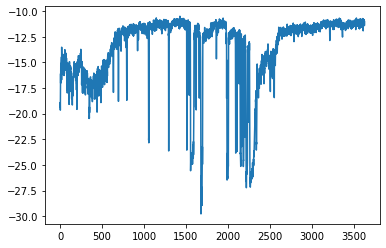

In [6]:
plt.plot(reward_records_)

In [7]:
import misc

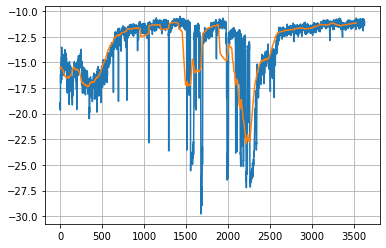

In [8]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


In [ ]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

In [ ]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)

In [ ]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

In [ ]:
# actor_model.save('actor_model_vanilla_det_singleImg_Adv')